In [1]:
import pandas as pd
#pd.set_option('display.max_rows', None)
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import path
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import numpy as np
import netCDF4 as nc
np.set_printoptions(threshold=100000)
from shapely.geometry import Polygon, Point, MultiPoint
from shapely.ops import cascaded_union
from datetime import datetime, timedelta
import time
import warnings
import statsmodels.api as sm
import datetime
import math
from scipy.ndimage.interpolation import shift

warnings.filterwarnings('ignore')
import seaborn as sns
from my_functions import sat_vap_press, vap_press, hot_dry_windy, haines

## Load Polygons and plot totals

In [2]:
ac_mcclure = gpd.read_file("/data2/lthapa/ML_daily/August_Complex_2020/August_Complex_2020/VIIRS_perdetect_growthonly_August_2020.shp")
ac_mcclure # TIME IS IN UTC

Fire_ID              DateTim Source      FRP  pixels      Grwth_A  \
0    2020_1480  2020-08-17 09:12:00  VIIRS   277.38      37  2052.295068   
1    2020_1480  2020-08-17 10:54:00  VIIRS  1151.72      43  1511.377711   
2    2020_1480  2020-08-18 08:54:00  VIIRS    41.89      12   276.682712   
3    2020_1480  2020-08-18 10:36:00  VIIRS    49.86      14   322.903531   
4    2020_1480  2020-08-18 20:18:00  VIIRS  1490.95      59  1655.623667   
..         ...                  ...    ...      ...     ...          ...   
176  2020_1480  2020-10-17 10:12:00  VIIRS    25.62      20    60.205030   
177  2020_1480  2020-10-18 09:54:00  VIIRS    23.79      20   125.654083   
178  2020_1480  2020-10-18 21:18:00  VIIRS   101.12       6     3.594788   
179  2020_1480  2020-10-19 09:36:00  VIIRS     3.44       4     0.000063   
180  2020_1480  2020-10-28 10:06:00  VIIRS     5.72       4    29.585247   

     wthn_bn                                           geometry  
0          1  MULTIPOLYGON (((-122.74983 39.58869, -122.7499...  
1          1  MULTIPOLYGON (((-122.74982 39.59149, -122.7498...  
2          1  MULTIPOLYGON (((-122.75290 39.59451, -122.7529...  
3          1  MULTIPOLYGON (((-122.77944 39.69342, -122.7793...  
4          1  MULTIPOLYGON (((-122.74285 39.59824, -122.7428...  
..       ...                                                ...  
176        1  MULTIPOLYGON (((-123.42704 40.18691, -123.4271...  
177        1  MULTIPOLYGON (((-123.08827 39.96052, -123.0882...  
178        1  MULTIPOLYGON (((-123.09004 40.24408, -123.0900...  
179        1  POLYGON ((-123.48914 40.28972, -123.48914 40.2...  
180        1  POLYGON ((-122.95606 39.80275, -122.95601 39.8...  

[181 rows x 8 columns]

In [3]:
# load in the polygons and attributes
fire_polygons = gpd.read_file('august_complex_polygons_only_VIIRS_difference.geojson') #polygons only
fire_attributes = pd.read_csv('august_complex_polygons_attributes_VIIRS_difference.csv') #other fire attributes
fire_attributes['Fire Name'] = fire_attributes['Fire Name'].str.upper() #make all fire names all caps
aug_complex_inds = np.where(fire_attributes['Fire Name']=='AUGUST COMPLEX')[0];
print(type(aug_complex_inds))

ac_thapa_att = fire_attributes.iloc[aug_complex_inds]

datestrings = [ac_thapa_att['Current Day'].iloc[i]+ ' '+\
               str(int(ac_thapa_att['Current Overpass'].iloc[i])).zfill(4) for i in range(len(ac_thapa_att))]

ac_thapa_poly = fire_polygons.iloc[aug_complex_inds]
ac_thapa = gpd.GeoDataFrame(pd.concat([ac_thapa_att, pd.DataFrame({'DateTim':datestrings}), ac_thapa_poly], axis=1))
ac_thapa

<class 'numpy.ndarray'>


Unnamed: 0  Incident Number       Fire Name Current Day  \
0              0       11843929.0  AUGUST COMPLEX  2020-08-18   
1              1       11843929.0  AUGUST COMPLEX  2020-08-18   
2              2       11843929.0  AUGUST COMPLEX  2020-08-18   
3              3       11843929.0  AUGUST COMPLEX  2020-08-18   
4              4       11843929.0  AUGUST COMPLEX  2020-08-18   
...          ...              ...             ...         ...   
1334        1334       11843929.0  AUGUST COMPLEX  2020-11-11   
1335        1335       11843929.0  AUGUST COMPLEX  2020-11-11   
1336        1336       11843929.0  AUGUST COMPLEX  2020-11-11   
1337        1337       11843929.0  AUGUST COMPLEX  2020-11-11   
1338        1338       11843929.0  AUGUST COMPLEX  2020-11-11   

      Current Overpass   Lat Fire    Lon Fire  Number of NEW VIIRS points  \
0                800.0  39.659444 -122.808889                         0.0   
1                806.0  39.659444 -122.808889                         0.0   
2                854.0  39.659444 -122.808889                        12.0   
3                900.0  39.659444 -122.808889                         0.0   
4                942.0  39.659444 -122.808889                         0.0   
...                ...        ...         ...                         ...   
1334            1936.0  39.659444 -122.808889                         0.0   
1335            2024.0  39.659444 -122.808889                         2.0   
1336            2112.0  39.659444 -122.808889                        16.0   
1337            2118.0  39.659444 -122.808889                         0.0   
1338            2206.0  39.659444 -122.808889                         2.0   

      NEW FRP          DateTim  \
0         NaN  2020-08-18 0800   
1         NaN  2020-08-18 0806   
2       41.89  2020-08-18 0854   
3         NaN  2020-08-18 0900   
4         NaN  2020-08-18 0942   
...       ...              ...   
1334      NaN  2020-11-11 1936   
1335    18.71  2020-11-11 2024   
1336   320.70  2020-11-11 2112   
1337      NaN  2020-11-11 2118   
1338    20.78  2020-11-11 2206   

                                               geometry  
0                           POINT (-122.80889 39.65944)  
1                                                  None  
2     POLYGON ((-122.74513 39.59618, -122.75537 39.5...  
3                                                  None  
4                                                  None  
...                                                 ...  
1334                                               None  
1335                                               None  
1336                                               None  
1337                                               None  
1338                                               None  

[1339 rows x 11 columns]

## Old version of plot all polygons

In [ ]:
ac_mcclure.plot(column = ac_mcclure['DateTim'])
plt.title('McClure')
plt.show()

ac_thapa_poly.plot()
plt.title('Thapa')
plt.show()

## New Version of plot all polygons (4/1/2022)
More red is later on, uses the per overpass version of my polygons


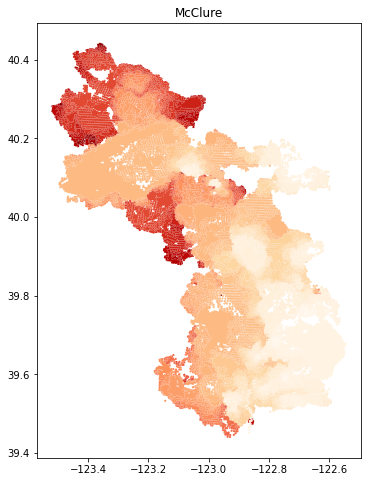

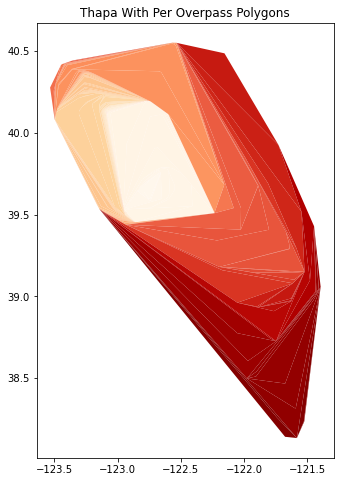

In [4]:
fig, ax = plt.subplots(figsize=(20,8)) #set up the figure
ac_mcclure.plot(column = ac_mcclure['DateTim'], ax=ax, cmap='OrRd')
plt.title('McClure')
plt.show()

fig, ax = plt.subplots(figsize=(20,8)) #set up the figure
ac_thapa.plot(column = ac_thapa['DateTim'], ax=ax, cmap='OrRd')
plt.title('Thapa With Per Overpass Polygons')
plt.show()

## Plot Daily AC

In [ ]:
# load in the polygons and attributes
fire_polygons = gpd.read_file('fire_polygons_only.geojson') #polygons only
fire_attributes = pd.read_csv('fire_polygons_attributes.csv') #other fire attributes
fire_attributes['Fire Name'] = fire_attributes['Fire Name'].str.upper() #make all fire names all caps
aug_complex_inds = np.where(fire_attributes['Fire Name']=='AUGUST COMPLEX')[0];

ac_thapa_att = fire_attributes.iloc[aug_complex_inds]

#datestrings = [ac_thapa_att['Current Day'].iloc[i]+ ' '+\
#               str(int(ac_thapa_att['Current Overpass'].iloc[i])).zfill(4) for i in range(len(ac_thapa))]

ac_thapa_poly = fire_polygons.iloc[aug_complex_inds]
ac_thapa = gpd.GeoDataFrame(pd.concat([ac_thapa_att, ac_thapa_poly], axis=1))
ac_thapa

fig, ax = plt.subplots(figsize=(20,8)) #set up the figure
ac_thapa.plot(column = ac_thapa['Current Day'], ax=ax, cmap='OrRd')
plt.title('Thapa With Daily Polygons')
plt.show()

## Generate time series

In [ ]:
#combine into daily polygons, originally we did this by sum, but that double counts

days = [ii[0:10] for ii in ac_mcclure['DateTim'].values]
ac_mcclure['Days'] = days
ac_mcclure_daily= ac_mcclure.dissolve(by='Days', aggfunc='sum',as_index=False)
ac_mcclure_daily

In [18]:
#average over the overpasses to avoid double counting
days = [ii[0:10] for ii in ac_mcclure['DateTim'].values]
ac_mcclure['Days'] = days
ac_mcclure_daily= ac_mcclure.dissolve(by='Days', aggfunc='max',as_index=False)
ac_mcclure_daily

Days                                           geometry    Fire_ID  \
0   2020-08-17  MULTIPOLYGON (((-122.74288 39.58689, -122.7429...  2020_1480   
1   2020-08-18  MULTIPOLYGON (((-122.73942 39.58791, -122.7394...  2020_1480   
2   2020-08-19  MULTIPOLYGON (((-122.86329 39.45283, -122.8632...  2020_1480   
3   2020-08-20  MULTIPOLYGON (((-122.70969 39.52476, -122.7098...  2020_1480   
4   2020-08-21  MULTIPOLYGON (((-122.91202 39.51314, -122.9121...  2020_1480   
..         ...                                                ...        ...   
59  2020-10-16  MULTIPOLYGON (((-123.24939 39.97622, -123.2494...  2020_1480   
60  2020-10-17  MULTIPOLYGON (((-123.42704 40.18691, -123.4271...  2020_1480   
61  2020-10-18  MULTIPOLYGON (((-123.08827 39.96052, -123.0882...  2020_1480   
62  2020-10-19  POLYGON ((-123.48914 40.28972, -123.48914 40.2...  2020_1480   
63  2020-10-28  POLYGON ((-122.95606 39.80275, -122.95601 39.8...  2020_1480   

                DateTim Source       FRP  pixels       Grwth_A  wthn_bn  
0   2020-08-17 10:54:00  VIIRS   1151.72      43   2052.295068        1  
1   2020-08-18 22:00:00  VIIRS   1490.95      59   1655.623667        1  
2   2020-08-19 21:42:00  VIIRS  61554.17    1275  53253.542093        1  
3   2020-08-20 21:24:00  VIIRS  45349.47    1598  43838.114817        1  
4   2020-08-21 21:00:00  VIIRS  14808.29    1095  26895.745938        1  
..                  ...    ...       ...     ...           ...      ...  
59  2020-10-16 21:54:00  VIIRS    208.01      44    506.807482        1  
60  2020-10-17 10:12:00  VIIRS     25.62      20     60.205030        1  
61  2020-10-18 21:18:00  VIIRS    101.12      20    125.654083        1  
62  2020-10-19 09:36:00  VIIRS      3.44       4      0.000063        1  
63  2020-10-28 10:06:00  VIIRS      5.72       4     29.585247        1  

[64 rows x 9 columns]

In [19]:
ac_thapa_daily = ac_thapa.dissolve(by='Current Day', aggfunc='max',as_index=False)
ac_thapa_daily

Current Day                                           geometry  Unnamed: 0  \
0   2020-08-18  POLYGON ((-122.94223 39.53097, -122.84170 39.6...          15   
1   2020-08-19  POLYGON ((-122.86665 39.45204, -122.87710 39.5...          33   
2   2020-08-20  POLYGON ((-122.67443 39.51714, -122.68256 39.5...          47   
3   2020-08-21  POLYGON ((-123.08426 40.11270, -123.08425 40.1...          64   
4   2020-08-22  POLYGON ((-122.92023 39.50605, -122.92345 39.5...          80   
..         ...                                                ...         ...   
81  2020-11-07  POLYGON ((-123.08621 40.24213, -123.15018 40.2...        1276   
82  2020-11-08  POLYGON ((-123.08621 40.24213, -123.15018 40.2...        1293   
83  2020-11-09  POLYGON ((-123.08621 40.24213, -123.15018 40.2...        1308   
84  2020-11-10  POLYGON ((-123.08621 40.24213, -123.15018 40.2...        1323   
85  2020-11-11  POLYGON ((-123.08621 40.24213, -123.15018 40.2...        1338   

    Incident Number       Fire Name  Current Overpass   Lat Fire    Lon Fire  \
0        11843929.0  AUGUST COMPLEX            2200.0  39.659444 -122.808889   
1        11843929.0  AUGUST COMPLEX            2142.0  39.659444 -122.808889   
2        11843929.0  AUGUST COMPLEX            2212.0  39.659444 -122.808889   
3        11843929.0  AUGUST COMPLEX            2154.0  39.659444 -122.808889   
4        11843929.0  AUGUST COMPLEX            2136.0  39.659444 -122.808889   
..              ...             ...               ...        ...         ...   
81       11843929.0  AUGUST COMPLEX            2142.0  39.659444 -122.808889   
82       11843929.0  AUGUST COMPLEX            2212.0  39.659444 -122.808889   
83       11843929.0  AUGUST COMPLEX            2154.0  39.659444 -122.808889   
84       11843929.0  AUGUST COMPLEX            2136.0  39.659444 -122.808889   
85       11843929.0  AUGUST COMPLEX            2206.0  39.659444 -122.808889   

    Number of VIIRS points       FRP          DateTim  
0                     61.0   2140.28  2020-08-18 2200  
1                   1251.0  61278.83  2020-08-19 2142  
2                   1599.0  61865.20  2020-08-20 2212  
3                   1095.0  15955.66  2020-08-21 2154  
4                    920.0   9421.96  2020-08-22 2136  
..                     ...       ...              ...  
81                     0.0       NaN  2020-11-07 2142  
82                     0.0       NaN  2020-11-08 2212  
83                     0.0       NaN  2020-11-09 2154  
84                     0.0       NaN  2020-11-10 2136  
85                     0.0       NaN  2020-11-11 2206  

[86 rows x 11 columns]

In [155]:
#get the days that are covered by both time series (stored in times)
times_mcclure = np.arange(np.datetime64(ac_mcclure_daily['Days'].iloc[0]),\
                          np.datetime64(ac_mcclure_daily['Days'].iloc[len(ac_mcclure_daily)-1])+np.timedelta64(1,'D'))
times_thapa = np.arange(np.datetime64(ac_thapa_daily['Current Day'].iloc[0]),\
                          np.datetime64(ac_thapa_daily['Current Day'].iloc[len(ac_thapa_daily)-1])+np.timedelta64(1,'D'))
days, c1, c2 = np.intersect1d(times_mcclure, times_thapa, return_indices=True)

print(days)

#c1
#The indices of the first occurrences of the common values in times_mcclure. Only provided if return_indices is True.

#c2
#The indices of the first occurrences of the common values in times_thapa. Only provided if return_indices is True.


['2020-08-18' '2020-08-19' '2020-08-20' '2020-08-21' '2020-08-22'
 '2020-08-23' '2020-08-24' '2020-08-25' '2020-08-26' '2020-08-27'
 '2020-08-28' '2020-08-29' '2020-08-30' '2020-08-31' '2020-09-01'
 '2020-09-02' '2020-09-03' '2020-09-04' '2020-09-05' '2020-09-06'
 '2020-09-07' '2020-09-08' '2020-09-09' '2020-09-10' '2020-09-11'
 '2020-09-12' '2020-09-13' '2020-09-14' '2020-09-15' '2020-09-16'
 '2020-09-17' '2020-09-18' '2020-09-19' '2020-09-20' '2020-09-21'
 '2020-09-22' '2020-09-23' '2020-09-24' '2020-09-25' '2020-09-26'
 '2020-09-27' '2020-09-28' '2020-09-29' '2020-09-30' '2020-10-01'
 '2020-10-02' '2020-10-03' '2020-10-04' '2020-10-05' '2020-10-06'
 '2020-10-07' '2020-10-08' '2020-10-09' '2020-10-10' '2020-10-11'
 '2020-10-12' '2020-10-13' '2020-10-14' '2020-10-15' '2020-10-16'
 '2020-10-17' '2020-10-18' '2020-10-19' '2020-10-20' '2020-10-21'
 '2020-10-22' '2020-10-23' '2020-10-24' '2020-10-25' '2020-10-26'
 '2020-10-27' '2020-10-28']


In [49]:
print(times[50])
#print(ac_thapa['Number of VIIRS points'].values)

2020-10-07


### MERRA Time Series

In [ ]:
#MERRA Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
temp=np.zeros((2, len(times)))
vpd=np.zeros((2, len(times)))
num_points = np.zeros((2, len(times)))
frp = np.zeros((2, len(times)))
wind =  np.zeros((2, len(times)))


varis = {'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4':['TLML', 'QLML']}
dims = {'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4':['lat', 'lon', 'time']}
time_extract= {'TLML':12, 'QLML':12, 'SPEEDLML':12, 'PS':12}


for ii in range(len(times)):
    print(ii)
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    path_merra = '/data2/lthapa/'+yr+'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4'
    if '*' in path_merra:
        path_merra = path_merra.replace('*', yr+mo+dy)
    if np.datetime64(date)>=np.datetime64('2020-09-01') and np.datetime64(date)<=np.datetime64('2020-09-30'):
        path_merra = path_merra.replace('400', '401')
    dat = nc.Dataset(path_merra)   
    lat = dat['lat'][:]
    lon = dat['lon'][:]
    t = dat['time'][:]
    if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat)
    T = dat['TLML'][:]
    Q = dat['QLML'][:]
    P = dat['PS'][:]
    W = dat['SPEEDLML'][:]
    print(T.shape)
    
    esat = sat_vap_press(T)
    e = vap_press(Q,P)
    VPD = esat-e
    
    
    lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
    
    #does a polygon exist for this time?
    
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        temp[0,ii] = np.nan
        vpd[0,ii] = np.nan
        wind[0,ii]= np.nan
        frp[0,ii] = np.nan
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',1)
        temp[1,ii] = np.max(feature_hourly(T, overlap_thapa))
        vpd[1,ii] = np.max(feature_hourly(VPD, overlap_thapa))
        wind[1,ii]= np.max(feature_hourly(W, overlap_thapa))
        num_points[1,ii] = ac_thapa_daily['Number of VIIRS points'].iloc[thapa_ind[0]]
        frp[1,ii] = ac_thapa_daily['FRP'].iloc[thapa_ind[0]]
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        temp[1,ii] = np.nan
        vpd[1,ii] = np.nan
        wind[1,ii]= np.nan
        num_points[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'rectilinear',1)
        temp[0,ii] = np.max(feature_hourly(T, overlap_mcclure))
        vpd[0,ii] = np.max(feature_hourly(VPD, overlap_mcclure))
        wind[0,ii]= np.max(feature_hourly(W, overlap_mcclure))
        frp[0,ii] = ac_mcclure_daily['FRP'].iloc[mcclure_ind[0]]
        num_points[0,ii] = ac_mcclure_daily['pixels'].iloc[mcclure_ind[0]]
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'rectilinear',1)
    
    temp[0,ii] = np.max(feature_hourly(T, overlap_mcclure))
        vpd[0,ii] = np.max(feature_hourly(VPD, overlap_mcclure))
        wind[0,ii]= np.max(feature_hourly(W, overlap_mcclure))
        frp[0,ii] = ac_mcclure_daily['FRP'].iloc[mcclure_ind[0]]
        num_points[0,ii] = ac_mcclure_daily['pixels'].iloc[mcclure_ind[0]]

        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',1)
        temp[1,ii] = np.max(feature_hourly(T, overlap_thapa))
        vpd[1,ii] = np.max(feature_hourly(VPD, overlap_thapa))
        wind[1,ii]= np.max(feature_hourly(W, overlap_thapa))
        frp[1,ii] = ac_thapa_daily['FRP'].iloc[thapa_ind[0]]
        num_points[1,ii] = ac_thapa_daily['Number of VIIRS points'].iloc[thapa_ind[0]]
    

In [ ]:
#print(temp, vpd, frp)
print(num_points)
#print(frp)
#print(len(wind[0,:]))

### FCCS Time Series

In [ ]:
varis = {'/static_maps/static_map_1km.nc4': ['fccs', 'slp', 'asp']}
#0=lat, 1=lon, 2=time, 3=level 
dims = {'/static_maps/static_map_1km.nc4': ['lat', 'lon']}

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
fuels = np.zeros((2, len(times)))
slopes = np.zeros((2, len(times)))
aspects = np.zeros((2, len(times)))

# load in the FCCS Data
path = '../static_maps/static_map_1km.nc4'
dat = nc.Dataset(path)  

lat = dat['lat'][:]
lon = dat['lon'][:]
fccs = dat['fccs'][:]
slp = dat['slp'][:]
asp = dat['asp'][:]

if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat) 
lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)


for ii in range(len(times)):
    print(ii)
    
    
    #does a polygon exist for this time?
    
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    print(mcclure_ind)
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        fuels[0,ii] = np.nan
        slopes[0,ii] = np.nan
        aspects[0,ii] = np.nan
        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        overlap_thapa_buff = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0].buffer(0.05)) #0.05 degree buffer to check fuels 
        fuels[1,ii] = find_mode(fccs[np.where(overlap_thapa==0) and np.where(overlap_thapa_buff!=0)])
        slopes[1,ii] = np.nanmax(slp[np.where(overlap_thapa==0) and np.where(overlap_thapa_buff!=0)])
        aspects[1,ii] = find_mode(asp[np.where(overlap_thapa==0) and np.where(overlap_thapa_buff!=0)])
    
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        fuels[1,ii] = np.nan
        slopes[1,ii] = np.nan
        aspects[1,ii]= np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        overlap_mcclure_buff = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0].buffer(0.05))
        fuels[0,ii] = find_mode(fccs[np.where(overlap_mcclure==0) and np.where(overlap_mcclure_buff!=0)])
        slopes[0,ii] = np.nanmax(slp[np.where(overlap_mcclure==0) and np.where(overlap_mcclure_buff!=0)])
        aspects[0,ii] = find_mode(asp[np.where(overlap_mcclure==0) and np.where(overlap_mcclure_buff!=0)])
        
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        overlap_mcclure_buff = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0].buffer(0.05))
        fuels[0,ii] = find_mode(fccs[np.where(overlap_mcclure==0) and np.where(overlap_mcclure_buff!=0)])
        slopes[0,ii] = np.nanmax(slp[np.where(overlap_mcclure==0) and np.where(overlap_mcclure_buff!=0)])
        aspects[0,ii] = find_mode(asp[np.where(overlap_mcclure==0) and np.where(overlap_mcclure_buff!=0)])

        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        overlap_thapa_buff = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0].buffer(0.05)) #0.05 degree buffer to check fuels 
        fuels[1,ii] = find_mode(fccs[np.where(overlap_thapa==0) and np.where(overlap_thapa_buff!=0)])
        slopes[1,ii] = np.nanmax(slp[np.where(overlap_thapa==0) and np.where(overlap_thapa_buff!=0)])
        aspects[1,ii] = find_mode(asp[np.where(overlap_thapa==0) and np.where(overlap_thapa_buff!=0)])
    

In [ ]:
#print(fuels, slopes, aspects)
#print(times, personnel)
#print(temp, vpd, frp)
#print(num_points)

ac_dict = {'Day': times, 'fuels_thapa': fuels[1,:], 'slopes_thapa':slopes[1,:], 'aspects_thapa':aspects[1,:],\
          'fuels_mcclure': fuels[0,:], 'slopes_mcclure':slopes[0,:], 'aspects_mcclure':aspects[0,:]}

df_ac = pd.DataFrame(ac_dict)
df_ac.to_csv('Fuels_Info_August_Complex.csv')



### GBBEPx Time Series (created 4/4/2022)

In [88]:
#MERRA Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for

df_gbbepx_thapa = pd.DataFrame({'Mean_FRP':np.zeros(len(times)),\
                          'FRE':np.zeros(len(times)),  'CO2':np.zeros(len(times)),  'CO':np.zeros(len(times)),\
                          'SO2':np.zeros(len(times)),  'OC':np.zeros(len(times)),  'BC':np.zeros(len(times)),\
                          'PM2.5':np.zeros(len(times)),  'NOx':np.zeros(len(times)),  'NH3':np.zeros(len(times))})
df_gbbepx_mcclure = pd.DataFrame({'Mean_FRP':np.zeros(len(times)),\
                          'FRE':np.zeros(len(times)),  'CO2':np.zeros(len(times)),  'CO':np.zeros(len(times)),\
                          'SO2':np.zeros(len(times)),  'OC':np.zeros(len(times)),  'BC':np.zeros(len(times)),\
                          'PM2.5':np.zeros(len(times)),  'NOx':np.zeros(len(times)),  'NH3':np.zeros(len(times))})


#loop over times
#loop over variables
# put it all into a dataframe

varis = ['Mean_FRP', 'FRE', 'CO2', 'CO', 'SO2', 'OC', 'BC', 'PM2.5', 'NOx', 'NH3'] #don't need 'area', it's the area of each cell
path_prefix = '/data2/lthapa/2020/Apr2020_to_Oct2020/'
file_prefix = 'Hourly_Emissions_FV3_13km_'

for ii in range(1):#len(times)):
    print(ii)
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    
    path_gbbepx = path_prefix + file_prefix + yr+mo+dy+'0000_'+yr+mo+dy+'2300.nc'
    dat = nc.Dataset(path_gbbepx) # load in the data
    lat_corner = dat['Latitude'][:] #get the lat/lons
    lon_corner = dat['Longitude'][:]-360 #need to convert to degrees west or negative lon
    lat_center, lon_center = calculate_grid_cell_corners(lat_corner, lon_corner)
    
    print(lat_corner.shape, lat_center.shape)

    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print('No McClure poly!')
        df_gbbepx_mcclure.iloc[ii] = np.nan*np.zeros((1,10)) #nan for this instance
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat_center,lon_center,lat_corner,lon_corner,poly_thapa.iloc[0],'curvilinear',1)
        overlap_thapa[np.where(overlap_thapa!=0)]=1
        print(overlap_thapa.shape)
        for var in varis:
            field = np.swapaxes(np.swapaxes(dat[var][:], 0,2), 1,2)
            print(var, field.shape, overlap_thapa.shape)
            print(np.sum(feature_hourly(field, overlap_thapa)))
            df_gbbepx_thapa[var].iloc[ii] = np.sum(feature_hourly(field, overlap_thapa))
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        df_gbbepx_thapa.iloc[ii] = np.nan*np.zeros((1,10)) #nan for this instance
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat_center,lon_center,lat_corner,lon_corner,poly_mcclure.iloc[0],'curvilinear',1)
        overlap_mcclure[np.where(overlap_mcclure!=0)]=1
        print(overlap_mcclure.shape)
        for var in varis:
            field = np.swapaxes(np.swapaxes(dat[var][:], 0,2), 1,2)
            print(var, field.shape, overlap_mcclure.shape)
            print(np.sum(feature_hourly(field, overlap_mcclure)))
            df_gbbepx_mcclure[var].iloc[ii] = np.sum(feature_hourly(field, overlap_mcclure))
            
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat_center,lon_center,lat_corner,lon_corner,poly_mcclure.iloc[0], 'curvilinear',1)
        overlap_mcclure[np.where(overlap_mcclure!=0)]=1
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat_center,lon_center,lat_corner,lon_corner,poly_thapa.iloc[0], 'curvilinear',1)
        overlap_thapa[np.where(overlap_thapa!=0)]=1
        # print(np.where(overlap_thapa!=0))
        for var in varis:
            field = np.swapaxes(np.swapaxes(dat[var][:], 0,2), 1,2)
           #print(var,np.sum(feature_hourly(field, overlap_mcclure)),np.sum(feature_hourly(field, overlap_thapa)))
            df_gbbepx_mcclure[var].iloc[ii] = np.sum(feature_hourly(field, overlap_mcclure))
            df_gbbepx_thapa[var].iloc[ii] = np.sum(feature_hourly(field, overlap_thapa))


    #fig = plt.figure(figsize=(15,10))
    #ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
    #ax.coastlines()
    #ax.set_extent([-123.4, -122.6, 39.4, 40.5])
    #ax.coastlines()
    #ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
    #plt.scatter(lon_center,lat_center, c=np.sum(field, axis=0))
    #poly_thapa.plot(ax=ax, color ='r', alpha=0.5)
    #plt.title('GPPEPx OC Daily Emissions: '+yr+mo+dy)
    #plt.colorbar()
    #plt.show()    
            
df_gbbepx_thapa

0
(233, 397) (232, 396)
0 both polys


NameError: name 'calculate_overlaps' is not defined

### COD Time Series

In [ ]:
#COD Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for

cod_out =  np.zeros((2, len(times)))


#loop over times
#loop over variables
# put it all into a dataframe

varis = ['cod'] #don't need 'area', it's the area of each cell
path_prefix = '/data2/lthapa/2020/COD_Aggregated/'
file_prefix = 'MAX_COD_'

#load in one file for shapes
dat_test = nc.Dataset('/data2/lthapa/2020/COD_Aggregated/MAX_COD_2020112821.nc')
data_cod = nc.Dataset('/data2/lthapa/2019/COD/201908615/OR_ABI-L2-CODC-M3_G16_s20190861502162_e20190861504535_c20190861506227.nc')
lat_ctr, lon_ctr = project_abi(data_cod)
lat_corner, lon_corner = calculate_grid_cell_corners(lat_ctr, lon_ctr)

#print((24, lat_test.shape[0], lat_test.shape[1]))
for ii in range(len(times)):
    print(ii)
    cod = np.zeros((24, lat_ctr.shape[0], lat_ctr.shape[1])) #preallocate an array for COD
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    
    
    path_cod = path_prefix + file_prefix + yr+mo+dy+'*.nc'
    hr = 0
    for item in os.listdir(path_prefix):
        if (yr+mo+dy in item) and (file_prefix in item):
            #build the grid that contains info for the day
            path_cod =path_prefix + item
            #print(path_cod)
            dat = nc.Dataset(path_cod) # load in the data
            lat_corner, lon_corner =calculate_grid_cell_corners(lat_ctr, lon_ctr)
            cod[hr,:] = dat['cod'][0,:]
            hr=hr+1
            
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    if len(mcclure_ind[0])==0:
        print('No McClure poly!')
        cod_out[0,ii] = np.nan
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat_ctr, lon_ctr,lat_corner,lon_corner,poly_thapa.iloc[0],'curvilinear',0.05)
        print(overlap_thapa.shape)
        cod_out[1,ii] = np.max(feature_hourly(cod, overlap_thapa))
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        cod_out[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat_ctr, lon_ctr,lat_corner,lon_corner,poly_mcclure.iloc[0],'curvilinear',0.05)
        print(overlap_mcclure.shape)
        cod_out[0,ii] = np.max(feature_hourly(cod, overlap_mcclure))
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat_ctr, lon_ctr,lat_corner,lon_corner,poly_mcclure.iloc[0], 'curvilinear',0.05)
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat_ctr, lon_ctr,lat_corner,lon_corner,poly_thapa.iloc[0], 'curvilinear',0.05)
        cod_out[0,ii] = np.max(feature_hourly(cod, overlap_mcclure))
        cod_out[1,ii] = np.max(feature_hourly(cod, overlap_thapa))

### QFED Time Series (Created 4/5/2022)

In [ ]:
#MERRA Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
pm25_daily_total=np.zeros((2, len(times)))
pm25_daily_rate=np.zeros((2, len(times)))

for ii in range(len(times)):
    print(ii)
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    path_qfed = '/data2/lthapa/2020/QFED/WESTUS_qfed2.emis_pm25.006.*.nc4'

    if '*' in path_qfed:
        path_qfed = path_qfed.replace('*', yr+mo+dy)
    print(path_qfed)
    
    dat = nc.Dataset(path_qfed)   
    lat = dat['lat'][:]
    lon = dat['lon'][:]
    per_box = area_per_grid_cell(lat, lon, 0.1, 0.1)
    print(per_box.shape)
    t = dat['time'][:]
    
    if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat)
            
    pm_total = dat['biomass'][0,:]*per_box*24*3600 #daily total
    pm_rate = dat['biomass'][0,:] #daily rate
    #co = dat['biomass'][0,:]
    #co=co*per_box*3600
    
    
    lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
    

    #does a polygon exist for this time?
    
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        pm25_daily_total[0,ii] = np.nan
        pm25_daily_rate[0,ii] = np.nan
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',1)
        overlap_thapa[np.where(overlap_thapa!=0)]=1
        #carbon_monoxide[1,ii] = np.mean(feature_hourly(co, overlap_thapa))
        pm25_daily_total[1,ii] = np.mean(feature_hourly(pm_total, overlap_thapa))
        pm25_daily_rate[1,ii] = np.mean(feature_hourly(pm_rate, overlap_thapa))
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        pm25_daily_total[1,ii] = np.nan
        pm25_daily_rate[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'rectilinear',1)
        overlap_mcclure[np.where(overlap_mcclure!=0)]=1
        pm25_daily_total[0,ii] = np.mean(feature_hourly(pm_total, overlap_mcclure))
        pm25_daily_rate[0,ii] = np.mean(feature_hourly(pm_rate, overlap_mcclure))

    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'rectilinear',1)
        overlap_mcclure[np.where(overlap_mcclure!=0)]=1
        pm25_daily_total[0,ii] = np.mean(feature_hourly(pm_total, overlap_mcclure))
        pm25_daily_rate[0,ii] = np.mean(feature_hourly(pm_rate, overlap_mcclure))
        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',1)
        overlap_thapa[np.where(overlap_thapa!=0)]=1
        pm25_daily_total[1,ii] = np.mean(feature_hourly(pm_total, overlap_thapa))
        pm25_daily_rate[1,ii] = np.mean(feature_hourly(pm_rate, overlap_thapa))

In [ ]:
print(carbon_monoxide)

### NCAR Fuel Moisture

In [45]:
#NCAR Moisture Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
mlive=np.zeros((2, len(times)))
mdead=np.zeros((2, len(times)))


for ii in range(len(times)):
    print(ii)
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    path_fmc = '/data2/lthapa/2020/FMC/fmc_*_20Z.nc'

    if '*' in path_fmc:
        path_fmc = path_fmc.replace('*', yr+mo+dy)
    print(path_fmc)
    
    try:
        dat = nc.Dataset(path_fmc)  
    except:
        print("No file for this day")
    lat = dat['XLAT_M'][0,:]
    lon = dat['XLONG_M'][0,:]
    print(lon.shape)
    #t = dat['time'][:]
    
    if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat)
    living = dat['FMCGLH2D'][0,:]
    dead = dat['FMCG2D'][0,:]
    print(living)
    
    
    lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
    

    #does a polygon exist for this time?
    
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        mlive[0,ii] = np.nan
        mdead[0,ii] = np.nan
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'curvilinear',0.05)
        mlive[1,ii] = np.mean(feature_hourly(living, overlap_thapa))
        mdead[1,ii] = np.mean(feature_hourly(dead, overlap_thapa))
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        mlive[1,ii] = np.nan
        mdead[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'curvilinear',0.05)
        mlive[0,ii] = np.mean(feature_hourly(living, overlap_mcclure))
        mdead[0,ii] = np.mean(feature_hourly(dead, overlap_mcclure))

    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'curvilinear',0.05)
        mlive[0,ii] = np.mean(feature_hourly(living, overlap_mcclure))
        mdead[0,ii] = np.mean(feature_hourly(dead, overlap_mcclure))
        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'curvilinear',0.05)
        mlive[1,ii] = np.mean(feature_hourly(living, overlap_thapa))
        mdead[1,ii] = np.mean(feature_hourly(dead, overlap_thapa))

0
/data2/lthapa/2020/FMC/fmc_20200818_20Z.nc
(3179, 5399)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 both polys
-123.12854617367373 39.531549943997994 -122.60178526711984 40.17312225876665
530 591 1996 2076
[1.02456218 1.02456218 1.02456218 1.02456218 1.02456218 1.02456218
 1.02456218 1.02456218 1.02456218 1.02456218 1.02456218 1.02456218
 1.02456218 1.02456218 1.02456218 1.02456218 1.02456218 1.02456218
 1.02456218 1.02456218 1.02456218 1.02456218 1.02456218 1.02456218]


KeyboardInterrupt: 

In [ ]:
#print(mlive)
#print(mdead)

mlive[:,22]=[np.nan, np.nan]
mdead[:,22]=[np.nan, np.nan]


moisture = {'DateTim': times, 'Live McClure': mlive[0,:], 'Live Thapa': mlive[1,:],\
           'Dead McClure':mdead[0,:], 'Dead Thapa': mdead[1,:]}
df_moisture = pd.DataFrame(moisture)
df_moisture
df_moisture.to_csv('Moisture_Info_August_Complex.csv')

### IGBP Fuels (created 4/13/2022)

In [20]:
#NCAR Moisture Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
df_igbp_thapa = pd.DataFrame({'% water':np.zeros(len(times)), '% evergreen needleleaf forest':np.zeros(len(times)),\
                              '% evergreen broadleaf forest':np.zeros(len(times)),\
                              '% deciduous needleleaf forest':np.zeros(len(times)),\
                               '% deciduous broadleaf forest':np.zeros(len(times)), '% mixed forests':np.zeros(len(times)),\
                              '% closed shrubland':np.zeros(len(times)), '% open shrublands':np.zeros(len(times)),\
                              '% woody savannas':np.zeros(len(times)),'% savannas':np.zeros(len(times)),\
                              '% grasslands':np.zeros(len(times)), '% permanent wetlands':np.zeros(len(times)),\
                              '% croplands':np.zeros(len(times)), '% urban and built-up':np.zeros(len(times)),\
                              '% cropland/natural vegetation mosaic':np.zeros(len(times)),\
                              '% snow and ice':np.zeros(len(times)),\
                              '% barren or sparsely vegetated':np.zeros(len(times))})

df_igbp_mcclure = pd.DataFrame({'% water':np.zeros(len(times)), '% evergreen needleleaf forest':np.zeros(len(times)),\
                              '% evergreen broadleaf forest':np.zeros(len(times)),\
                              '% deciduous needleleaf forest':np.zeros(len(times)),\
                               '% deciduous broadleaf forest':np.zeros(len(times)), '% mixed forests':np.zeros(len(times)),\
                              '% closed shrubland':np.zeros(len(times)), '% open shrublands':np.zeros(len(times)),\
                              '% woody savannas':np.zeros(len(times)),'% savannas':np.zeros(len(times)),\
                              '% grasslands':np.zeros(len(times)), '% permanent wetlands':np.zeros(len(times)),\
                              '% croplands':np.zeros(len(times)), '% urban and built-up':np.zeros(len(times)),\
                              '% cropland/natural vegetation mosaic':np.zeros(len(times)),\
                              '% snow and ice':np.zeros(len(times)),\
                              '% barren or sparsely vegetated':np.zeros(len(times))})
#load in the data here so we only have to do it once

dat = nc.Dataset('/data2/lthapa/static_maps/MODIS_IGBP_2020.nc')
lat_center = dat['lat'][:]
lon_center = dat['lon'][:]
lc_majority= dat['lc_majority'][:]
lc_percent = dat['lc_percent'][:]
print(lc_percent.shape)

lat_inds = np.where((lat_center[:,0]>=31)& (lat_center[:,0]<=51))[0]
lat_start = lat_inds[0]
lat_end = lat_inds[len(lat_inds)-1]
lon_inds = np.where((lon_center[0,:]>=-126)& (lon_center[0,:]<=-101))[0]
lon_start = lon_inds[0]
lon_end = lon_inds[len(lon_inds)-1]

lat_corners, lon_corners = calculate_grid_cell_corners(lat_center, lon_center)

for ii in range(len(times)):
    print(ii)
    
    #does a polygon exist for this time?
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat_center,lon_center,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',0.05)
        overlap_thapa[np.where(overlap_thapa!=0)]=1
        overlap_thapa[np.where(overlap_thapa==0)]=np.nan
        for jj in range(17):
            df_igbp_mcclure.iloc[ii,jj] = np.nan 
            df_igbp_thapa.iloc[ii,jj] = np.nanmean(np.multiply(overlap_thapa, lc_percent[jj, :,:]))#average percentage over polygon of each fuel


    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat_center,lon_center,lat_corners,lon_corners,poly_mcclure.iloc[0], 'rectilinear',0.05)
        overlap_mcclure[np.where(overlap_mcclure!=0)]=1
        overlap_mcclure[np.where(overlap_mcclure==0)]=np.nan
        for jj in range(17):
            df_igbp_mcclure.iloc[ii,jj] = np.nanmean(np.multiply(overlap_mcclure, lc_percent[jj, :,:])) #average percentage over polygon of each fuel
            df_igbp_thapa.iloc[ii,jj] = np.nan

    else:
        print(ii, 'both polys')
        
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat_center,lon_center,lat_corners,lon_corners,poly_mcclure.iloc[0], 'rectilinear',0.05)
        overlap_mcclure[np.where(overlap_mcclure!=0)]=1
        overlap_mcclure[np.where(overlap_mcclure==0)]=np.nan
        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat_center,lon_center,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',0.05)
        overlap_thapa[np.where(overlap_thapa!=0)]=1
        overlap_thapa[np.where(overlap_thapa==0)]=np.nan
        
        for jj in range(17):
            df_igbp_mcclure.iloc[ii,jj] = np.nanmean(np.multiply(overlap_mcclure, lc_percent[jj, :,:])) #average percentage over polygon of each fuel
            df_igbp_thapa.iloc[ii,jj] = np.nanmean(np.multiply(overlap_thapa, lc_percent[jj, :,:]))


            
df_igbp_thapa

(17, 3600, 7200)
0
0 both polys
-123.12854617367373 39.531549943997994 -122.60178526711984 40.17312225876665
1137 1147 2590 2603
-122.99221479844107 39.48098494375695 -122.6004701645434 39.82121398348431
1140 1147 2589 2596
1
1 both polys
-123.13186514959969 39.39934104780061 -122.49512257834421 40.21791581796141
1137 1150 2587 2604
-123.12916253693986 39.40205864969734 -122.35906587248148 40.21520519322455
1137 1152 2588 2604
2
2 both polys
-123.13713680505869 39.46090216478306 -122.49268950704612 40.23431476485806
1137 1150 2589 2604
-123.23686330067049 39.46237414490977 -122.49620922788675 40.24372186762382
1135 1150 2589 2604
3
3 both polys
-123.13945616800781 39.45798416661846 -122.54729433727233 40.246990718910936
1137 1149 2589 2604
-123.13588029858532 39.4595145486251 -122.53441625072952 40.2442595200012
1137 1149 2589 2604
4
4 both polys
-123.14052399028796 39.454619156493166 -122.55050672043714 40.25043975940609
1137 1148 2589 2605
-123.13717414601894 39.45609737544181 -122.5

1132 1143 2590 2608
-123.37257152865213 39.983154061251355 -122.83790198439094 40.425356184035074
1132 1143 2599 2608
40
40 both polys
-123.45921189367459 39.453675500185106 -122.83702423006555 40.43685057826306
1130 1143 2589 2608
-123.45568497538312 39.45113274439418 -122.80585636732165 40.434109035908115
1130 1143 2589 2608
41
41 both polys
-123.52342630852831 39.46243878594186 -122.83591821978274 40.444056334502974
1129 1143 2589 2608
-123.5394891950518 39.45309517086292 -122.69700156748192 40.441348879359104
1129 1146 2589 2608
42
42 both polys
-123.54263720225926 39.776607252818515 -122.83455987417997 40.469203237982526
1129 1143 2595 2609
-123.53909795941951 39.45255562138759 -122.79058507366462 40.46824439630221
1129 1144 2589 2609
43
43 both polys
-123.54260622045524 39.53374051996838 -122.83397337853818 40.46966823088863
1129 1143 2590 2609
-123.53906289617979 39.78272135051288 -122.81851201020004 40.470329381676315
1129 1143 2595 2609
44
44 both polys
-123.54622725532856 39.

% water  % evergreen needleleaf forest  % evergreen broadleaf forest  \
0       0.0                      59.772727                           0.0   
1       0.0                      37.486486                           0.0   
2       0.0                      40.624204                           0.0   
3       0.0                      41.901515                           0.0   
4       0.0                      43.896825                           0.0   
..      ...                            ...                           ...   
67      0.0                      97.000000                           0.0   
68      0.0                      97.000000                           0.0   
69      0.0                      97.000000                           0.0   
70      0.0                      97.000000                           0.0   
71      0.0                      95.000000                           0.0   

    % deciduous needleleaf forest  % deciduous broadleaf forest  \
0                             0.0                      0.000000   
1                             0.0                      0.020270   
2                             0.0                      0.019108   
3                             0.0                      0.022727   
4                             0.0                      0.023810   
..                            ...                           ...   
67                            0.0                      0.000000   
68                            0.0                      0.000000   
69                            0.0                      0.000000   
70                            0.0                      0.000000   
71                            0.0                      0.000000   

    % mixed forests  % closed shrubland  % open shrublands  % woody savannas  \
0          0.181818            0.454545           2.545455         24.136364   
1          0.054054            2.081081           3.270270         29.290541   
2          0.050955            2.019108           3.477707         34.070064   
3          0.060606            2.121212           3.037879         33.143939   
4          0.063492            2.214286           2.793651         34.666667   
..              ...                 ...                ...               ...   
67         0.000000            0.000000           0.000000          3.000000   
68         0.000000            0.000000           0.000000          3.000000   
69         0.000000            0.000000           0.000000          3.000000   
70         0.000000            0.000000           0.000000          3.000000   
71         0.000000            0.000000           0.000000          5.000000   

    % savannas  % grasslands  % permanent wetlands  % croplands  \
0     2.045455     10.863636              0.000000     0.000000   
1     2.364865     25.391892              0.027027     0.000000   
2     3.261146     16.401274              0.025478     0.044586   
3     2.757576     16.924242              0.030303     0.000000   
4     3.841270     12.468254              0.031746     0.000000   
..         ...           ...                   ...          ...   
67    0.000000      0.000000              0.000000     0.000000   
68    0.000000      0.000000              0.000000     0.000000   
69    0.000000      0.000000              0.000000     0.000000   
70    0.000000      0.000000              0.000000     0.000000   
71    0.000000      0.000000              0.000000     0.000000   

    % urban and built-up  % cropland/natural vegetation mosaic  \
0               0.000000                                   0.0   
1               0.013514                                   0.0   
2               0.006369                                   0.0   
3               0.000000                                   0.0   
4               0.000000                                   0.0   
..                   ...                                   ...   
67              0.000000                                  

In [21]:
df_igbp_thapa.to_csv('AC_IGBP_Thapa.csv')
df_igbp_mcclure.to_csv('AC_IGBP_McClure.csv')

In [ ]:
 #this plots the fuel types with polygons overlaid  
    
    fig = plt.figure(figsize=(15,10))
        ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_extent([-123.5, -122.3, 39.4, 40.5])
        ax.coastlines()
        ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        levels = np.arange(-0.5,17.5,1) #need to specify levels for the contours
        print(levels)
        fuelmap = plt.contourf(lon_center[lat_start:lat_end, lon_start:lon_end],\
            lat_center[lat_start:lat_end, lon_start:lon_end],\
           lc_majority[lat_start:lat_end, lon_start:lon_end],\
            levels=levels,cmap='gist_ncar')
        gpd.GeoSeries(poly_mcclure).plot(ax=ax, color='w', alpha=0.75)
        plt.show()

## Time Series Map McClure IGBP

(17, 3600, 7200)
0
0 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


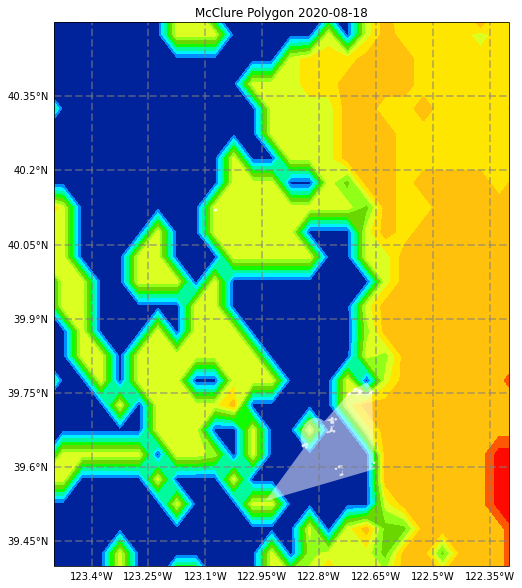

1
1 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


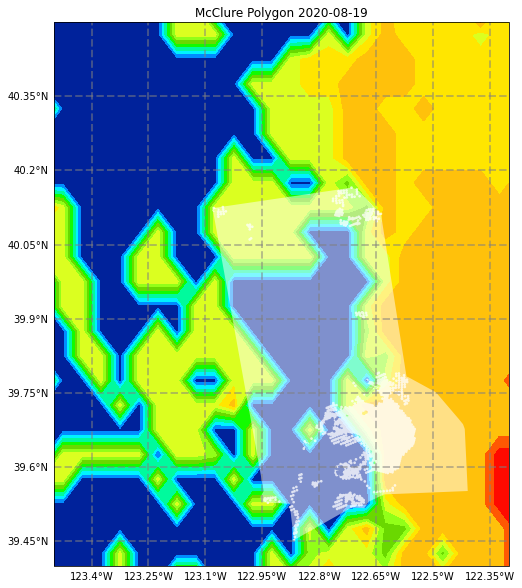

2
2 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


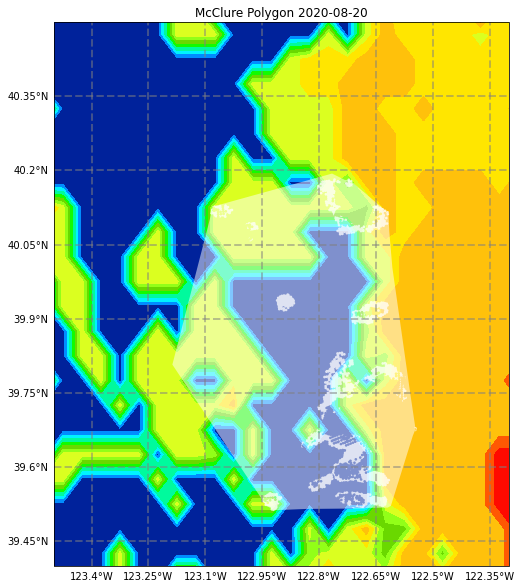

3
3 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


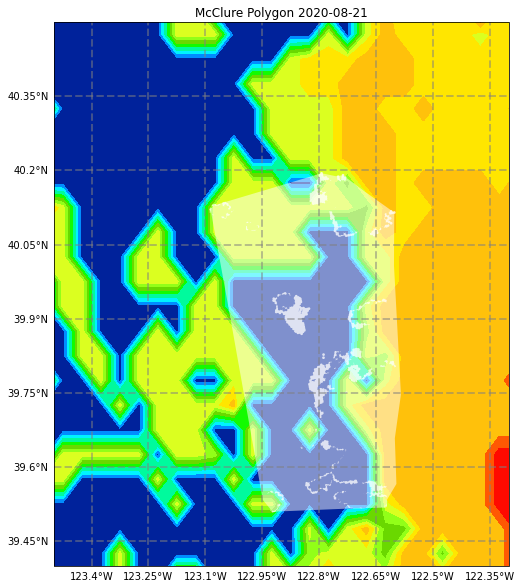

4
4 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


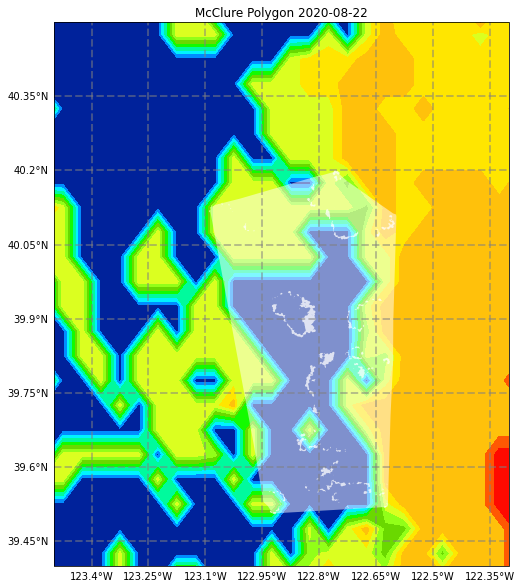

5
5 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


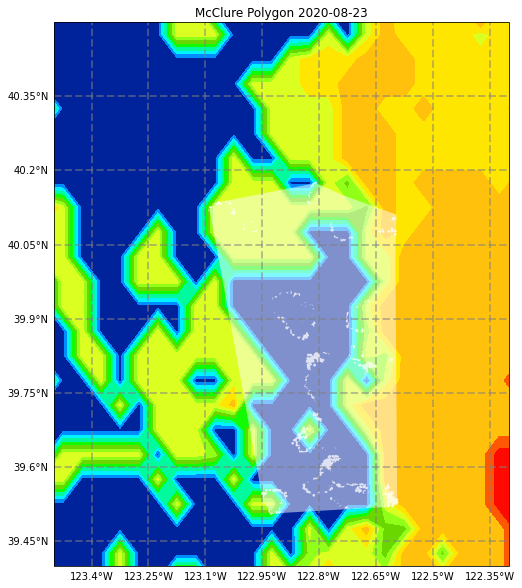

6
6 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


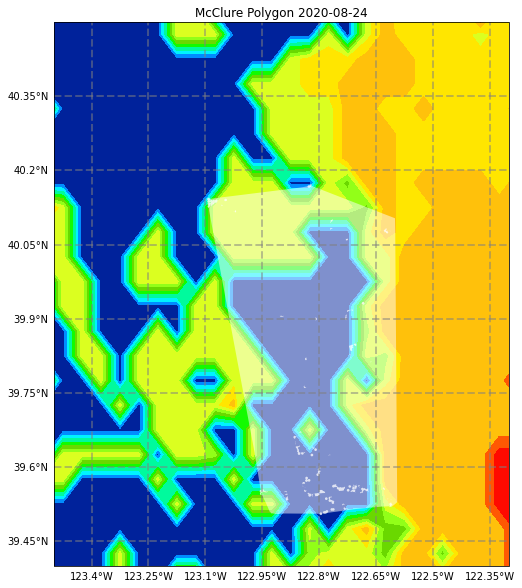

7
7 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


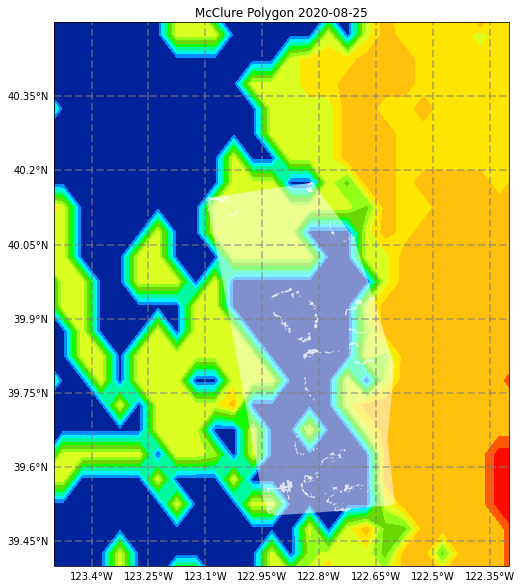

8
8 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


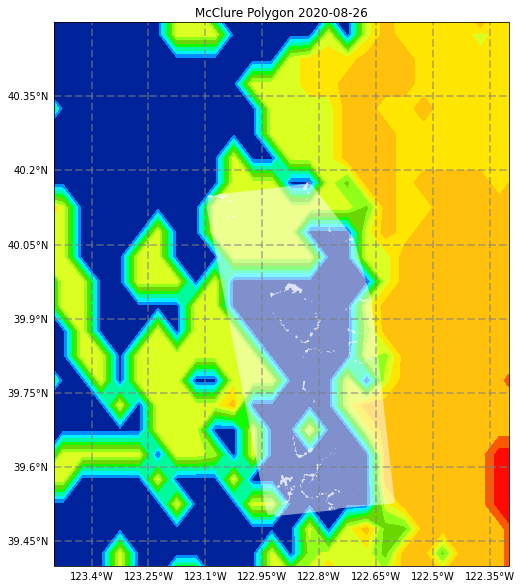

9
9 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


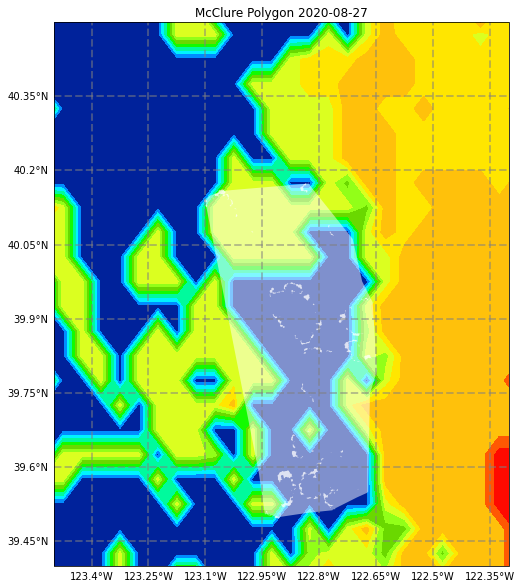

10
10 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


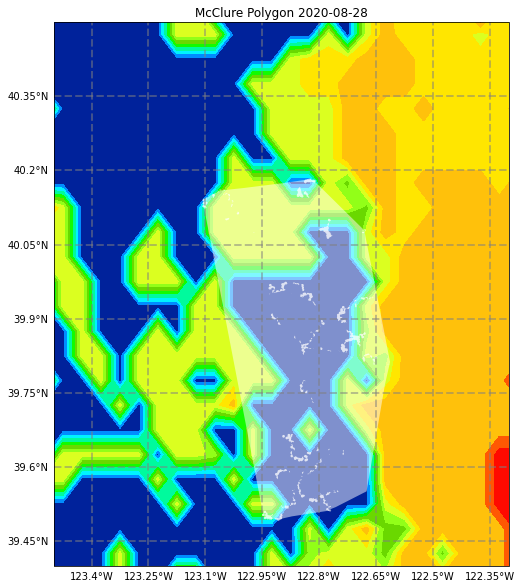

11
11 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


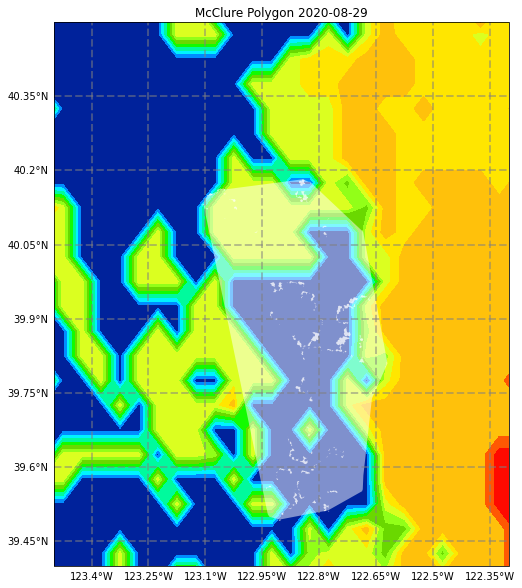

12
12 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


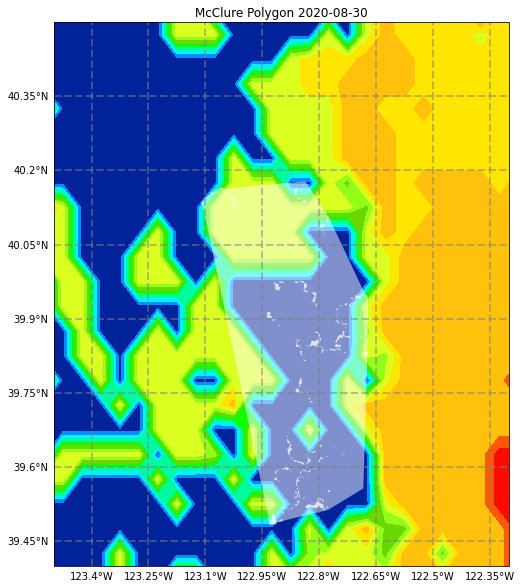

13
13 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


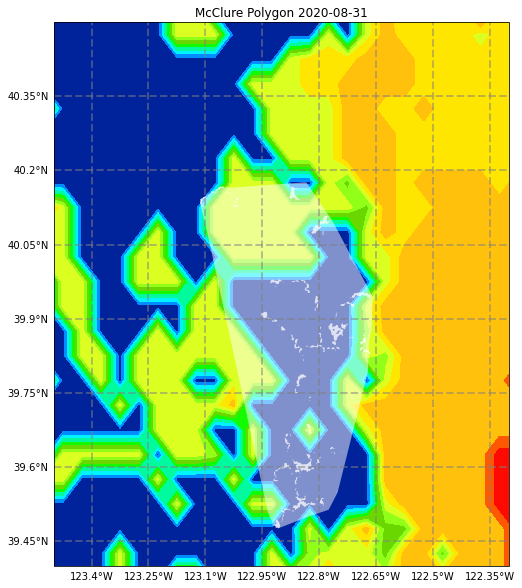

14
14 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


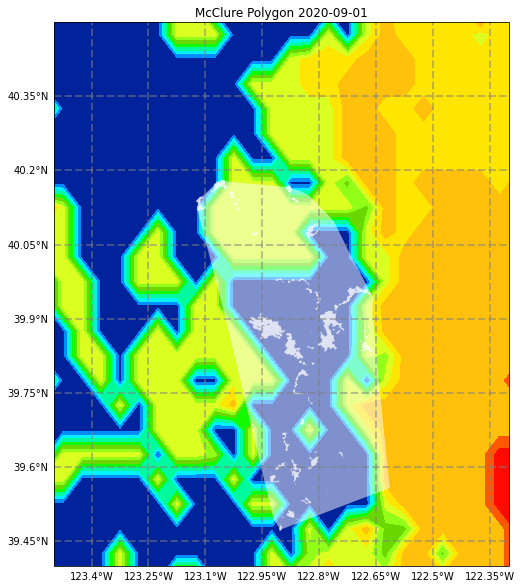

15
15 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


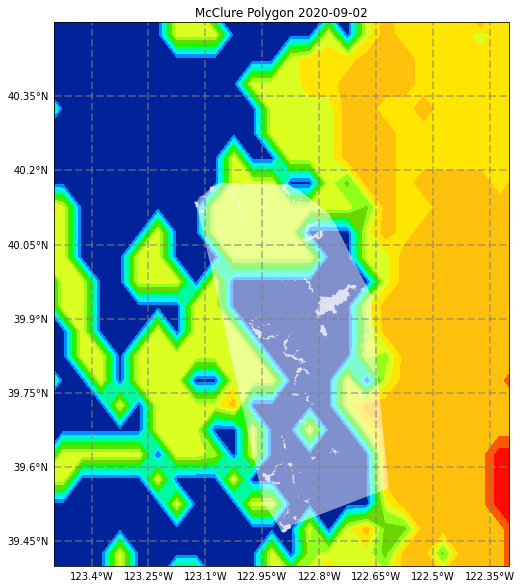

16
16 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


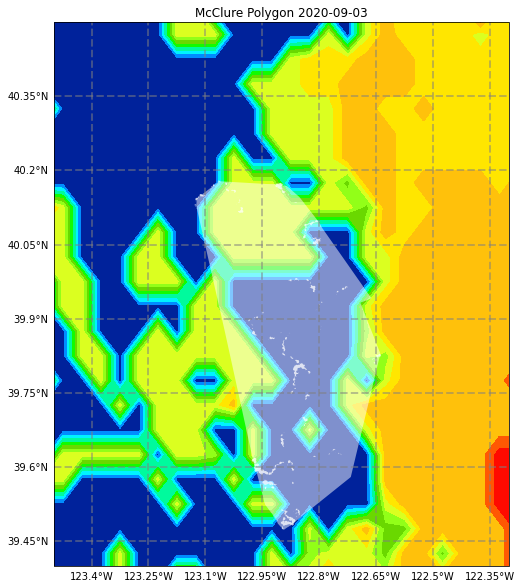

17
17 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


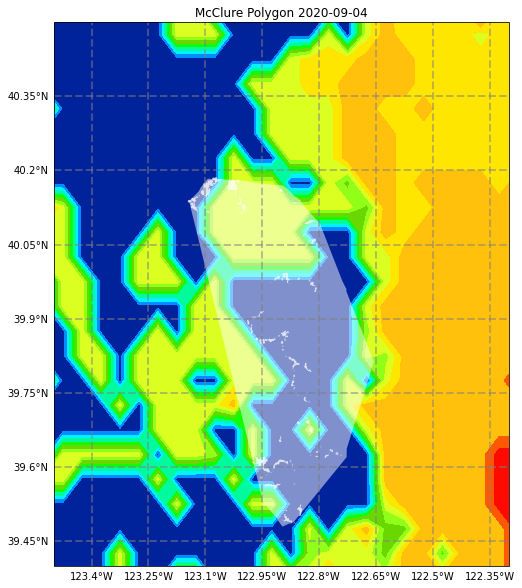

18
18 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


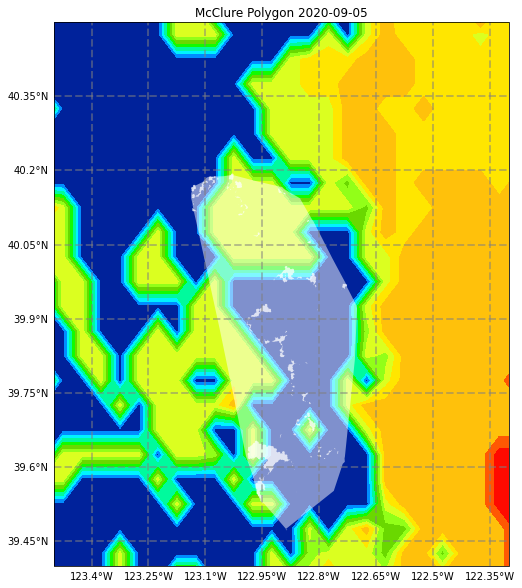

19
19 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


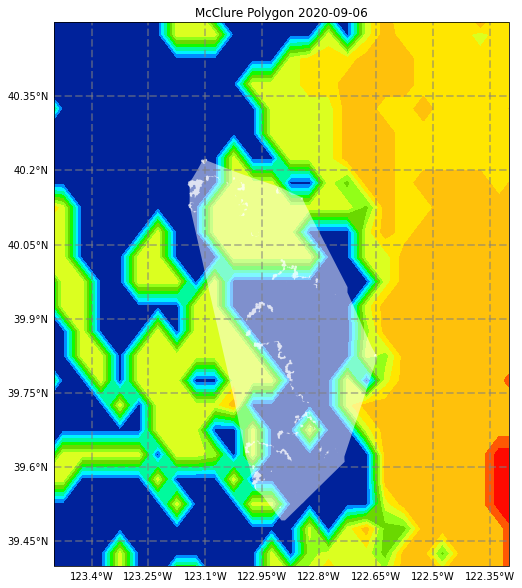

20
20 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


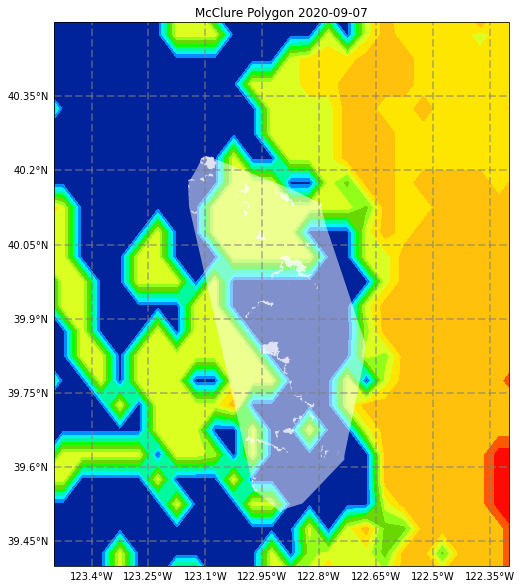

21
21 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


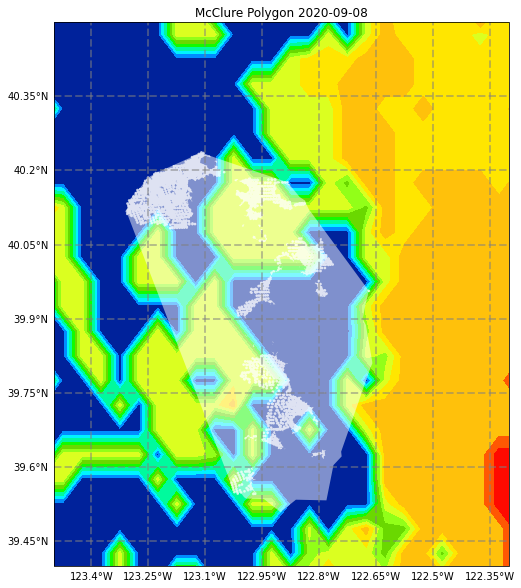

22
22 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


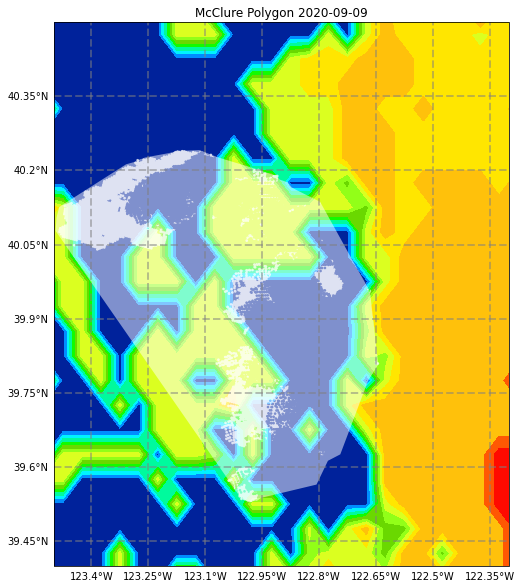

23
23 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


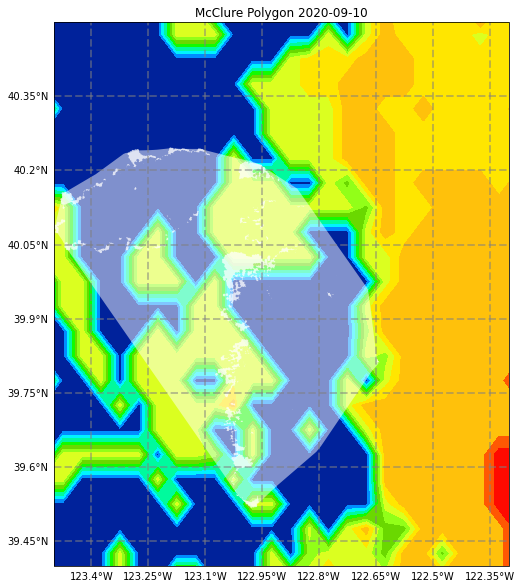

24
24 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


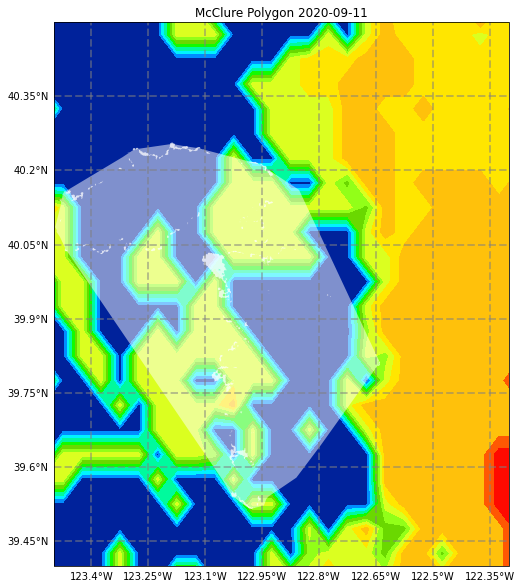

25
25 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


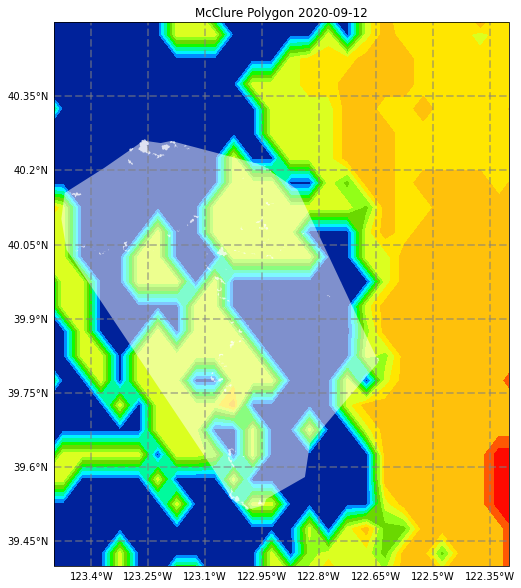

26
26 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


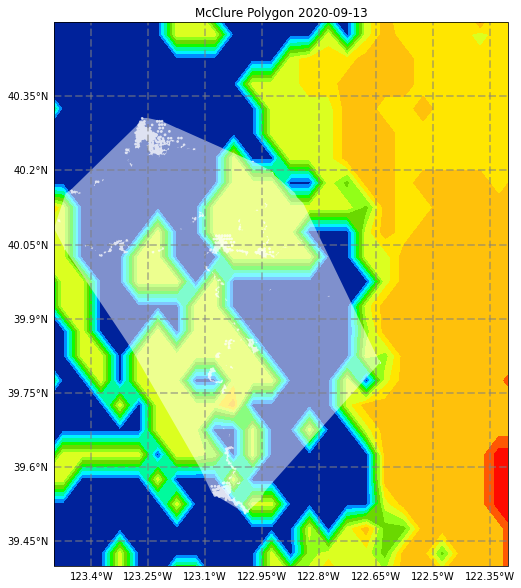

27
27 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


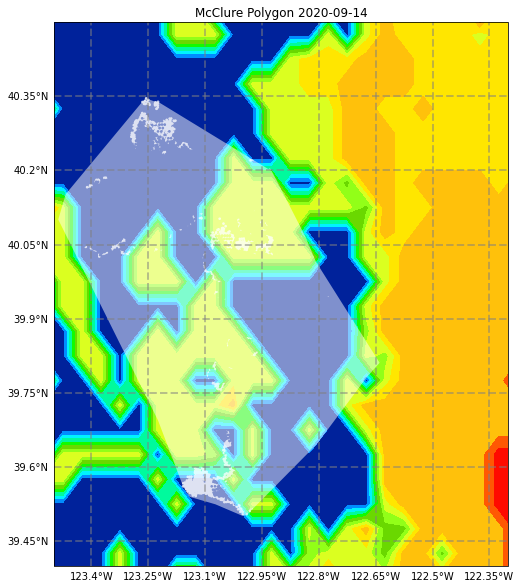

28
28 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


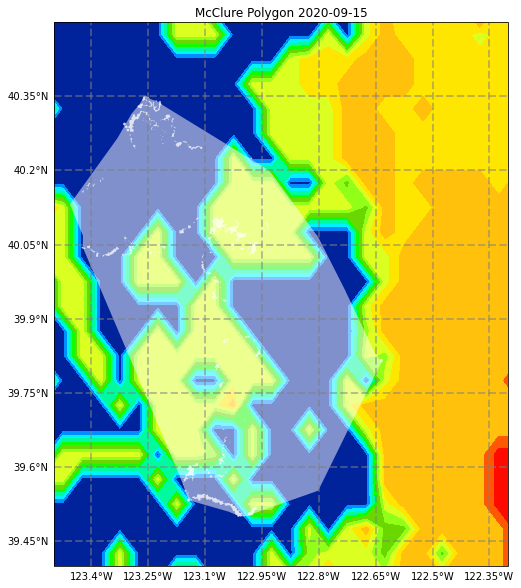

29
29 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


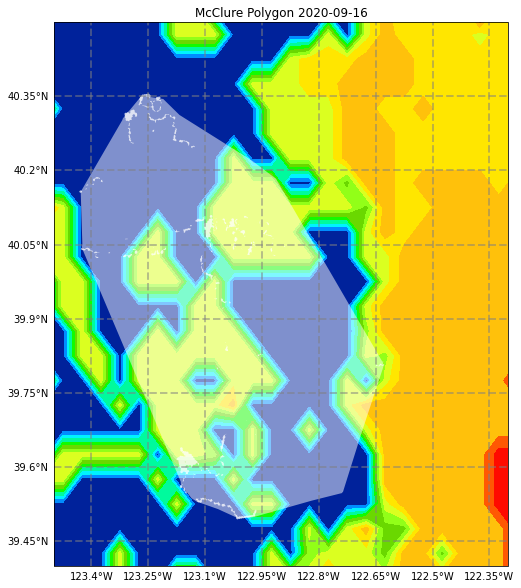

30
30 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


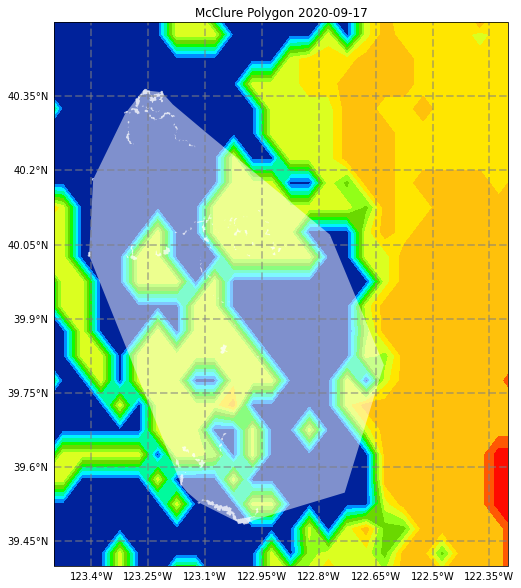

31
31 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


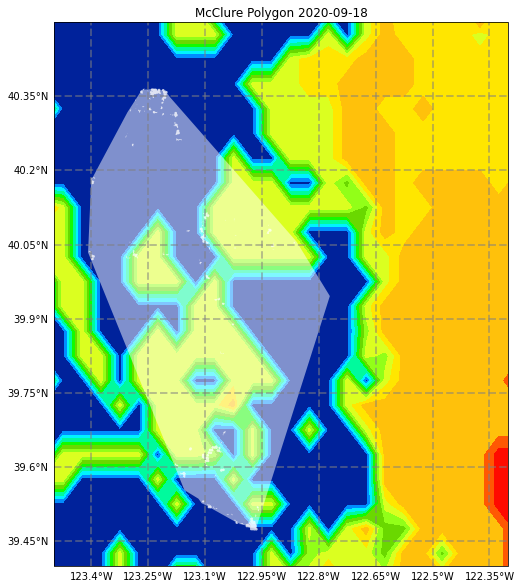

32
32 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


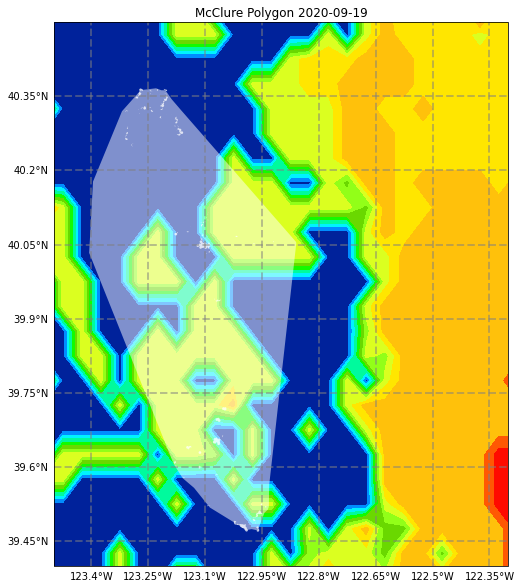

33
33 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


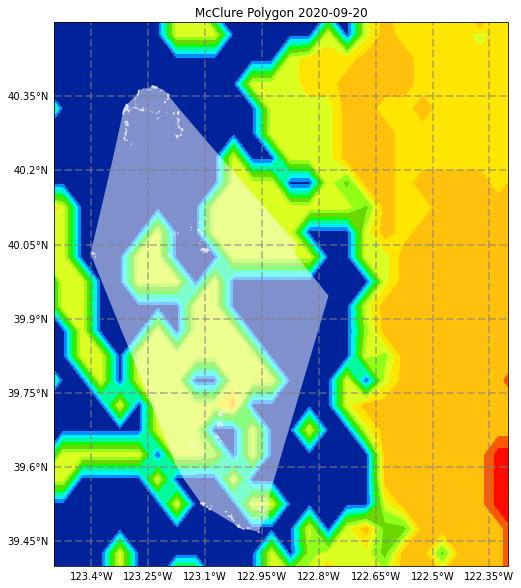

34
34 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


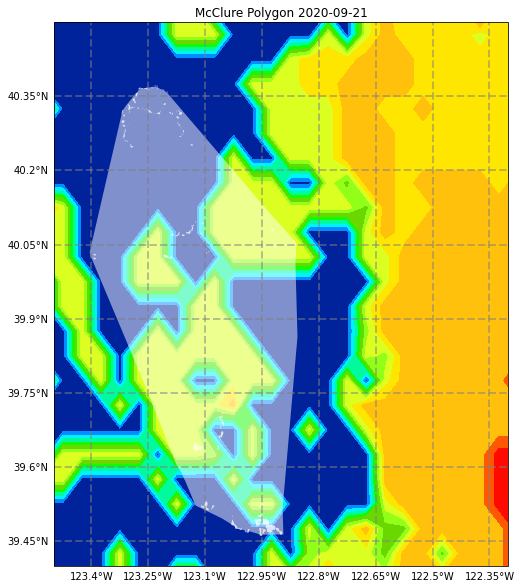

35
35 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


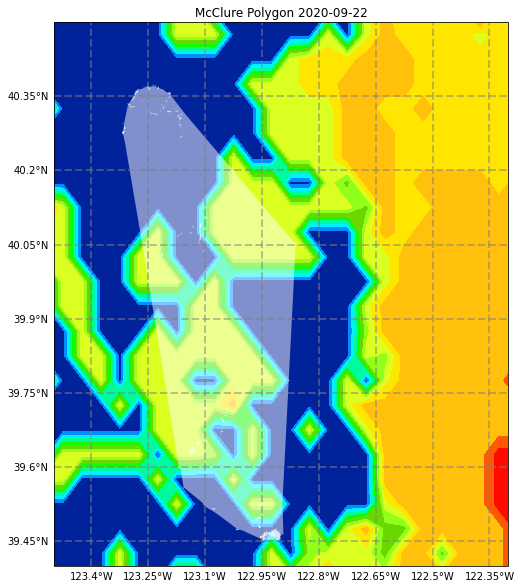

36
36 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


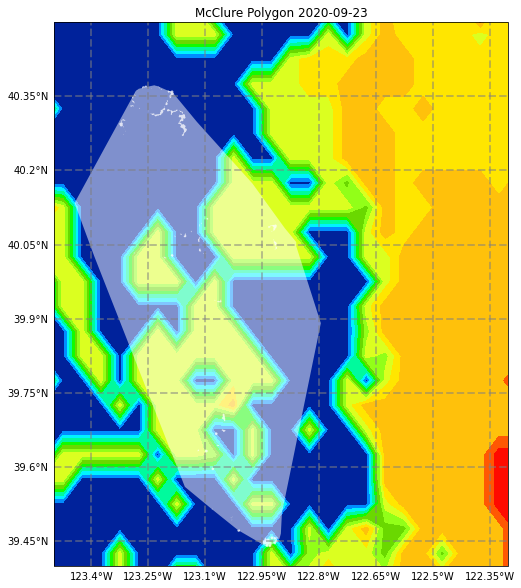

37
37 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


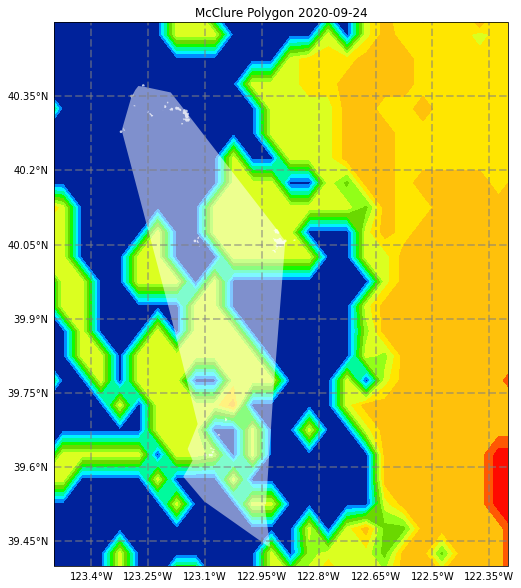

38
38 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


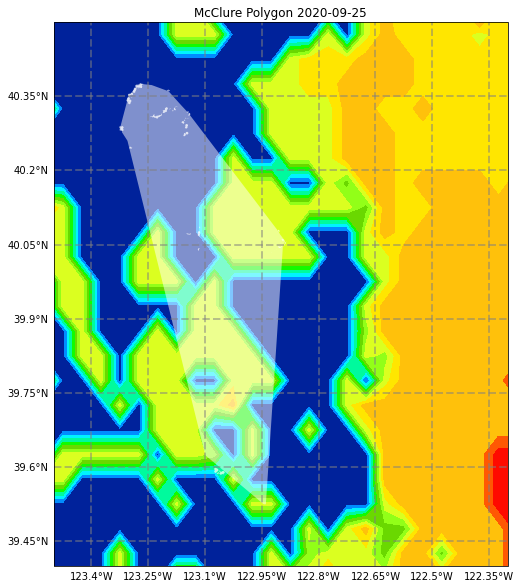

39
39 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


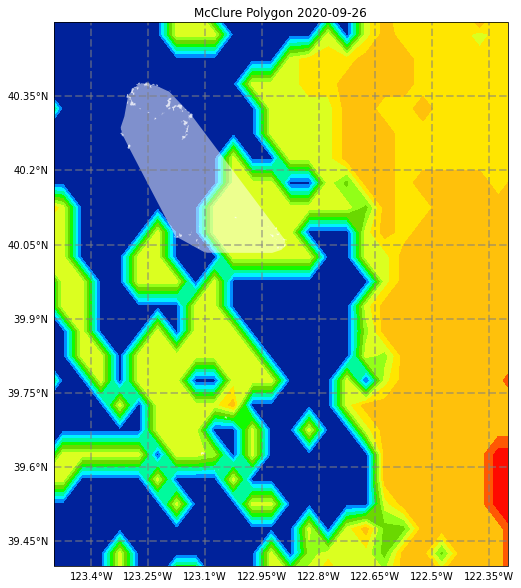

40
40 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


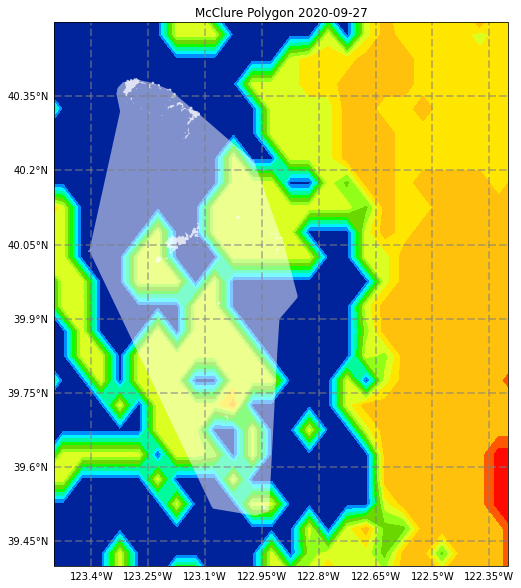

41
41 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


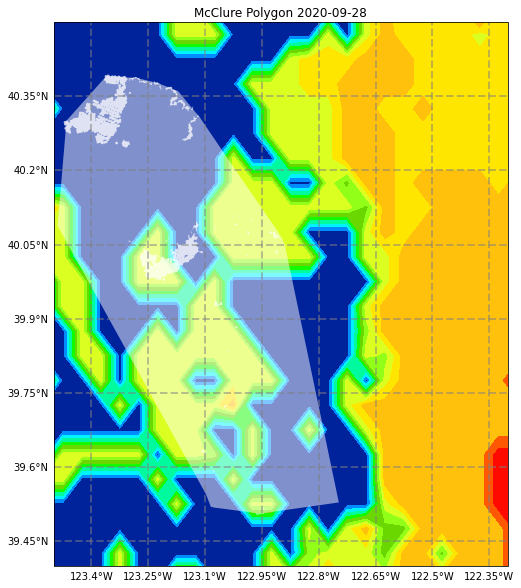

42
42 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


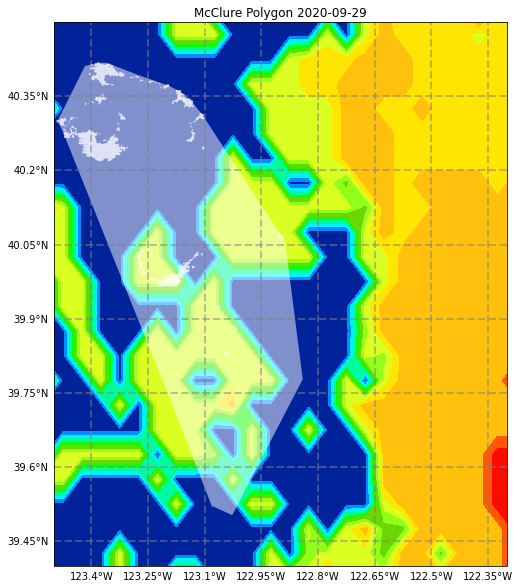

43
43 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


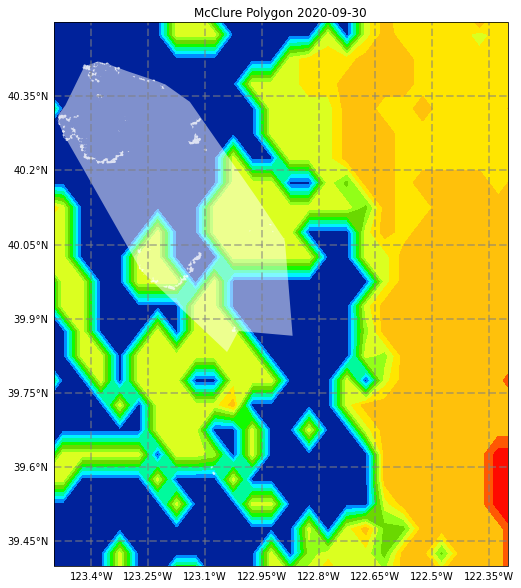

44
44 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


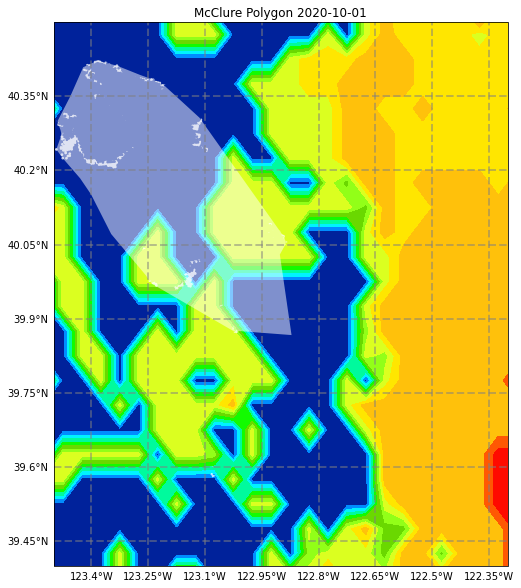

45
45 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


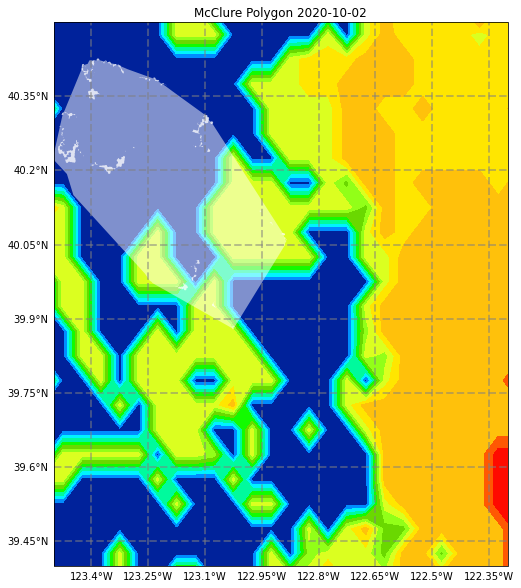

46
46 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


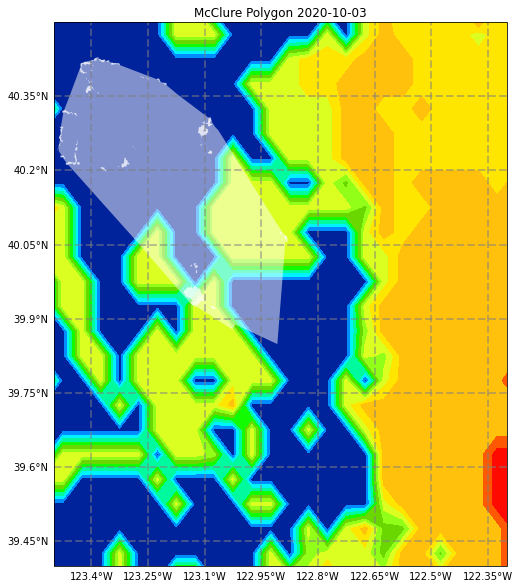

47
47 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


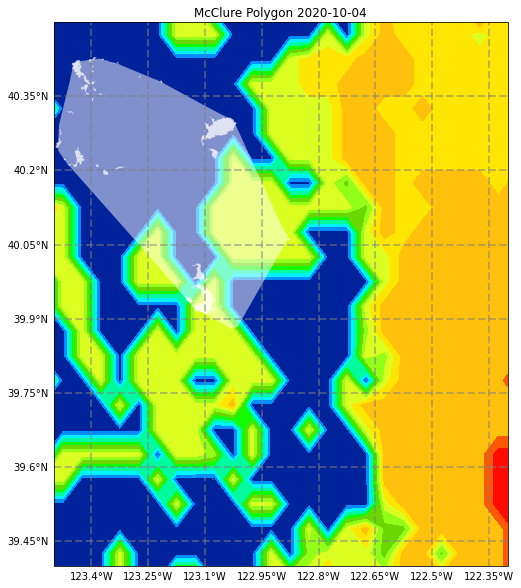

48
48 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


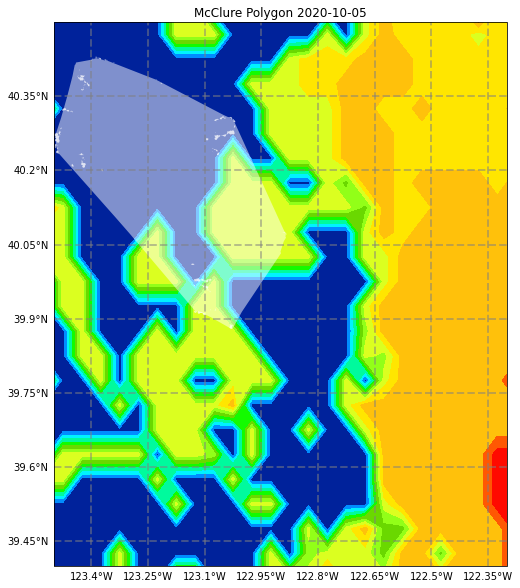

49
49 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


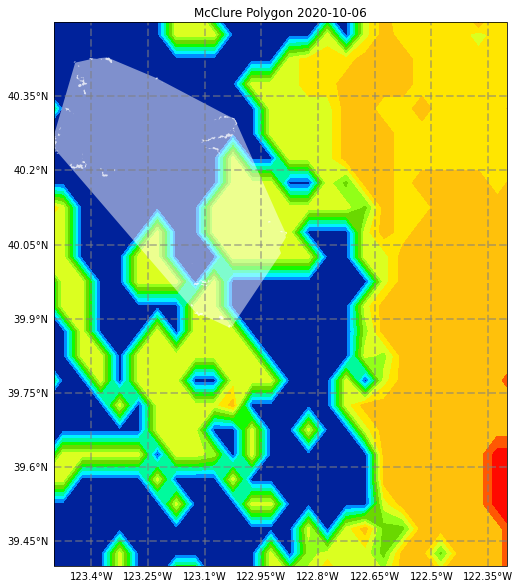

50
50 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


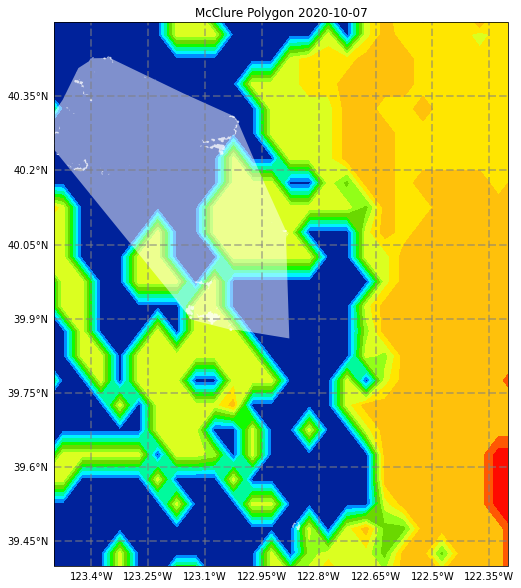

51
51 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


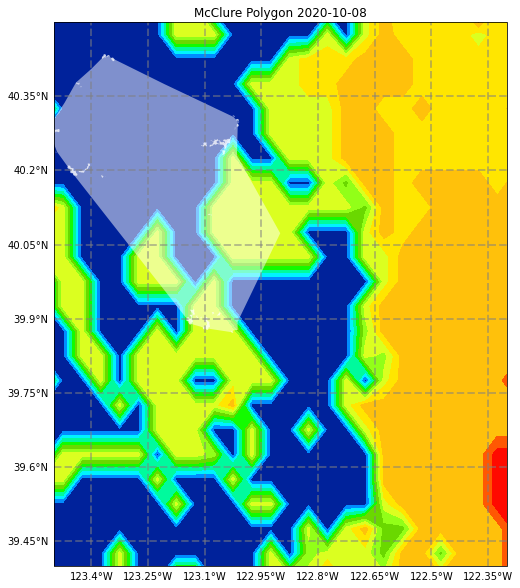

52
52 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


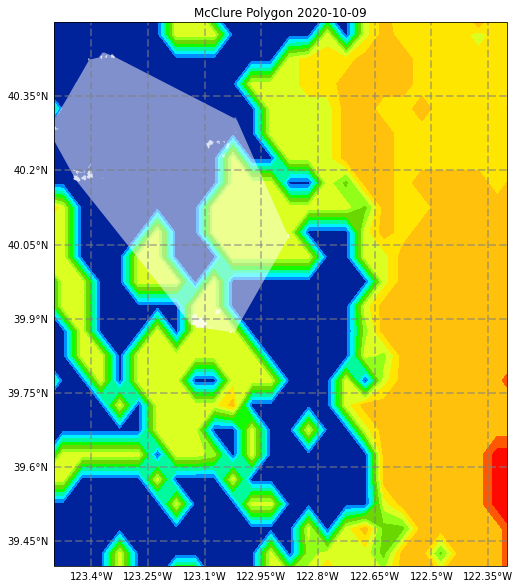

53
53 No mcclure poly
54
54 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


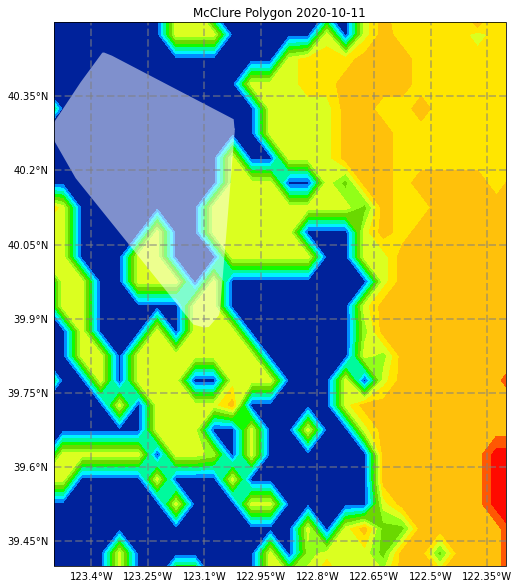

55
55 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


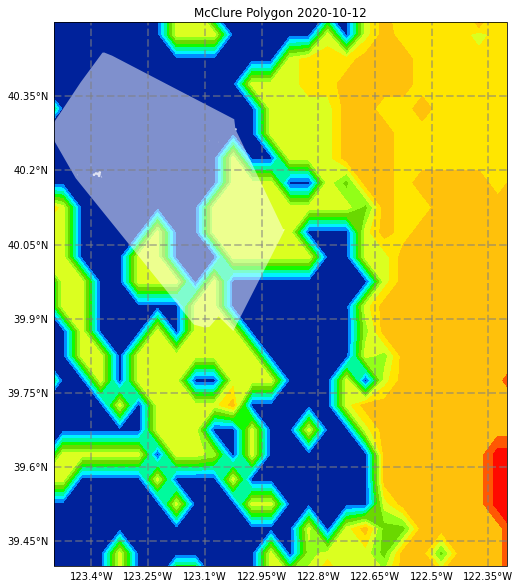

56
56 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


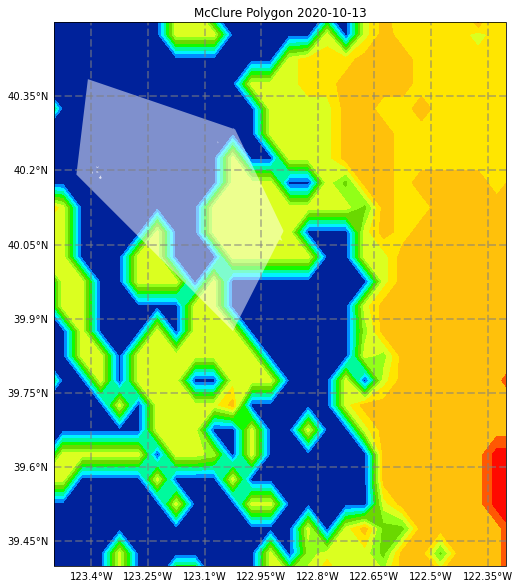

57
57 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


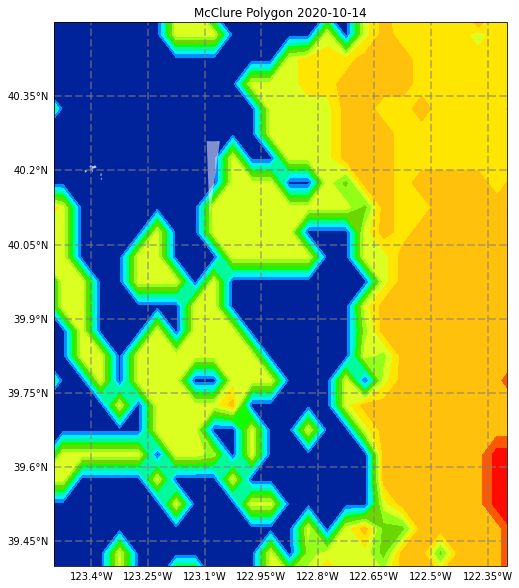

58
58 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


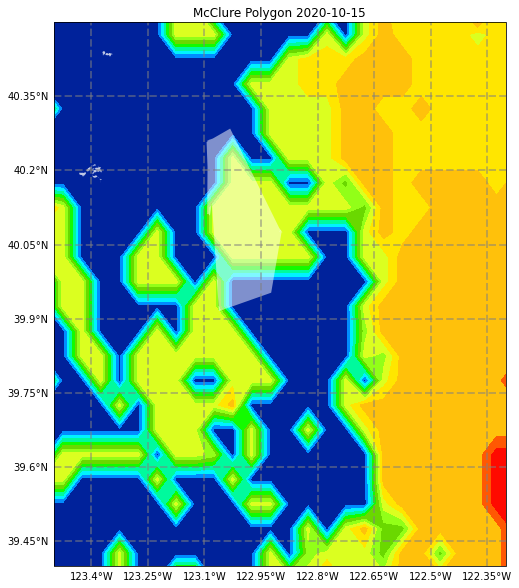

59
59 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


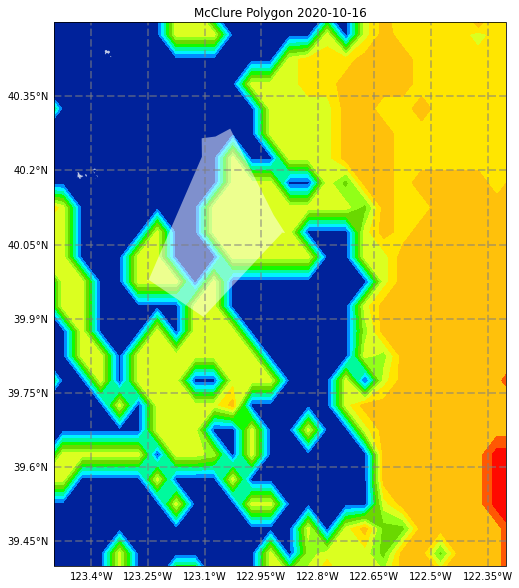

60
60 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


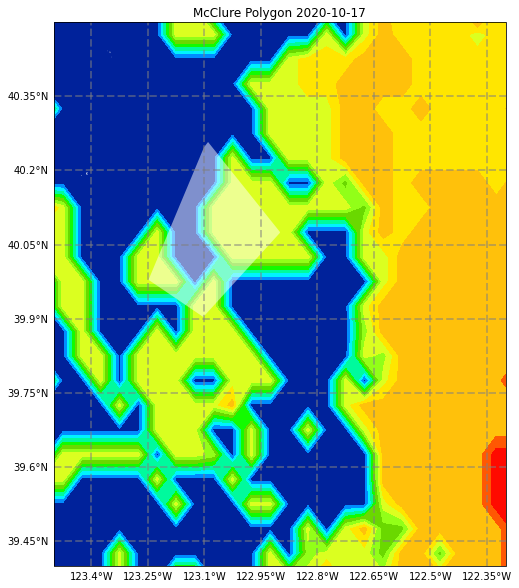

61
61 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


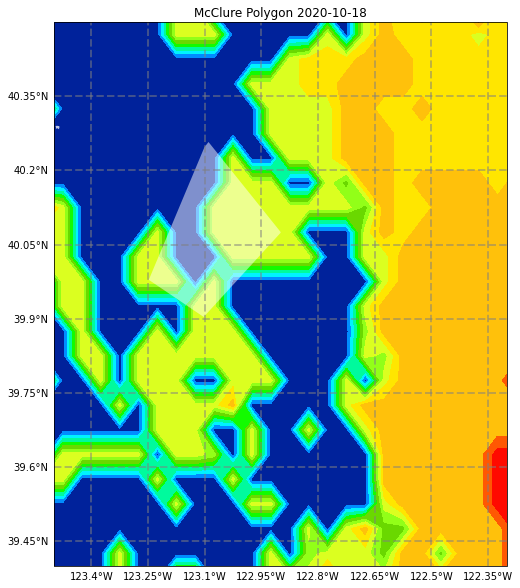

62
62 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


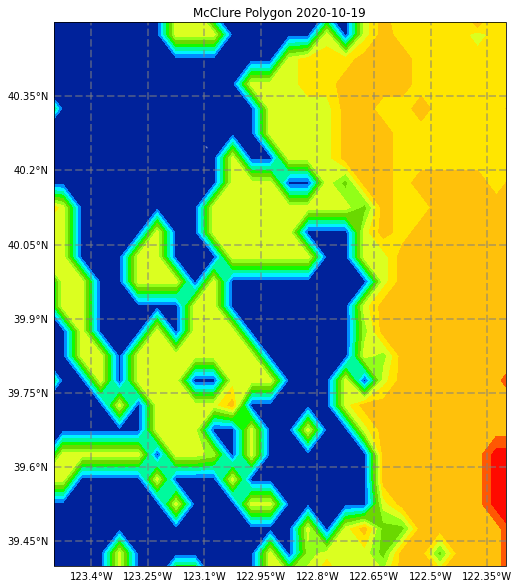

63
63 No mcclure poly
64
64 No mcclure poly
65
65 No mcclure poly
66
66 No mcclure poly
67
67 No mcclure poly
68
68 No mcclure poly
69
69 No mcclure poly
70
70 No mcclure poly
71
71 both polys
[-0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5
 13.5 14.5 15.5 16.5]


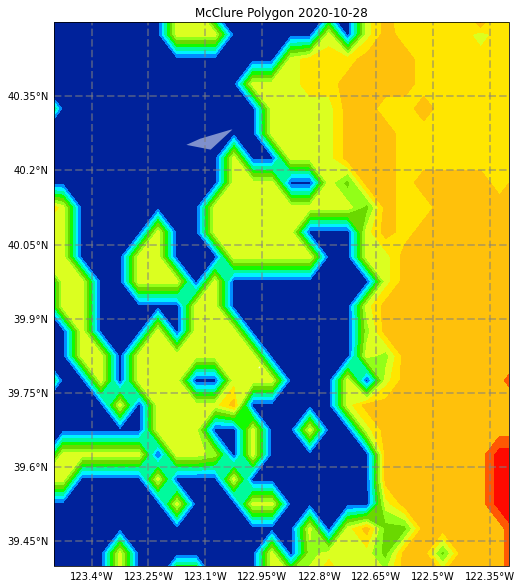

Unnamed: 0  % water  % evergreen needleleaf forest  \
0            0      0.0                      59.772727   
1            1      0.0                      37.486486   
2            2      0.0                      40.624204   
3            3      0.0                      41.901515   
4            4      0.0                      43.896825   
..         ...      ...                            ...   
67          67      0.0                      97.000000   
68          68      0.0                      97.000000   
69          69      0.0                      97.000000   
70          70      0.0                      97.000000   
71          71      0.0                      95.000000   

    % evergreen broadleaf forest  % deciduous needleleaf forest  \
0                            0.0                            0.0   
1                            0.0                            0.0   
2                            0.0                            0.0   
3                            0.0                            0.0   
4                            0.0                            0.0   
..                           ...                            ...   
67                           0.0                            0.0   
68                           0.0                            0.0   
69                           0.0                            0.0   
70                           0.0                            0.0   
71                           0.0                            0.0   

    % deciduous broadleaf forest  % mixed forests  % closed shrubland  \
0                       0.000000         0.181818            0.454545   
1                       0.020270         0.054054            2.081081   
2                       0.019108         0.050955            2.019108   
3                       0.022727         0.060606            2.121212   
4                       0.023810         0.063492            2.214286   
..                           ...              ...                 ...   
67                      0.000000         0.000000            0.000000   
68                      0.000000         0.000000            0.000000   
69                      0.000000         0.000000            0.000000   
70                      0.000000         0.000000            0.000000   
71                      0.000000         0.000000            0.000000   

    % open shrublands  % woody savannas  % savannas  % grasslands  \
0            2.545455         24.136364    2.045455     10.863636   
1            3.270270         29.290541    2.364865     25.391892   
2            3.477707         34.070064    3.261146     16.401274   
3            3.037879         33.143939    2.757576     16.924242   
4            2.793651         34.666667    3.841270     12.468254   
..                ...               ...         ...           ...   
67           0.000000          3.000000    0.000000      0.000000   
68           0.000000          3.000000    0.000000      0.000000   
69           0.000000          3.000000    0.000000      0.000000   
70           0.000000          3.000000    0.000000      0.000000   
71           0.000000          5.000000    0.000000      0.000000   

    % permanent wetlands  % croplands  % urban and built-up  \
0               0.000000     0.000000              0.000000   
1               0.027027     0.000000              0.013514   
2               0.025478     0.044586              0.006369   
3               0.030303     0.000000              0.000000   
4               0.031746     0.000000              0.000000   
..                   ...          ...                   ...   
67              0.000000     0.000000              0.000000   
68              0.000000     0.000000              0.000000   
69              0.000000     0.000000              0.000000   
70              0.000000     0.000000              0.000000   
71              0.000000     0.000000              0.000000   

    % cropland/natural vegetation mosai

In [92]:
#NCAR Moisture Time Series

dat = nc.Dataset('/data2/lthapa/static_maps/MODIS_IGBP_2020.nc')
lat_center = dat['lat'][:]
lon_center = dat['lon'][:]
lc_majority= dat['lc_majority'][:]
lc_percent = dat['lc_percent'][:]
print(lc_percent.shape)

lat_inds = np.where((lat_center[:,0]>=31)& (lat_center[:,0]<=51))[0]
lat_start = lat_inds[0]
lat_end = lat_inds[len(lat_inds)-1]
lon_inds = np.where((lon_center[0,:]>=-126)& (lon_center[0,:]<=-101))[0]
lon_start = lon_inds[0]
lon_end = lon_inds[len(lon_inds)-1]

lat_corners, lon_corners = calculate_grid_cell_corners(lat_center, lon_center)

for ii in range(len(times)):
    print(ii)
    
    #does a polygon exist for this time?
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')

    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        
        fig = plt.figure(figsize=(15,10))
        ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_extent([-123.5, -122.3, 39.4, 40.5])
        ax.coastlines()
        ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        levels = np.arange(-0.5,17.5,1) #need to specify levels for the contours
        print(levels)
        fuelmap = plt.contourf(lon_center[lat_start:lat_end, lon_start:lon_end],\
            lat_center[lat_start:lat_end, lon_start:lon_end],\
           lc_majority[lat_start:lat_end, lon_start:lon_end],\
            levels=levels,cmap='gist_ncar')
        gpd.GeoSeries(poly_mcclure).plot(ax=ax, color='w', alpha=0.75)
        plt.title('McClure Polygon '+ str(times[ii]))
        plt.show()

    else:
        print(ii, 'both polys')
        
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        fig = plt.figure(figsize=(15,10))
        ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_extent([-123.5, -122.3, 39.4, 40.5])
        ax.coastlines()
        ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        levels = np.arange(-0.5,17.5,1) #need to specify levels for the contours
        print(levels)
        fuelmap = plt.contourf(lon_center[lat_start:lat_end, lon_start:lon_end],\
            lat_center[lat_start:lat_end, lon_start:lon_end],\
           lc_majority[lat_start:lat_end, lon_start:lon_end],\
            levels=levels,cmap='gist_ncar')
        
        gpd.GeoSeries(poly_thapa).plot(ax=ax, color='w', alpha=0.5)
        gpd.GeoSeries(poly_mcclure).plot(ax=ax, color='w', alpha=0.75)
        plt.title('McClure Polygon '+ str(times[ii]))
        plt.show()

            
df_igbp_thapa

## Resources time series

In [ ]:
print(type(times))

resources = pd.read_excel('Query2.xlsx')
resources_people = resources.drop(columns=['RESTYP_IDENTIFIER', 'RESOURCE_QUANTITY', 'CODE_NAME', 'INC209R_IDENTIFIER'])
#resources_people = resources_people.groupby(['INC209R_IDENTIFIER']).sum()
resources_people

In [ ]:
ac_inds = np.where(resources_people['INC_IDENTIFIER']==11843929)[0] #pull out august complex

resources_people_ac = resources_people.iloc[ac_inds]

#get the days (in UTC) that the 209 reports are valid for
resources_dates = pd.to_datetime(resources_people_ac['REPORT_FROM_DATE']) + datetime.timedelta(hours=7)
#resources_dates
resources_days = [resources_dates.iloc[i].strftime("%Y-%m-%d") for i in range(len(resources_dates))]
resources_people_ac['DateTim'] = resources_days


In [ ]:
#sum up the personnel assigned to the fire each day
daily_sum_people = resources_people_ac.groupby('DateTim').sum()
daily_sum_people.iloc[1:73]


personnel = daily_sum_people['RESOURCE_PERSONNEL'].iloc[1:73].values #hard coded the indices that match the polygon times
print(len(personnel))

In [ ]:
fig, ax = plt.subplots(figsize=(20,8)) #set up the figure

daily_sum_people.plot(y='RESOURCE_PERSONNEL', ax=ax)
plt.title('Total Daily Personnel')
plt.show()

In [ ]:
people=np.zeros((1, len(times)))
for ii in range(len(times)):
    print(times[ii])
    print(str(resources_people_ac['DateTim'])[0:10])
    #print(np.where(resources_people_ac['DateTim']==time))

## Put everything into a dataframe (created 4/11/2022)

In [ ]:
# load in the fuel moisture info, extract living and dead

df_moisture = pd.read_csv('Moisture_Info_August_Complex.csv')
df_cod = pd.read_csv()
dict_thapa = {'time':times,'temp':temp[1,:], 'vpd':vpd[1,:], 'wind':wind[1,:], 'personnel':personnel,\
              'dead_moisture':df_moisture['Dead Thapa'], 'living moisture':df_moisture['Live Thapa'],\
              'cod': cod_out[1,:],'frp':frp[1,:], 'num_points':num_points[1,:]}
df_thapa = pd.concat([pd.DataFrame(dict_thapa), df_gbbepx_thapa], axis=1)

dict_mcclure = {'time':times,'temp':temp[0,:], 'vpd':vpd[0,:], 'wind':wind[0,:], 'personnel':personnel,\
              'dead_moisture':df_moisture['Dead McClure'], 'living moisture':df_moisture['Live McClure'],\
              'cod': cod_out[0,:],'frp':frp[0,:], 'num_points':num_points[0,:]}
df_mcclure = pd.concat([pd.DataFrame(dict_mcclure), df_gbbepx_mcclure], axis=1)


#save dataframes
df_thapa.to_csv('AC_Thapa.csv')
df_mcclure.to_csv('AC_McClure.csv')

In [ ]:
df_thapa = pd.read_csv('AC_Thapa.csv')
print(df_thapa.columns)
df_thapa['PM2.5 QFED Rate'] = pm25_daily_rate[1,:]
df_thapa['PM2.5 QFED Total'] = pm25_daily_total[1,:]
df_thapa['PM2.5'] = df_gbbepx_thapa['PM2.5']
print(df_thapa.columns)

df_thapa.to_csv('AC_Thapa.csv')


df_mcclure = pd.read_csv('AC_McClure.csv')
print(df_mcclure.columns)
df_mcclure['PM2.5 QFED Rate'] = pm25_daily_rate[0,:]
df_mcclure['PM2.5 QFED Total'] = pm25_daily_total[0,:]
df_mcclure['PM2.5'] = df_gbbepx_mcclure['PM2.5']
print(df_mcclure.columns)
df_mcclure.to_csv('AC_McClure.csv')


## plot time series

In [ ]:
#compare temperature for the two polygon methods
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, temp[0,:], 'ro-')
ax.plot(times, temp[1,:], 'bo-')
ax.set_ylabel('Temperature', fontsize=24, color='blue')
plt.legend({'McClure Polygons', 'Thapa Polygons'},fontsize=24)
plt.title('AUG COMPLEX MAX DAILY TEMPERATURE',fontsize=24)
plt.grid()
plt.show()

In [ ]:
#compare VPD for the two polygon methods
#compare temperature for the two polygon methods
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, vpd[0,:], 'ro-')
ax.plot(times, vpd[1,:], 'bo-')
ax.set_ylabel('Temperature', fontsize=24, color='blue')
plt.legend({'McClure Polygons', 'Thapa Polygons'},fontsize=24)
plt.title('AUG COMPLEX MAX VPD',fontsize=24)
plt.grid()
plt.show()

In [ ]:
#compare FRP for the two polygon methods
#compare temperature for the two polygon methods
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, frp[1,:], 'ro-')
ax.plot(times, frp[0,:], 'bo-')
ax.set_ylabel('FRP', fontsize=24, color='blue')
plt.legend({'McClure Polygons', 'Thapa Polygons'},fontsize=24)
plt.title('AUG COMPLEX FRP',fontsize=24)
plt.grid()
plt.show()

In [ ]:
#compare number of detects/pixels for the two polygon methods
#compare temperature for the two polygon methods
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, num_points[1,:], 'ro-')
ax.plot(times, num_points[0,:], 'bo-')
ax.set_ylabel('Number of points/pixels', fontsize=24, color='blue')
plt.legend({'McClure Polygons pixels', 'Thapa Polygons num points'},fontsize=24)
plt.title('AUG COMPLEX Number Pixels',fontsize=24)
plt.grid()
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, vpd[1,:], 'ro-')
ax.set_ylabel('Daily Max Vapor Pressure Deficit', fontsize=24, color='red')
plt.grid()
ax2=ax.twinx()
ax2.plot(times, num_points[1,:], 'bo-')
ax2.set_ylabel('Number of VIIRS Detects', fontsize=24, color='blue')
plt.title('AUG COMPLEX Laura Polygons', fontsize=24)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, temp[1,:], 'ro-')
ax.set_ylabel('Daily Max Temperature', fontsize=24, color='red')
plt.grid()
ax2=ax.twinx()
ax2.plot(times, num_points[1,:], 'bo-')
ax2.set_ylabel('Number of VIIRS Detects', fontsize=24, color='blue')
plt.title('AUG COMPLEX Laura Polygons', fontsize=24)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, temp[0,:], 'ro-')
ax.set_ylabel('Daily Max Temperature', fontsize=24, color='red')
plt.grid()
ax2=ax.twinx()
ax2.plot(times, frp[0,:], 'bo-')
ax2.set_ylabel('FRP', fontsize=24, color='blue')
plt.title('AUG COMPLEX Crystal Polygons', fontsize=24)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
ax.plot(times, vpd[0,:], 'ro-')
ax.set_ylabel('Daily Max Vapor Pressure Deficit', fontsize=24, color='red')
plt.grid()
ax2=ax.twinx()
ax2.plot(times, frp[0,:], 'bo-')
ax2.set_ylabel('FRP', fontsize=24, color='blue')
plt.title('AUG COMPLEX Crystal Polygons', fontsize=24)
plt.show()

## time series plots with function (3/31/2022)

In [ ]:
plot_twoline(times, num_points, 'August Complex Daily Fire Counts', ['McClure', 'Thapa'], '#', 0)
plot_twoline(times, frp, 'August Complex Daily Mean FRP', ['McClure', 'Thapa'], 'MW', 0)

plot_twoline(times, wind, 'August Complex Daily Max WindSpeed', ['McClure', 'Thapa'], 'm/s', 0)
plot_twoline(times, temp, 'August Complex Daily Max Temp', ['McClure', 'Thapa'], 'K', 0)
plot_twoline(times, vpd, 'August Complex Daily Max VPD', ['McClure', 'Thapa'], 'Pa', 0)


In [ ]:
plot_twoline(times, np.stack([temp[0,:], frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Max Temperature (K)', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([vpd[0,:], frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Max VPD (Pa)', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([wind[0,:], frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Max Wind (m/s)', 'FRP (MW)'], 1)

plot_twoline(times, np.stack([temp[1,:], frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Max Temperature (K)', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([vpd[1,:], frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Max VPD (Pa)', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([wind[1,:], frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Max Wind (m/s)', 'FRP (MW)'], 1)

plot_twoline(times, np.stack([temp[0,:], num_points[0,:]]), 'August Complex McClure Polygons',\
             [], ['Max Temperature (K)', 'Num Pixels'], 1)
plot_twoline(times, np.stack([vpd[0,:], num_points[0,:]]), 'August Complex McClure Polygons',\
             [], ['Max VPD (Pa)', 'Num Pixels'], 1)
plot_twoline(times, np.stack([wind[0,:], num_points[0,:]]), 'August Complex McClure Polygons',\
             [], ['Max Wind (m/s)', 'Num Pixels'], 1)

plot_twoline(times, np.stack([temp[1,:], num_points[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Max Temperature (K)', 'Num Detections'], 1)
plot_twoline(times, np.stack([vpd[1,:], num_points[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Max VPD (hPa)', 'Num Detections'], 1)
plot_twoline(times, np.stack([wind[1,:], num_points[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Max Wind (m/s)', 'Num Detections'], 1)



In [ ]:
#personnel comparison
plot_twoline(times, np.stack([personnel, frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Number of People', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([personnel, frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Number of People', 'FRP (MW)'], 1)

plot_twoline(times, np.stack([personnel, num_points[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Number of People', 'Fire Counts (#)'], 1)
plot_twoline(times, np.stack([personnel, num_points[0,:]]), 'August Complex McClure Polygons',\
             [], ['Number of People', 'Fire Counts (#)'], 1)

In [ ]:
# FCCS comparison
df_fuels = pd.read_csv('Fuels_Info_August_Complex.csv')
print(df_fuels)

plot_twoline(times, np.stack([df_fuels['fuels_thapa'].values, frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Slopes', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([df_fuels['fuels_mcclure'].values, frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Slopes', 'FRP (MW)'], 1)

In [ ]:
print(df_gbbepx_thapa['CO'].values.shape)

In [ ]:
# GBBEPx Comparison
plot_twoline(times, np.stack([df_gbbepx_thapa['CO'].values, frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['CO Mean Emissions (kg)', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([df_gbbepx_mcclure['CO'].values, frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['CO Mean Emissions (kg)', 'FRP (MW)'], 1)

plot_twoline(times, np.stack([carbon_monoxide[1,:], frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['CO Mean Emissions (kg/m2/s)', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([carbon_monoxide[0,:], frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['CO Mean Emissions (kg/m2/s)', 'FRP (MW)'], 1)

In [ ]:
#fuel moisture

plot_twoline(times, np.stack([mdead[1,:], frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Dead Fuel Moisture', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([mdead[0,:], frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Dead Fuel Moisture', 'FRP (MW)'], 1)

plot_twoline(times, np.stack([mlive[1,:], frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Live Fuel Moisture', 'FRP (MW)'], 1)
plot_twoline(times, np.stack([mlive[0,:], frp[0,:]]), 'August Complex McClure Polygons',\
             [], ['Live Fuel Moisture', 'FRP (MW)'], 1)

In [ ]:
# vpd and fuel moisture
plot_twoline(times, np.stack([mdead[1,:], vpd[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Dead Fuel Moisture', 'VPD (Pa)'], 1)
df_test_qfed = pd.DataFrame({'mdead':mdead[1,:], 'VPD':vpd[1,:]})
print(df_test_qfed.corr())

#fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
#plt.scatter(vpd[1,:], mdead[1,:])
#ax.set_xlabel('VPD (Pa)', fontsize=24) 
#ax.set_ylabel('Dead Fuel Moisture', fontsize=24) 
#plt.show()


In [ ]:
# shifting to deal with when we have nans in the cross correlation

n_shift = 0
vpd_shifted = np.concatenate([np.nan*np.zeros(n_shift), vpd[1,0:len(vpd[1,:])-(n_shift)]])
#print(vpd[1,:], vpd_shifted)
#print(len(vpd[1,:]), len(vpd_shifted))

df_test_qfed = pd.DataFrame({'mdead':mdead[1,:], 'VPD':vpd_shifted})
print(df_test_qfed.corr())

plot_twoline(times, np.stack([mdead[1,:], -vpd_shifted]), 'August Complex Thapa Polygons',\
             [], ['Dead Fuel Moisture', 'Nagative VPD (Pa)'], 1)


fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
plt.scatter(vpd_shifted[np.where(frp[1,:]<6000)],mdead[1,np.where(frp[1,:]<6000)], c=frp[1,np.where(frp[1,:]<6000)], cmap='OrRd')
plt.colorbar()
ax.set_xlabel('VPD (Pa)', fontsize=24) 
ax.set_ylabel('Dead Fuel Moisture', fontsize=24) 
plt.show()

## Time Series plots to check QFED (4/12/2022)

In [ ]:
# compare daily qfed rates and totals with GBBEPx

df_thapa = pd.read_csv('AC_Thapa.csv')
print(df_thapa.columns)

print(df_thapa[['PM2.5 QFED Rate', 'frp']].corr())
plot_twoline(times, np.stack([df_thapa['PM2.5 QFED Rate'].values, df_thapa['frp'].values ]),\
             'August Complex Thapa Polygons',\
             [], ['QFED PM2.5 Emission Rate (kg/m2/s)', 'VIIRS FRP (MW)'], 1)
print(df_thapa[['PM2.5 QFED Total', 'frp']].corr())
plot_twoline(times, np.stack([df_thapa['PM2.5 QFED Total'].values, df_thapa['frp'].values ]),\
             'August Complex Thapa Polygons',\
             [], ['QFED PM2.5 Daily Total (kg)', 'VIIRS FRP (MW)'], 1)
print(df_thapa[['PM2.5', 'frp']].corr())
plot_twoline(times, np.stack([df_thapa['PM2.5'].values, df_thapa['frp'].values ]),\
             'August Complex Thapa Polygons',\
             [], ['GBBEPx PM2.5 Daily Total (kg)', 'VIIRS FRP (MW)'], 1)

In [ ]:
# see if qfed persistence goes with cloud optical depth
print(df_thapa.columns)
print(df_thapa[['PM2.5 QFED Rate', 'cod']].corr())
plot_twoline(times, np.stack([df_thapa['PM2.5 QFED Rate'].values, df_thapa['cod'].values ]),\
             'August Complex Thapa Polygons',\
             [], ['QFED PM2.5 Emission Rate (kg/m2/s)', 'Cloud Optical Depth'], 1)

window_size = 10
cod_series = df_thapa['cod']
pm25_series = df_thapa['PM2.5 QFED Rate']
cod_windows = cod_series.rolling(window_size)
pm25_windows = pm25_series.rolling(window_size)

cod_averages=cod_windows.mean()
pm25_std = pm25_windows.std()

df_test = pd.DataFrame({'PM2.5 QFED Rate':pm25_std, '3day Cod':cod_averages})
print(df_test.corr())
plot_twoline(times, np.stack([pm25_std.values, cod_averages.values ]),\
             'August Complex Thapa Polygons',\
             [], ['QFED PM2.5 Emission Rate (kg/m2/s)', 'Cloud Optical Depth '+str(window_size)+ 'day average'], 1)


## Time Series Plots IGBP

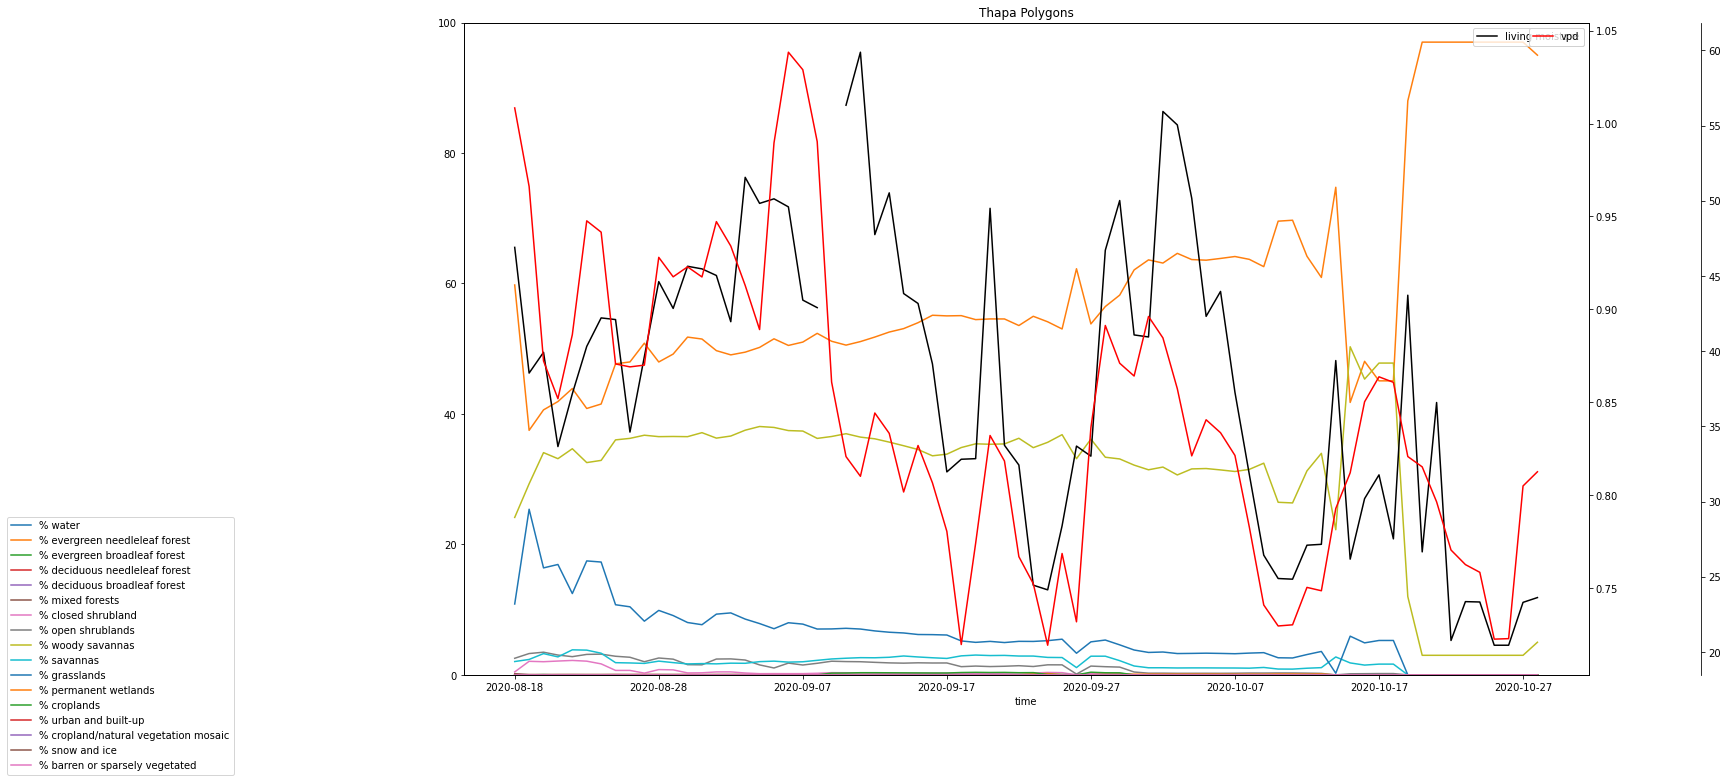

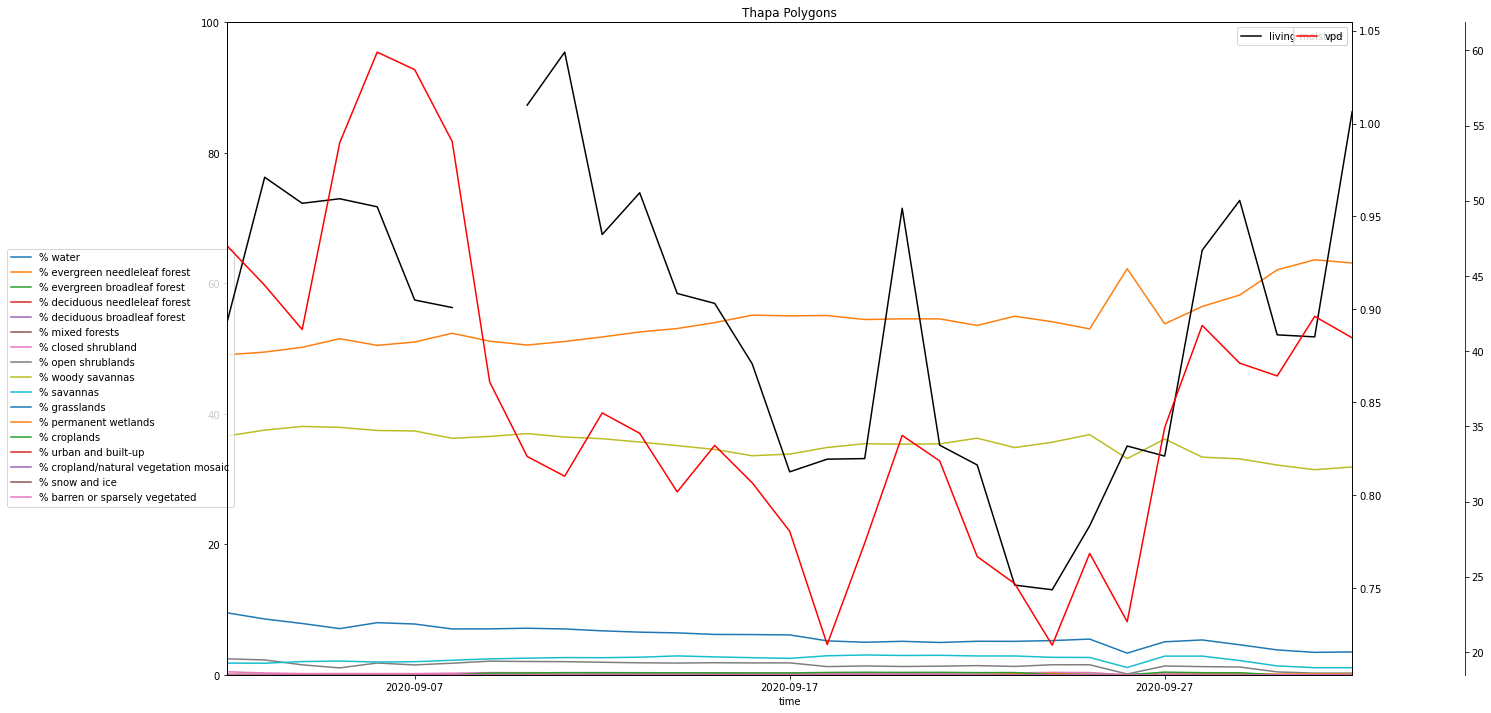

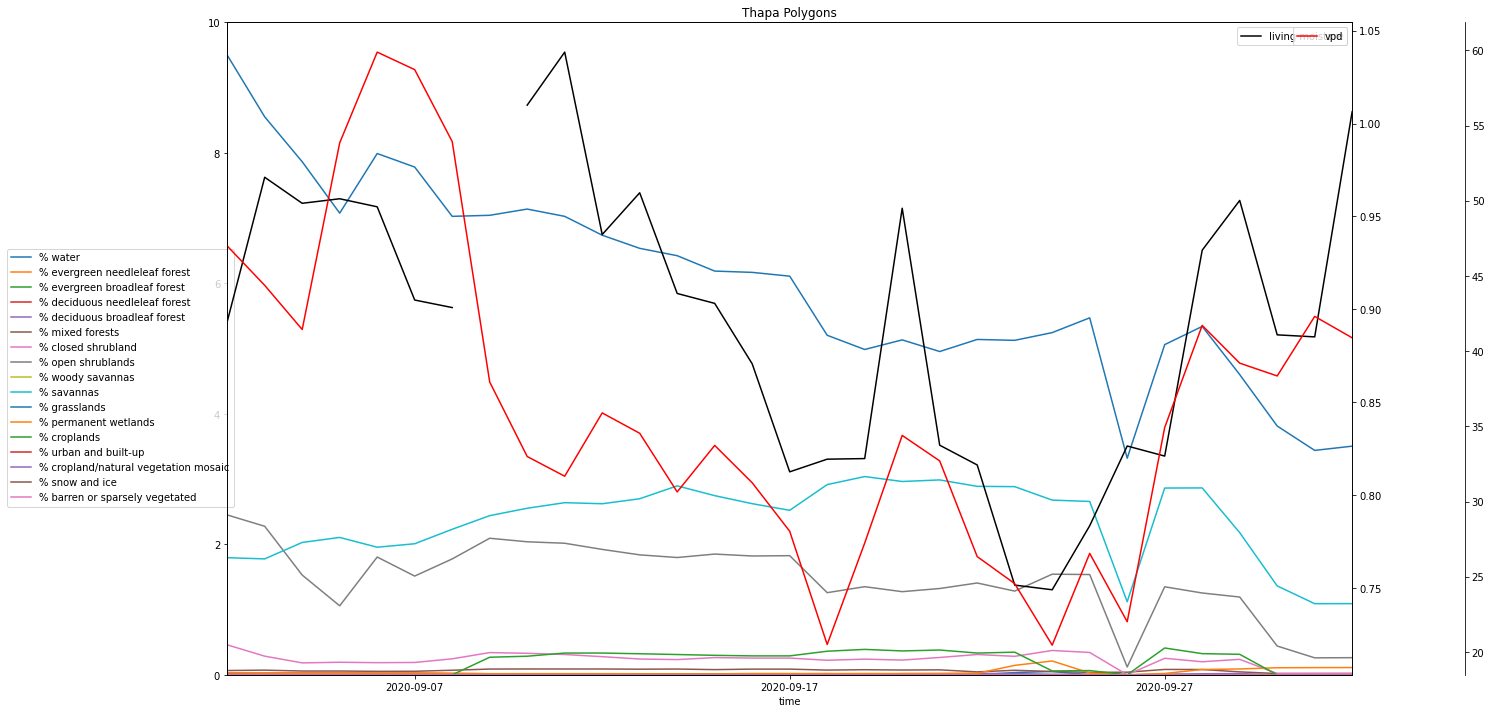

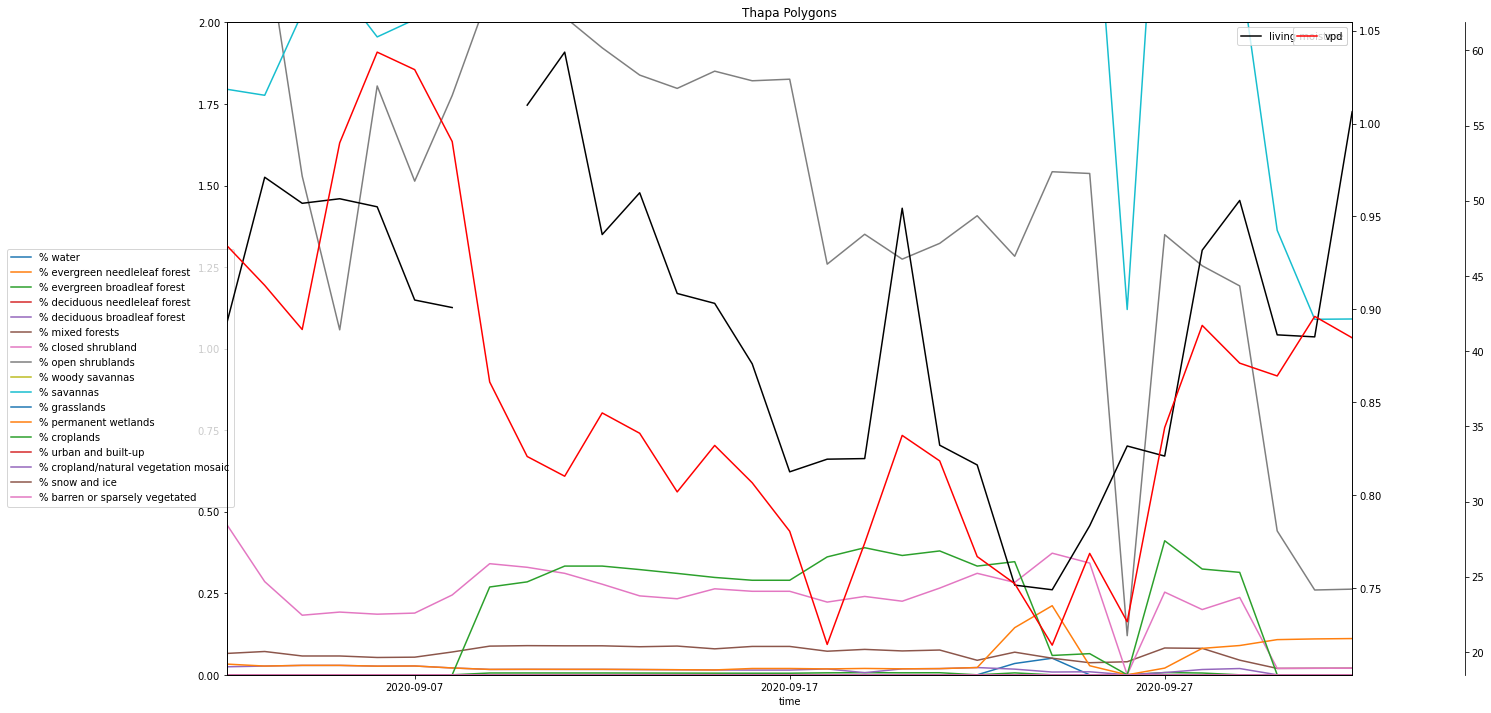

In [6]:
df_igbp_thapa = pd.read_csv('AC_IGBP_Thapa.csv')
df_thapa = pd.read_csv('AC_Thapa.csv')
df_combined_thapa = pd.concat([df_thapa[['time']], df_igbp_thapa.drop(columns='Unnamed: 0')], axis=1)

fig, ax = plt.subplots(figsize=(25,12)) #set up the figure
fig.subplots_adjust(right=0.75)
df_combined_thapa.plot(x='time', ax=ax)
plt.legend(bbox_to_anchor=(-.2, 0.25))
plt.ylim([0,100])
ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_thapa[['time', 'living moisture']].plot(x='time', ax=ax2, c='k')
df_thapa[['time', 'vpd']].plot(x='time', ax=ax3, c='r')
plt.title('Thapa Polygons')
plt.show()


fig, ax = plt.subplots(figsize=(25,12)) #set up the figure
fig.subplots_adjust(right=0.75)
df_combined_thapa.plot(x='time', ax=ax)
plt.legend(bbox_to_anchor=(-.2, 0.25))
plt.ylim([0,100])
ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_thapa[['time', 'living moisture']].plot(x='time', ax=ax2, c='k')
df_thapa[['time', 'vpd']].plot(x='time', ax=ax3, c='r')
plt.xlim([15,45])
plt.title('Thapa Polygons')
plt.show()


fig, ax = plt.subplots(figsize=(25,12)) #set up the figure
fig.subplots_adjust(right=0.75)
df_combined_thapa.plot(x='time', ax=ax)
plt.legend(bbox_to_anchor=(-.2, 0.25))
plt.ylim([0,10])
ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_thapa[['time', 'living moisture']].plot(x='time', ax=ax2, c='k')
df_thapa[['time', 'vpd']].plot(x='time', ax=ax3, c='r')
plt.xlim([15,45])
plt.title('Thapa Polygons')
plt.show()

fig, ax = plt.subplots(figsize=(25,12)) #set up the figure
fig.subplots_adjust(right=0.75)
df_combined_thapa.plot(x='time', ax=ax)
plt.legend(bbox_to_anchor=(-.2, 0.25))
plt.ylim([0,2])
ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_thapa[['time', 'living moisture']].plot(x='time', ax=ax2, c='k')
df_thapa[['time', 'vpd']].plot(x='time', ax=ax3, c='r')
plt.xlim([15,45])
plt.title('Thapa Polygons')
plt.show()


In [ ]:
df_igbp_mcclure = pd.read_csv('AC_IGBP_McClure.csv')
df_mcclure= pd.read_csv('AC_McClure.csv')

#print(df_igbp_thapa.drop(columns='Unnamed: 0'))
df_combined_mcclure = pd.concat([df_mcclure[['time']], df_igbp_mcclure.drop(columns='Unnamed: 0')], axis=1)

fig, ax = plt.subplots(figsize=(25,12)) #set up the figure
fig.subplots_adjust(right=0.75)
df_combined_mcclure.plot(x='time', ax=ax)
plt.legend(bbox_to_anchor=(-.2, 0.25))
plt.ylim([0,100])
ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_mcclure[['time', 'living moisture']].plot(x='time', ax=ax2, c='k')
df_mcclure[['time', 'vpd']].plot(x='time', ax=ax3, c='r')
plt.title('McClure Polygons')
plt.show()

fig, ax = plt.subplots(figsize=(25,12)) #set up the figure
fig.subplots_adjust(right=0.75)
df_combined_mcclure.plot(x='time', ax=ax)
plt.legend(bbox_to_anchor=(-.2, 0.25))
plt.ylim([0,100])
ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_mcclure[['time', 'living moisture']].plot(x='time', ax=ax2, c='k')
df_mcclure[['time', 'vpd']].plot(x='time', ax=ax3, c='r')
plt.xlim([15,45])
plt.title('McClure Polygons')
plt.show()


fig, ax = plt.subplots(figsize=(25,12)) #set up the figure
fig.subplots_adjust(right=0.75)
df_combined_mcclure.plot(x='time', ax=ax)
plt.legend(bbox_to_anchor=(-.2, 0.25))
plt.ylim([0,10])
ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_mcclure[['time', 'living moisture']].plot(x='time', ax=ax2, c='k')
df_mcclure[['time', 'vpd']].plot(x='time', ax=ax3, c='r')
plt.xlim([15,45])
plt.title('McClure Polygons')
plt.show()

fig, ax = plt.subplots(figsize=(25,12)) #set up the figure
fig.subplots_adjust(right=0.75)
df_combined_mcclure.plot(x='time', ax=ax)
plt.legend(bbox_to_anchor=(-.2, 0.25))
plt.ylim([0,2])
ax2=ax.twinx()
ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_mcclure[['time', 'living moisture']].plot(x='time', ax=ax2, c='k')
df_mcclure[['time', 'vpd']].plot(x='time', ax=ax3, c='r')
plt.xlim([15,45])
plt.title('McClure Polygons')
plt.show()


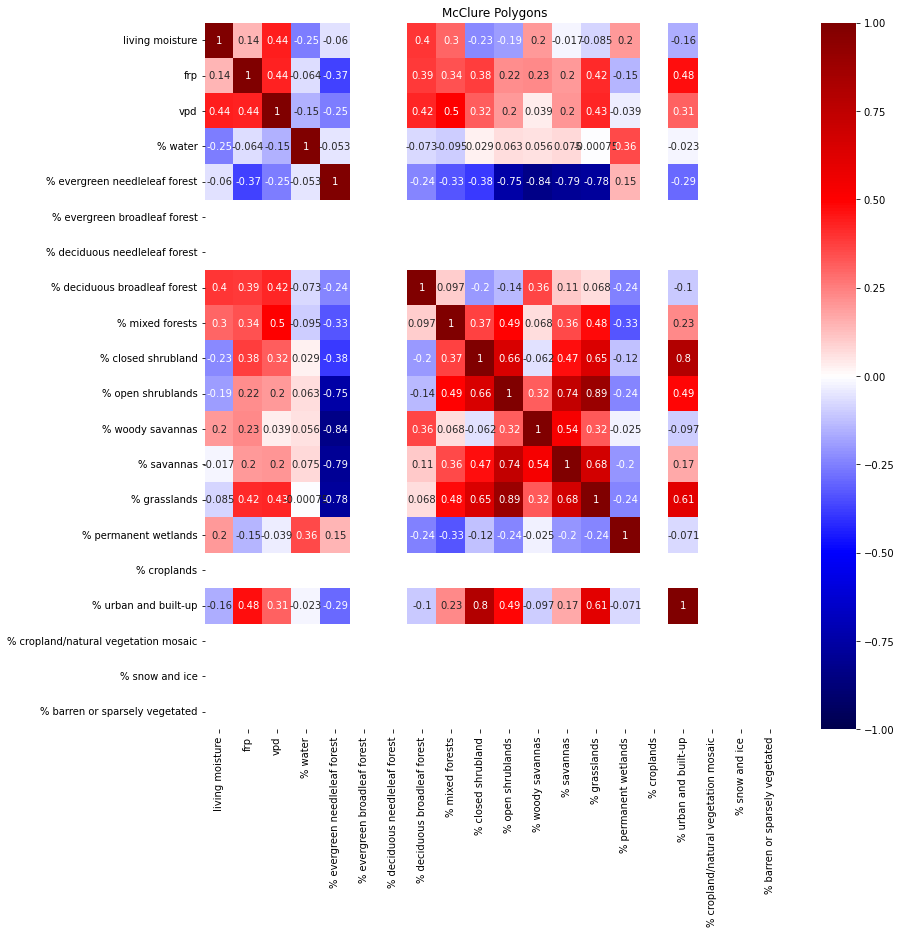

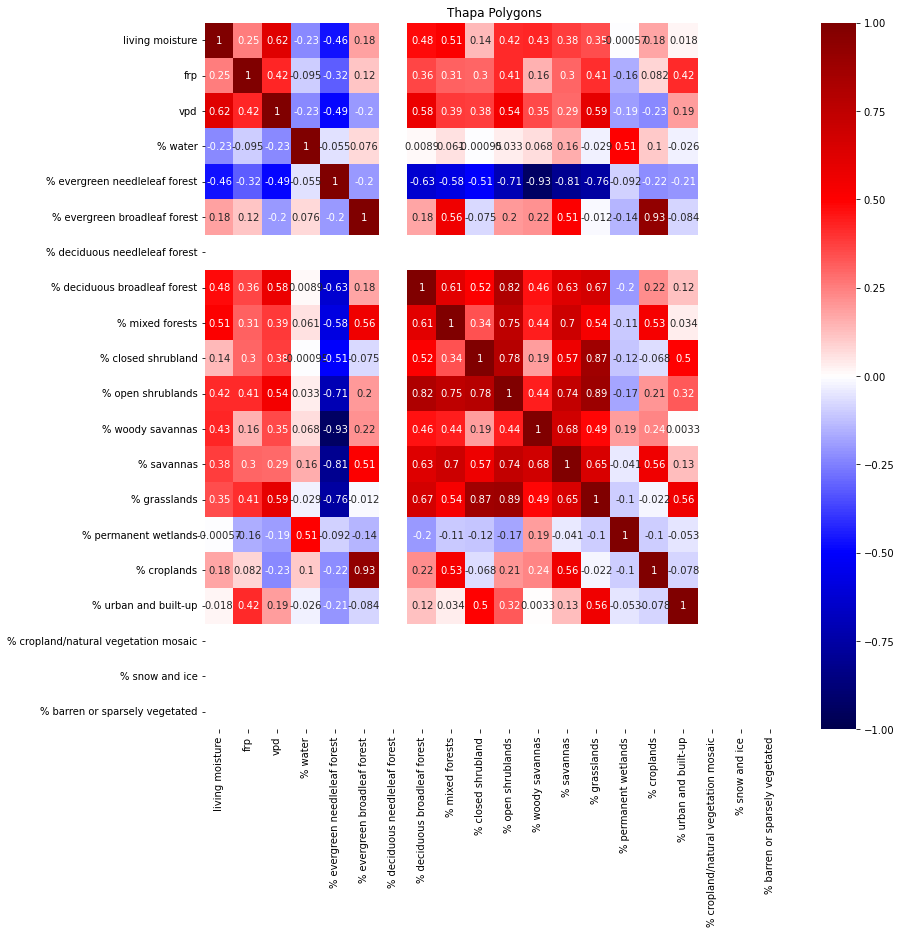

In [23]:
df_igbp_mcclure = pd.read_csv('AC_IGBP_McClure.csv')
df_mcclure= pd.read_csv('AC_McClure.csv')
df_combined_mcclure = pd.concat([df_mcclure[['time', 'living moisture', 'frp', 'vpd']], df_igbp_mcclure.drop(columns='Unnamed: 0')], axis=1)

df_igbp_thapa = pd.read_csv('AC_IGBP_Thapa.csv')
df_thapa = pd.read_csv('AC_Thapa.csv')
df_combined_thapa = pd.concat([df_thapa[['time', 'living moisture', 'frp', 'vpd']], df_igbp_thapa.drop(columns='Unnamed: 0')], axis=1)


corrMatrix_mcclure = df_combined_mcclure.corr()
fig,ax=plt.subplots(figsize=(13,13))
sns.heatmap(corrMatrix_mcclure, annot=True, vmin=-1, vmax=1,cmap='seismic')
plt.title('McClure Polygons')
plt.show()


corrMatrix_thapa = df_combined_thapa.corr()
fig,ax=plt.subplots(figsize=(13,13))
sns.heatmap(corrMatrix_thapa, annot=True, vmin=-1, vmax=1,cmap='seismic')
plt.title('Thapa Polygons')
plt.show()

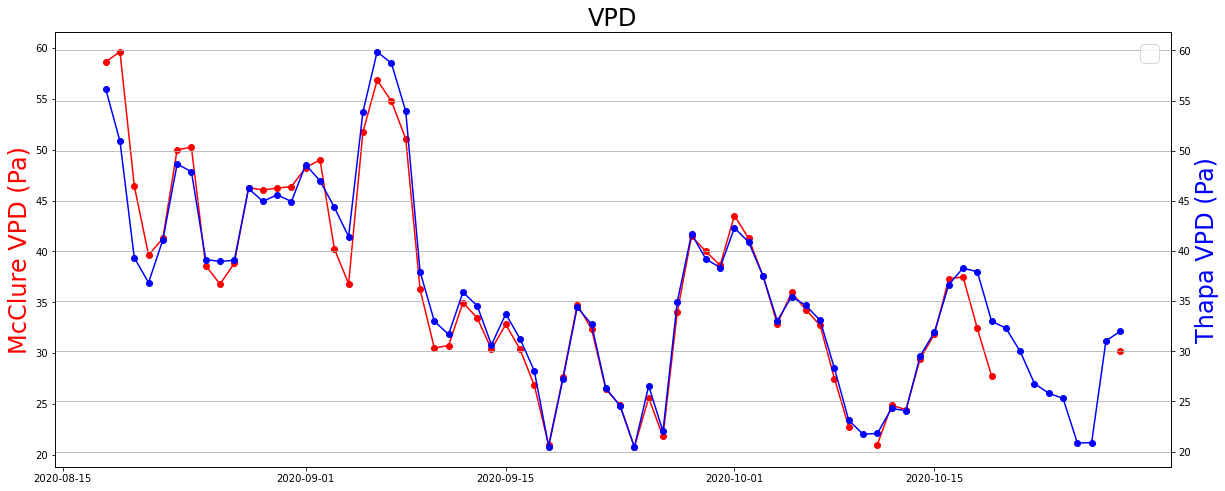

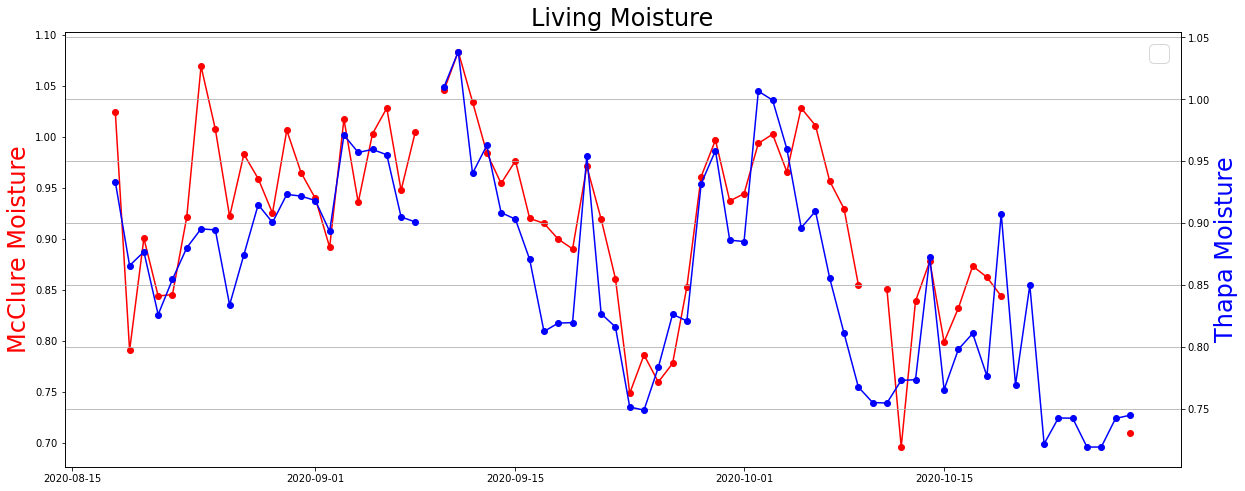

% water
McClure Correlations:             % fuel  moisture
% fuel    1.000000 -0.250014
moisture -0.250014  1.000000
Thapa Correlations:             % fuel  moisture
% fuel    1.000000 -0.228207
moisture -0.228207  1.000000


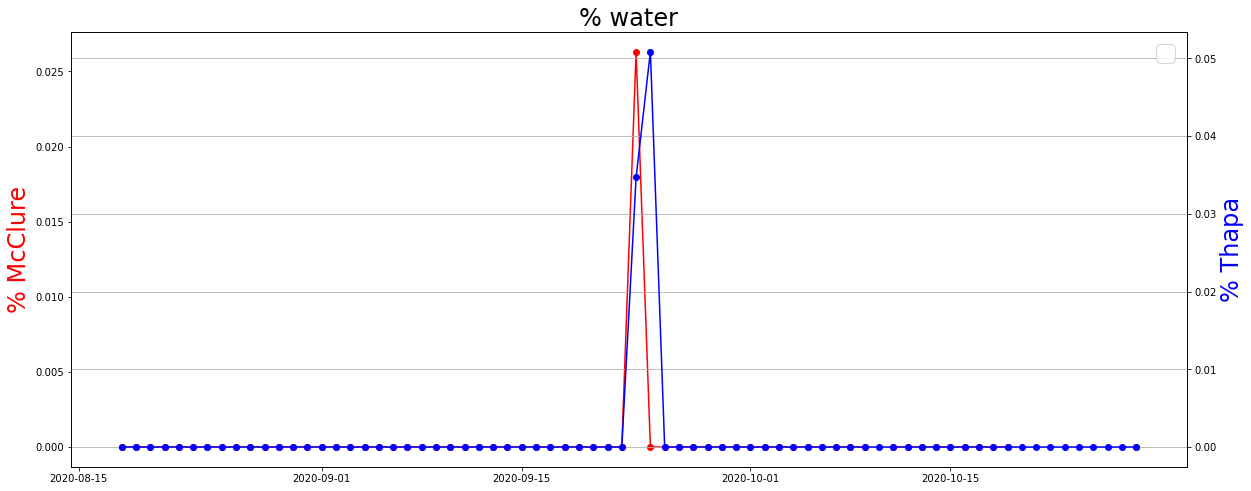

% evergreen needleleaf forest
McClure Correlations:            % fuel  moisture
% fuel    1.00000  -0.06016
moisture -0.06016   1.00000
Thapa Correlations:             % fuel  moisture
% fuel    1.000000 -0.461131
moisture -0.461131  1.000000


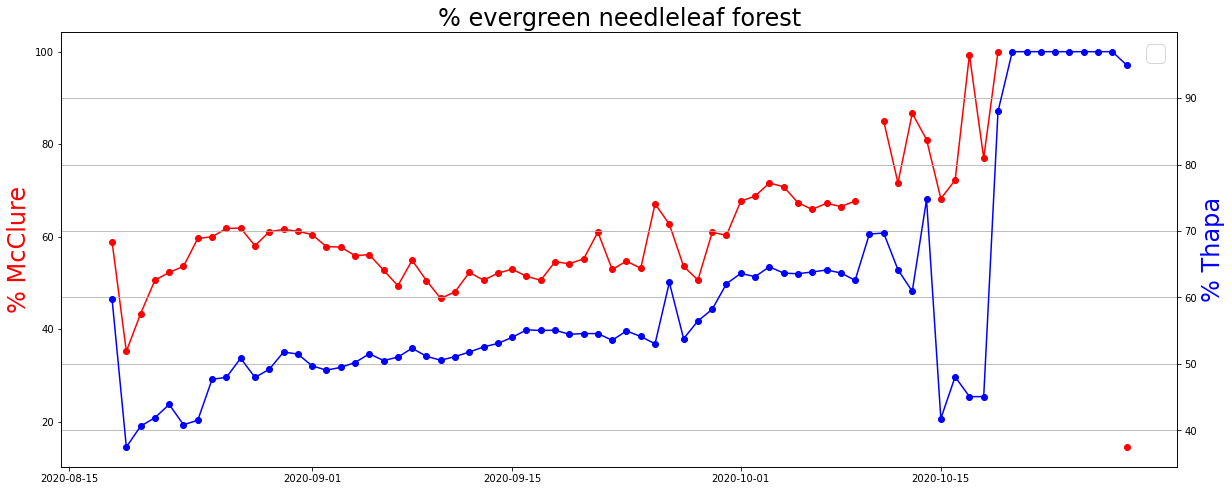

% evergreen broadleaf forest
McClure Correlations:           % fuel  moisture
% fuel       NaN       NaN
moisture     NaN       1.0
Thapa Correlations:             % fuel  moisture
% fuel    1.000000  0.183594
moisture  0.183594  1.000000


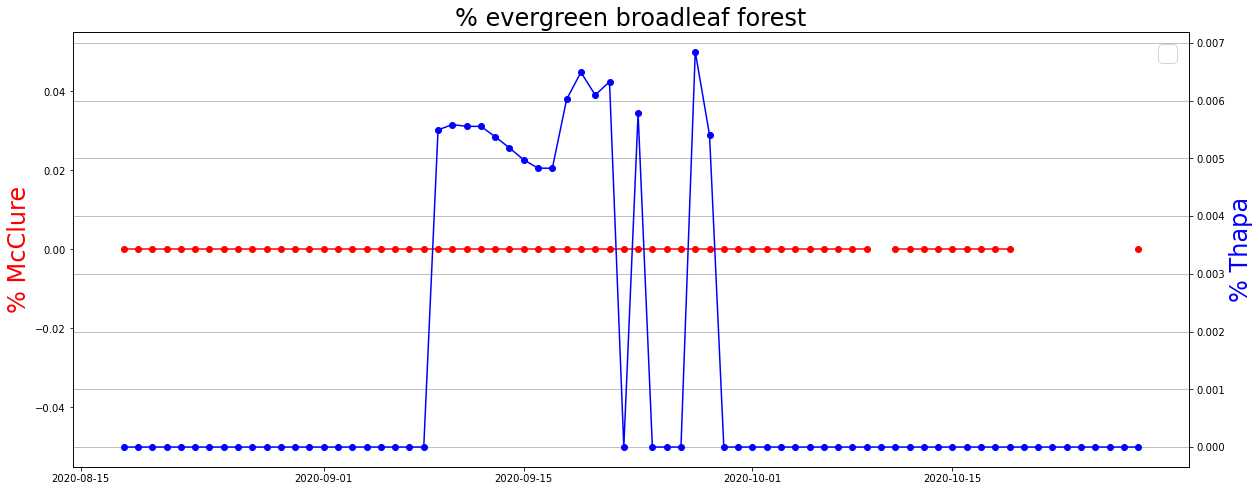

% deciduous needleleaf forest
McClure Correlations:           % fuel  moisture
% fuel       NaN       NaN
moisture     NaN       1.0
Thapa Correlations:           % fuel  moisture
% fuel       NaN       NaN
moisture     NaN       1.0


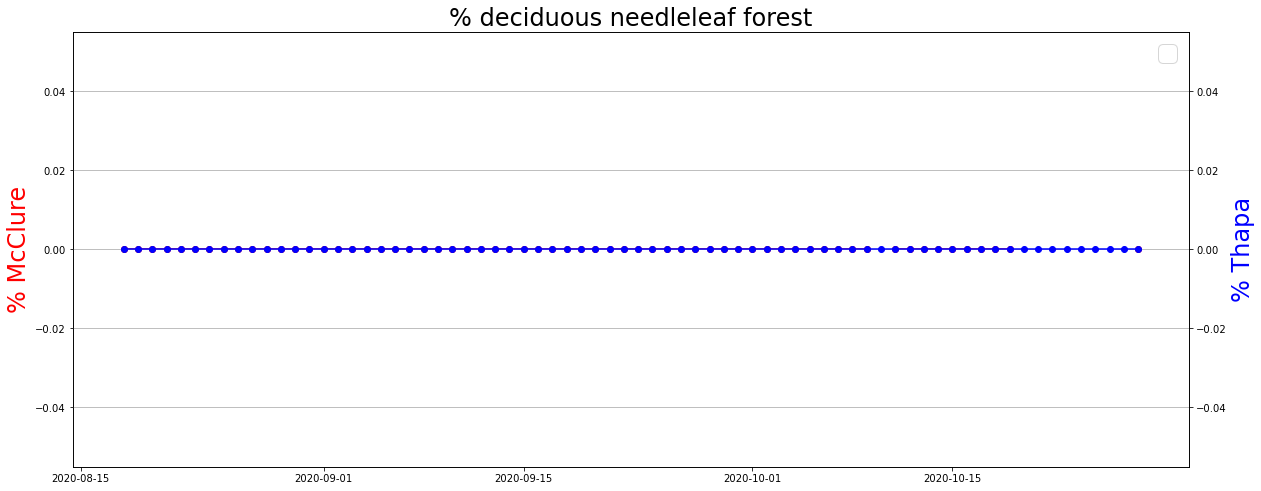

% deciduous broadleaf forest
McClure Correlations:             % fuel  moisture
% fuel    1.000000  0.396271
moisture  0.396271  1.000000
Thapa Correlations:             % fuel  moisture
% fuel    1.000000  0.480204
moisture  0.480204  1.000000


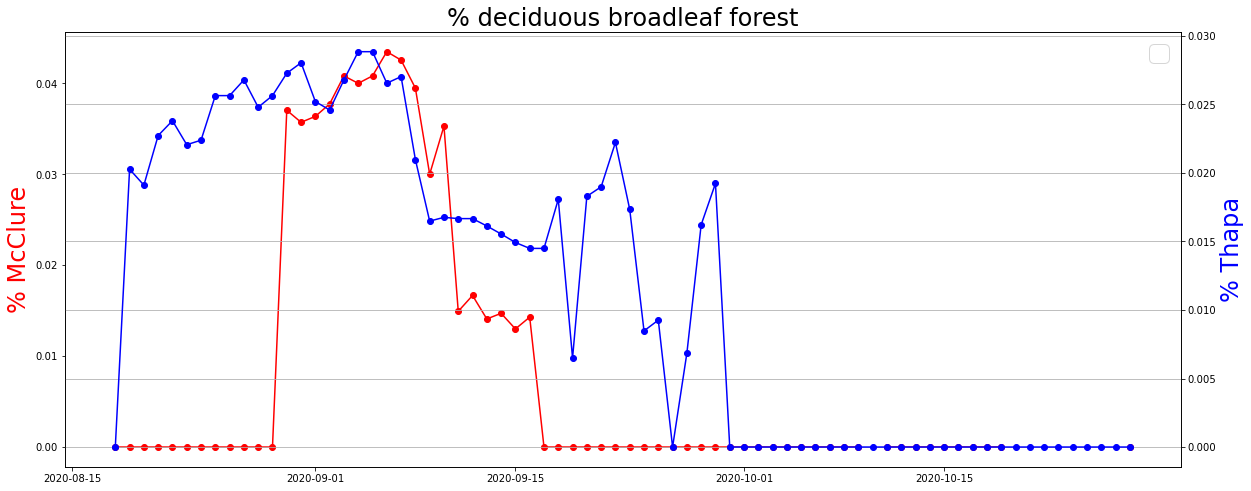

% mixed forests
McClure Correlations:             % fuel  moisture
% fuel    1.000000  0.297717
moisture  0.297717  1.000000
Thapa Correlations:             % fuel  moisture
% fuel    1.000000  0.511298
moisture  0.511298  1.000000


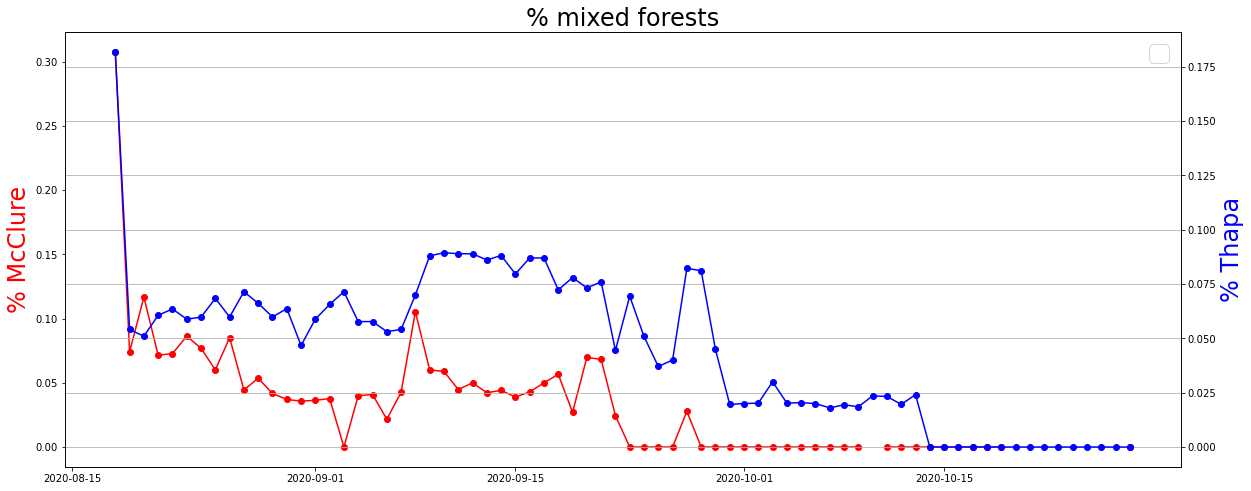

% closed shrubland
McClure Correlations:             % fuel  moisture
% fuel    1.000000 -0.231285
moisture -0.231285  1.000000
Thapa Correlations:             % fuel  moisture
% fuel    1.000000  0.137789
moisture  0.137789  1.000000


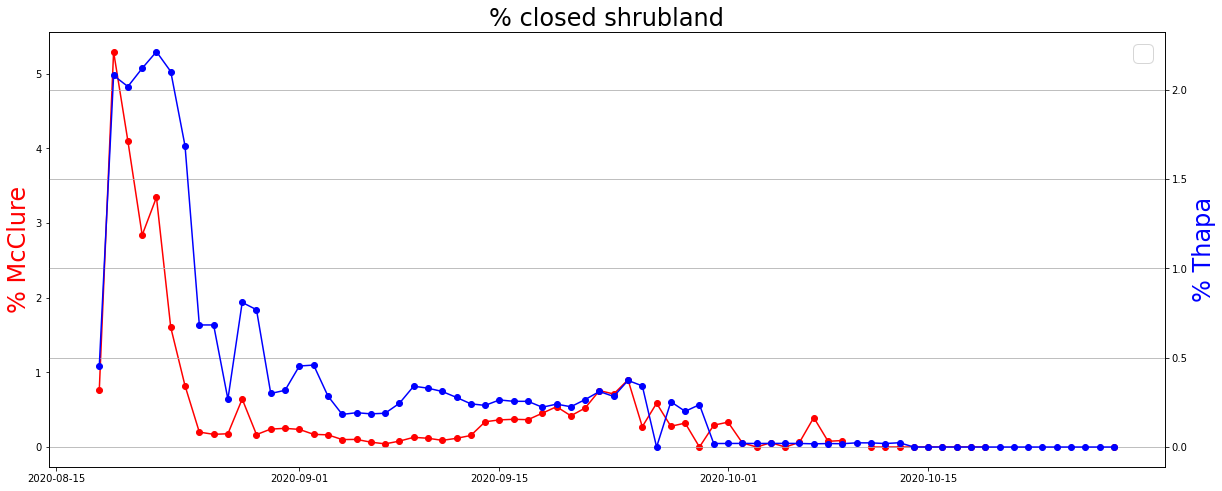

% open shrublands
McClure Correlations:             % fuel  moisture
% fuel    1.000000 -0.191688
moisture -0.191688  1.000000
Thapa Correlations:             % fuel  moisture
% fuel    1.000000  0.421624
moisture  0.421624  1.000000


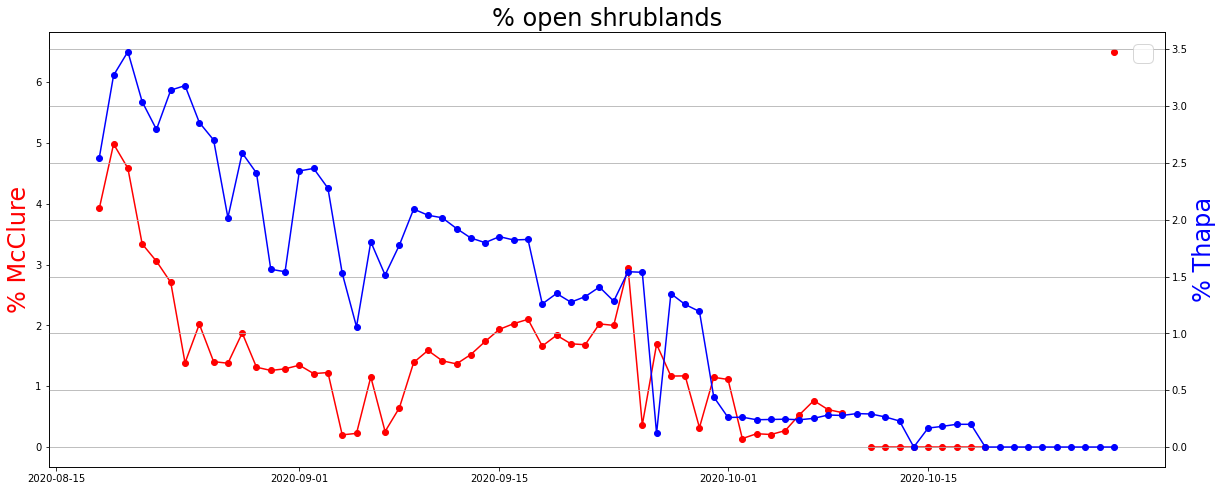

% woody savannas
McClure Correlations:             % fuel  moisture
% fuel    1.000000  0.198236
moisture  0.198236  1.000000
Thapa Correlations:             % fuel  moisture
% fuel    1.000000  0.425864
moisture  0.425864  1.000000


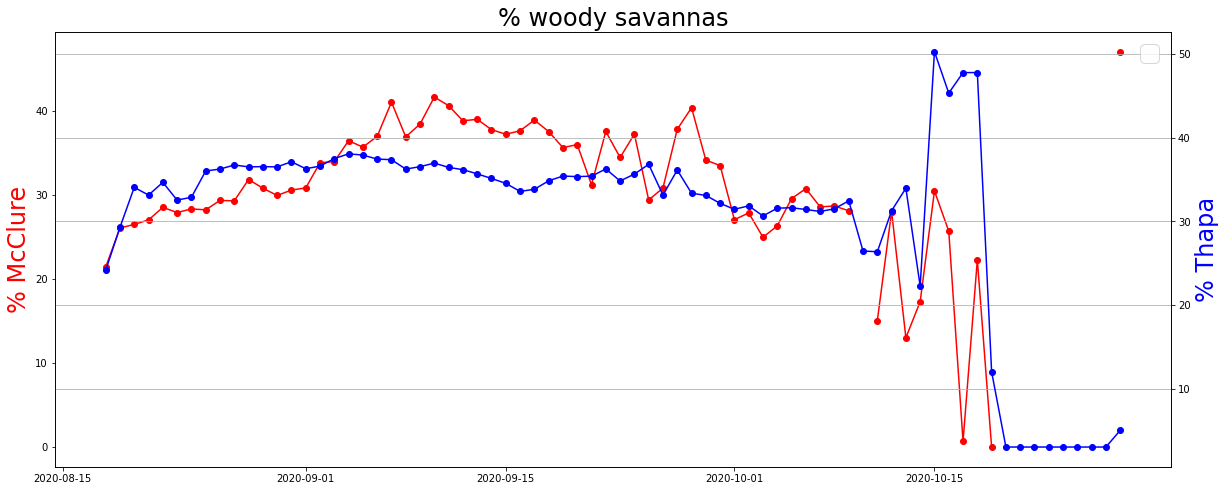

% savannas
McClure Correlations:             % fuel  moisture
% fuel    1.000000 -0.017215
moisture -0.017215  1.000000
Thapa Correlations:             % fuel  moisture
% fuel    1.000000  0.378186
moisture  0.378186  1.000000


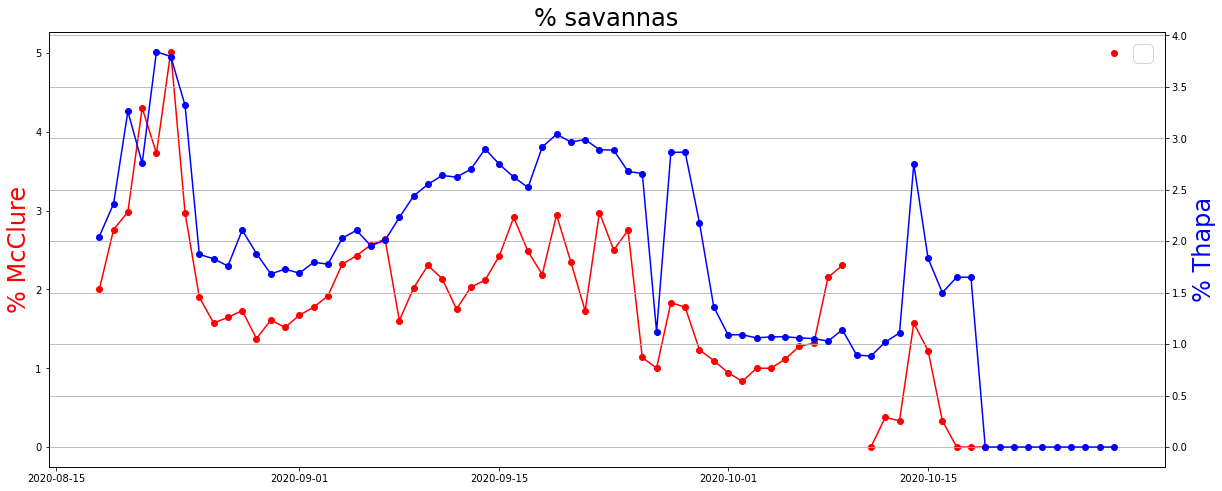

% grasslands
McClure Correlations:             % fuel  moisture
% fuel    1.000000 -0.085144
moisture -0.085144  1.000000
Thapa Correlations:             % fuel  moisture
% fuel    1.000000  0.347163
moisture  0.347163  1.000000


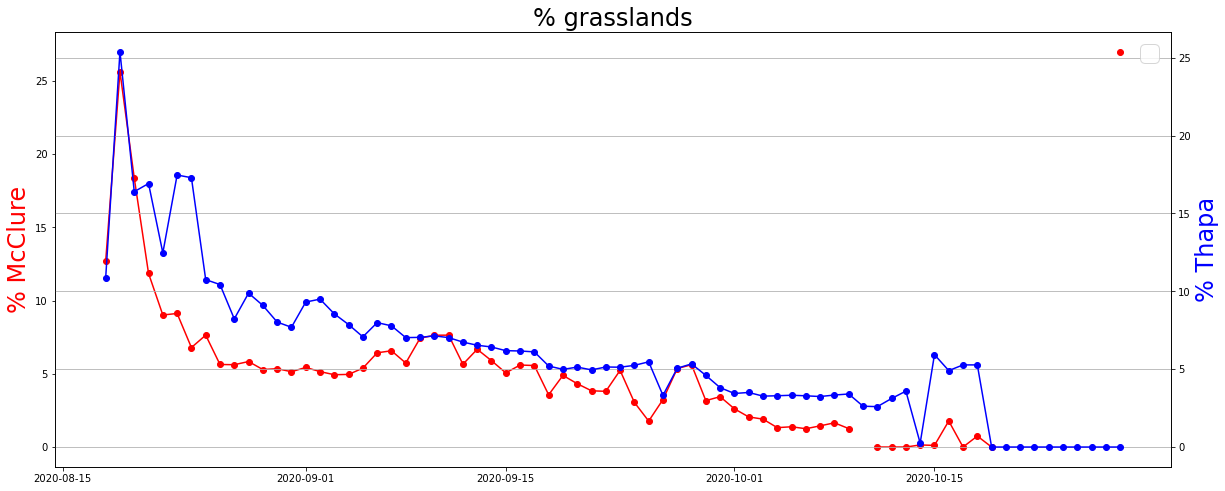

% permanent wetlands
McClure Correlations:             % fuel  moisture
% fuel    1.000000  0.198469
moisture  0.198469  1.000000
Thapa Correlations:             % fuel  moisture
% fuel    1.000000 -0.000572
moisture -0.000572  1.000000


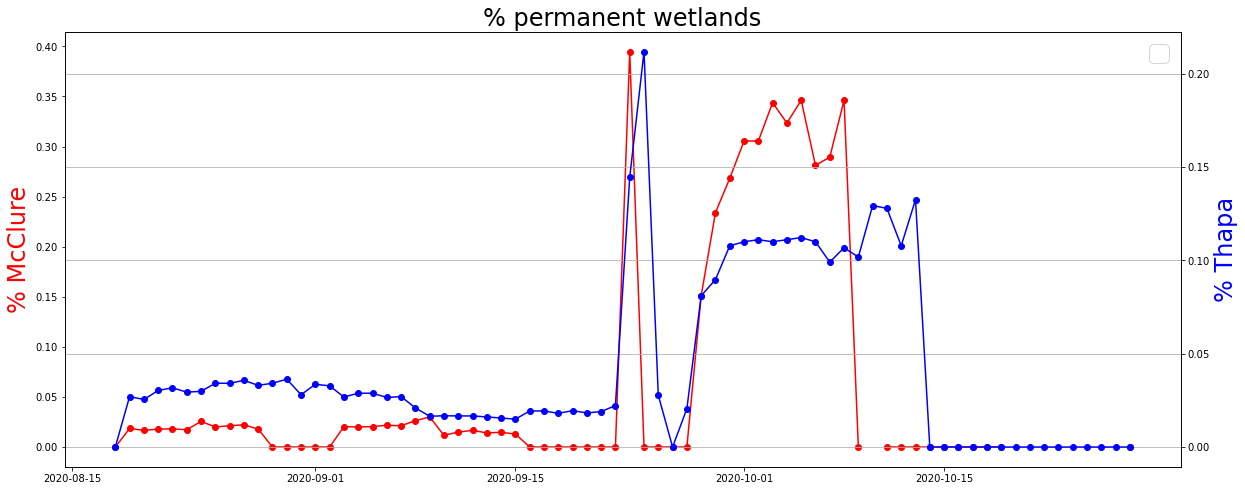

% croplands
McClure Correlations:           % fuel  moisture
% fuel       NaN       NaN
moisture     NaN       1.0
Thapa Correlations:             % fuel  moisture
% fuel    1.000000  0.176496
moisture  0.176496  1.000000


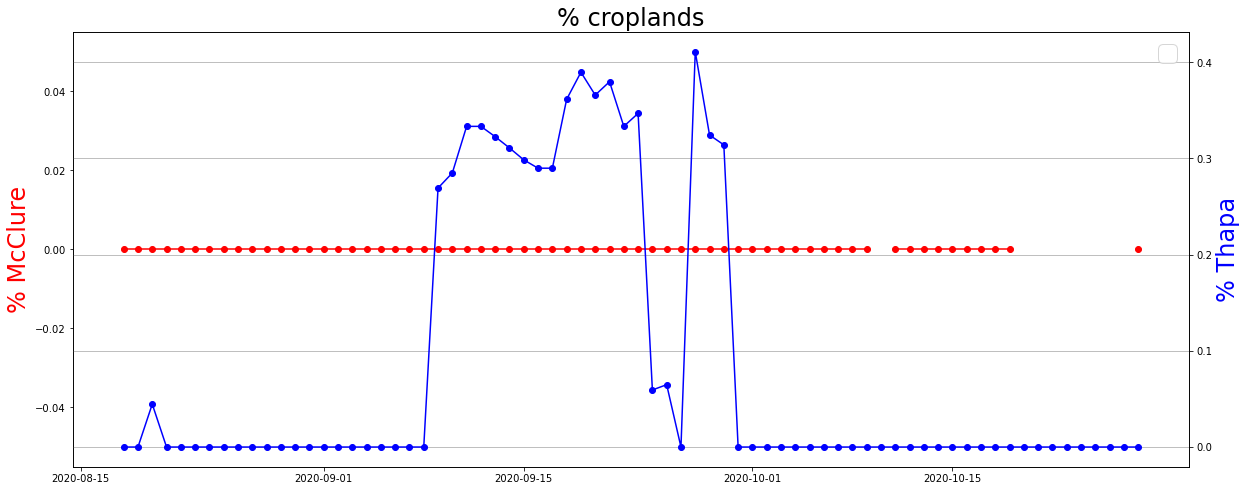

% urban and built-up
McClure Correlations:             % fuel  moisture
% fuel    1.000000 -0.161335
moisture -0.161335  1.000000
Thapa Correlations:             % fuel  moisture
% fuel    1.000000  0.017943
moisture  0.017943  1.000000


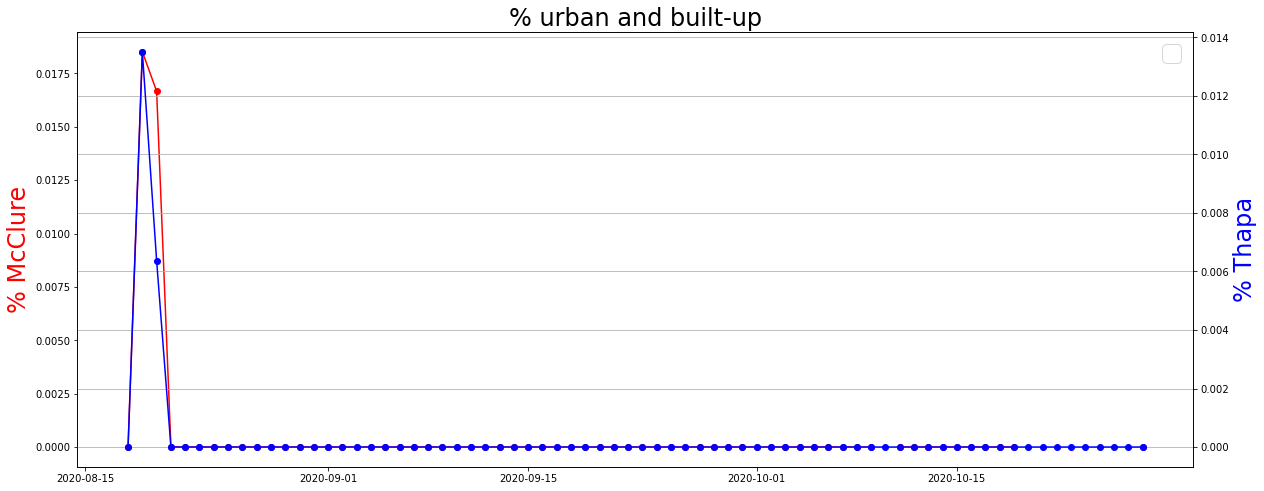

% cropland/natural vegetation mosaic
McClure Correlations:           % fuel  moisture
% fuel       NaN       NaN
moisture     NaN       1.0
Thapa Correlations:           % fuel  moisture
% fuel       NaN       NaN
moisture     NaN       1.0


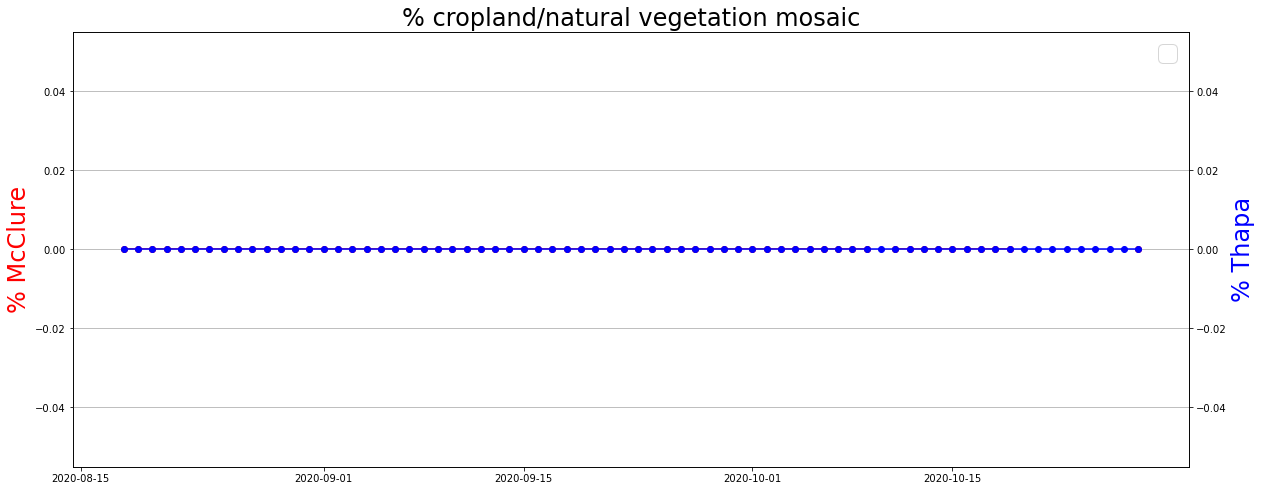

% snow and ice
McClure Correlations:           % fuel  moisture
% fuel       NaN       NaN
moisture     NaN       1.0
Thapa Correlations:           % fuel  moisture
% fuel       NaN       NaN
moisture     NaN       1.0


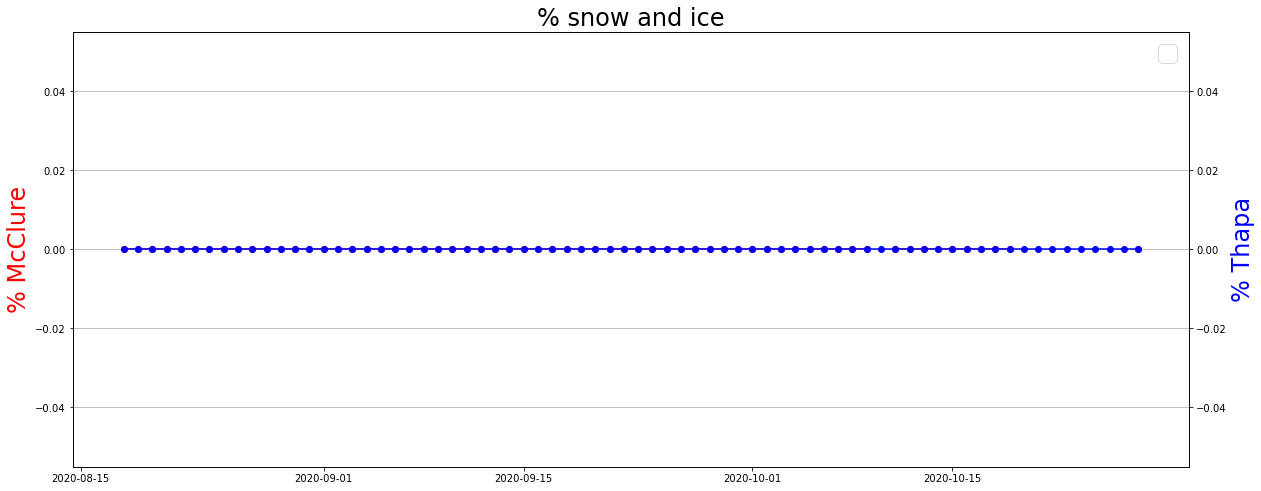

% barren or sparsely vegetated
McClure Correlations:           % fuel  moisture
% fuel       NaN       NaN
moisture     NaN       1.0
Thapa Correlations:           % fuel  moisture
% fuel       NaN       NaN
moisture     NaN       1.0


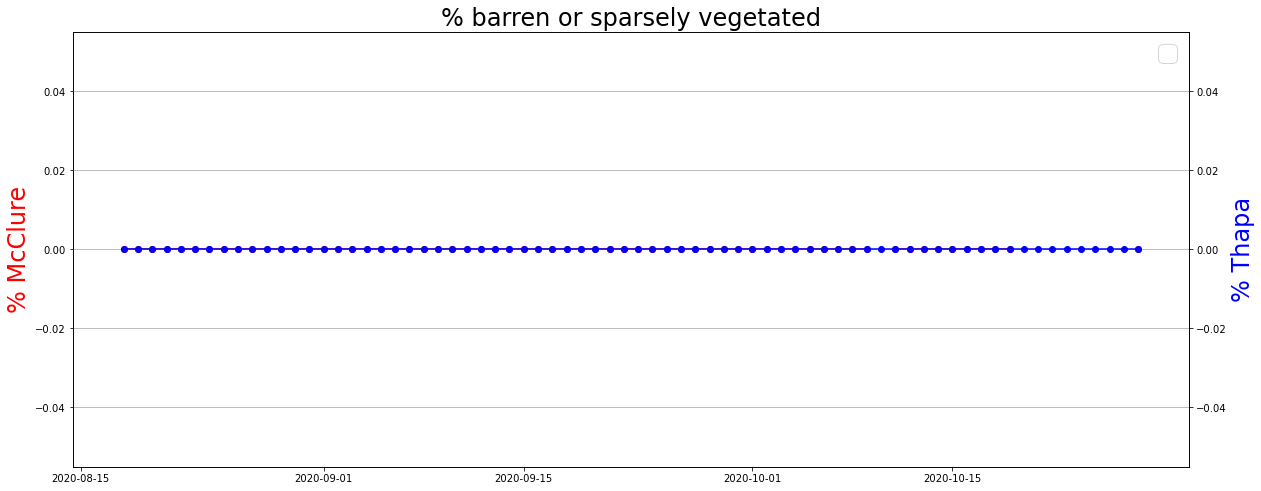

In [22]:
df_igbp_mcclure = pd.read_csv('AC_IGBP_McClure.csv')
df_mcclure= pd.read_csv('AC_McClure.csv')

df_igbp_thapa = pd.read_csv('AC_IGBP_Thapa.csv')
df_thapa = pd.read_csv('AC_Thapa.csv')

col_names = ['% water', '% evergreen needleleaf forest','% evergreen broadleaf forest',\
                              '% deciduous needleleaf forest',\
                               '% deciduous broadleaf forest', '% mixed forests',\
                              '% closed shrubland', '% open shrublands',\
                              '% woody savannas','% savannas',\
                              '% grasslands', '% permanent wetlands',
                              '% croplands', '% urban and built-up',
                              '% cropland/natural vegetation mosaic',
                              '% snow and ice',\
                             '% barren or sparsely vegetated']
plot_twoline(times, np.stack([df_mcclure['vpd'].values, df_thapa['vpd'].values]), 'VPD',\
            [], ['McClure VPD (Pa)', 'Thapa VPD (Pa)'], 1)

plot_twoline(times, np.stack([df_mcclure['living moisture'].values, df_thapa['living moisture'].values]), 'Living Moisture',\
            [], ['McClure Moisture', 'Thapa Moisture'], 1)

for var in col_names:
    print(var)
    print('McClure Correlations: '+ str(pd.DataFrame({'% fuel':df_igbp_mcclure[var].values, 'moisture':df_mcclure['living moisture'].values}).corr()))
    print('Thapa Correlations: '+ str(pd.DataFrame({'% fuel':df_igbp_thapa[var].values, 'moisture':df_thapa['living moisture'].values}).corr()))

    plot_twoline(times, np.stack([df_igbp_mcclure[var].values, df_igbp_thapa[var].values]), var,\
             [], ['% McClure', '% Thapa'], 1)


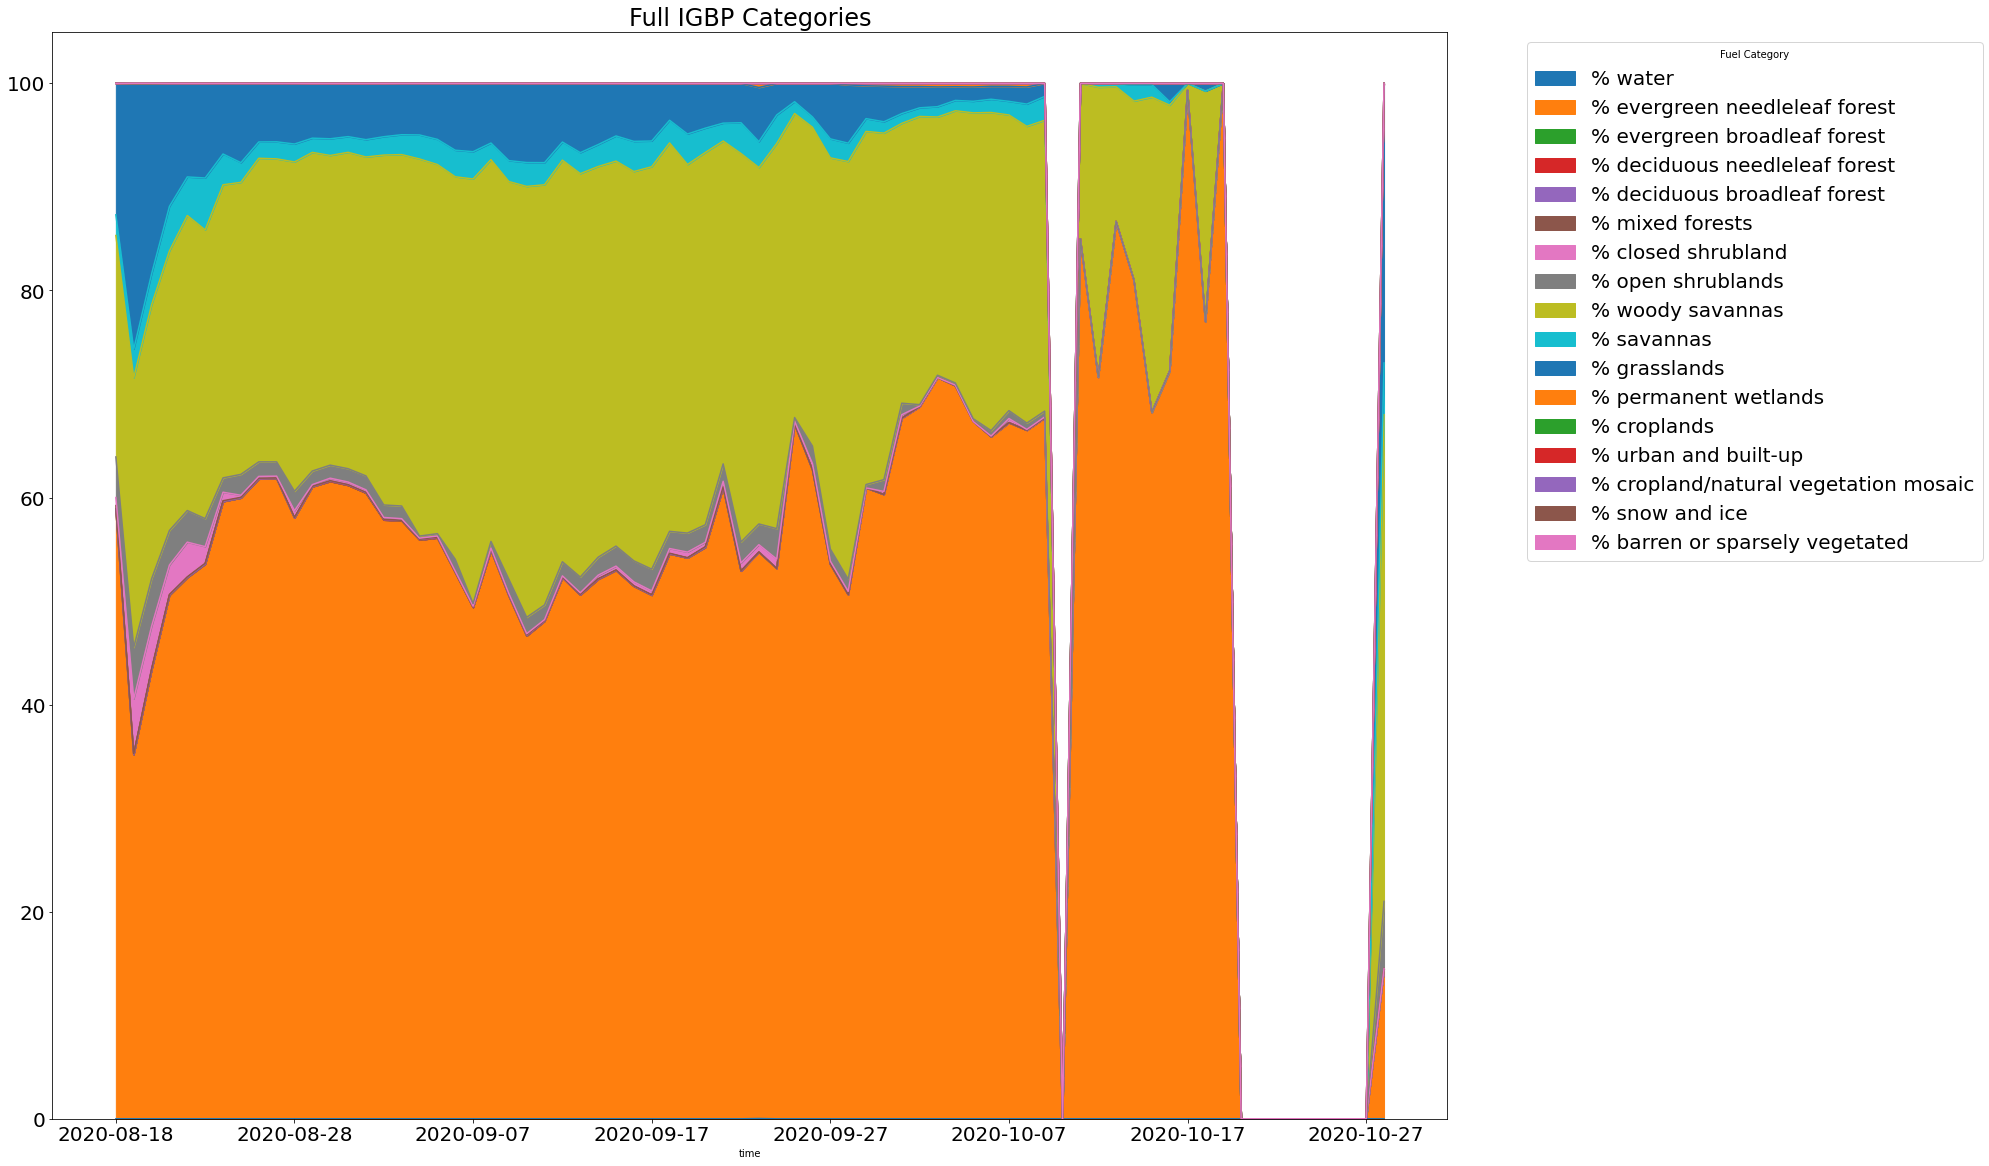

In [21]:
df_igbp_mcclure = pd.read_csv('AC_IGBP_McClure.csv')
df_mcclure= pd.read_csv('AC_McClure.csv')

df_igbp_mcclure = df_igbp_mcclure.drop(columns='Unnamed: 0')
df_igbp_mcclure['time'] = df_mcclure['time'].values

fig,ax=plt.subplots(figsize=(25,20))
df_igbp_mcclure.plot.area(x='time',stacked='True', ax=ax, fontsize=20)
plt.legend(title='Fuel Category', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=20)
plt.title('Full IGBP Categories', fontsize=24)
plt.show()

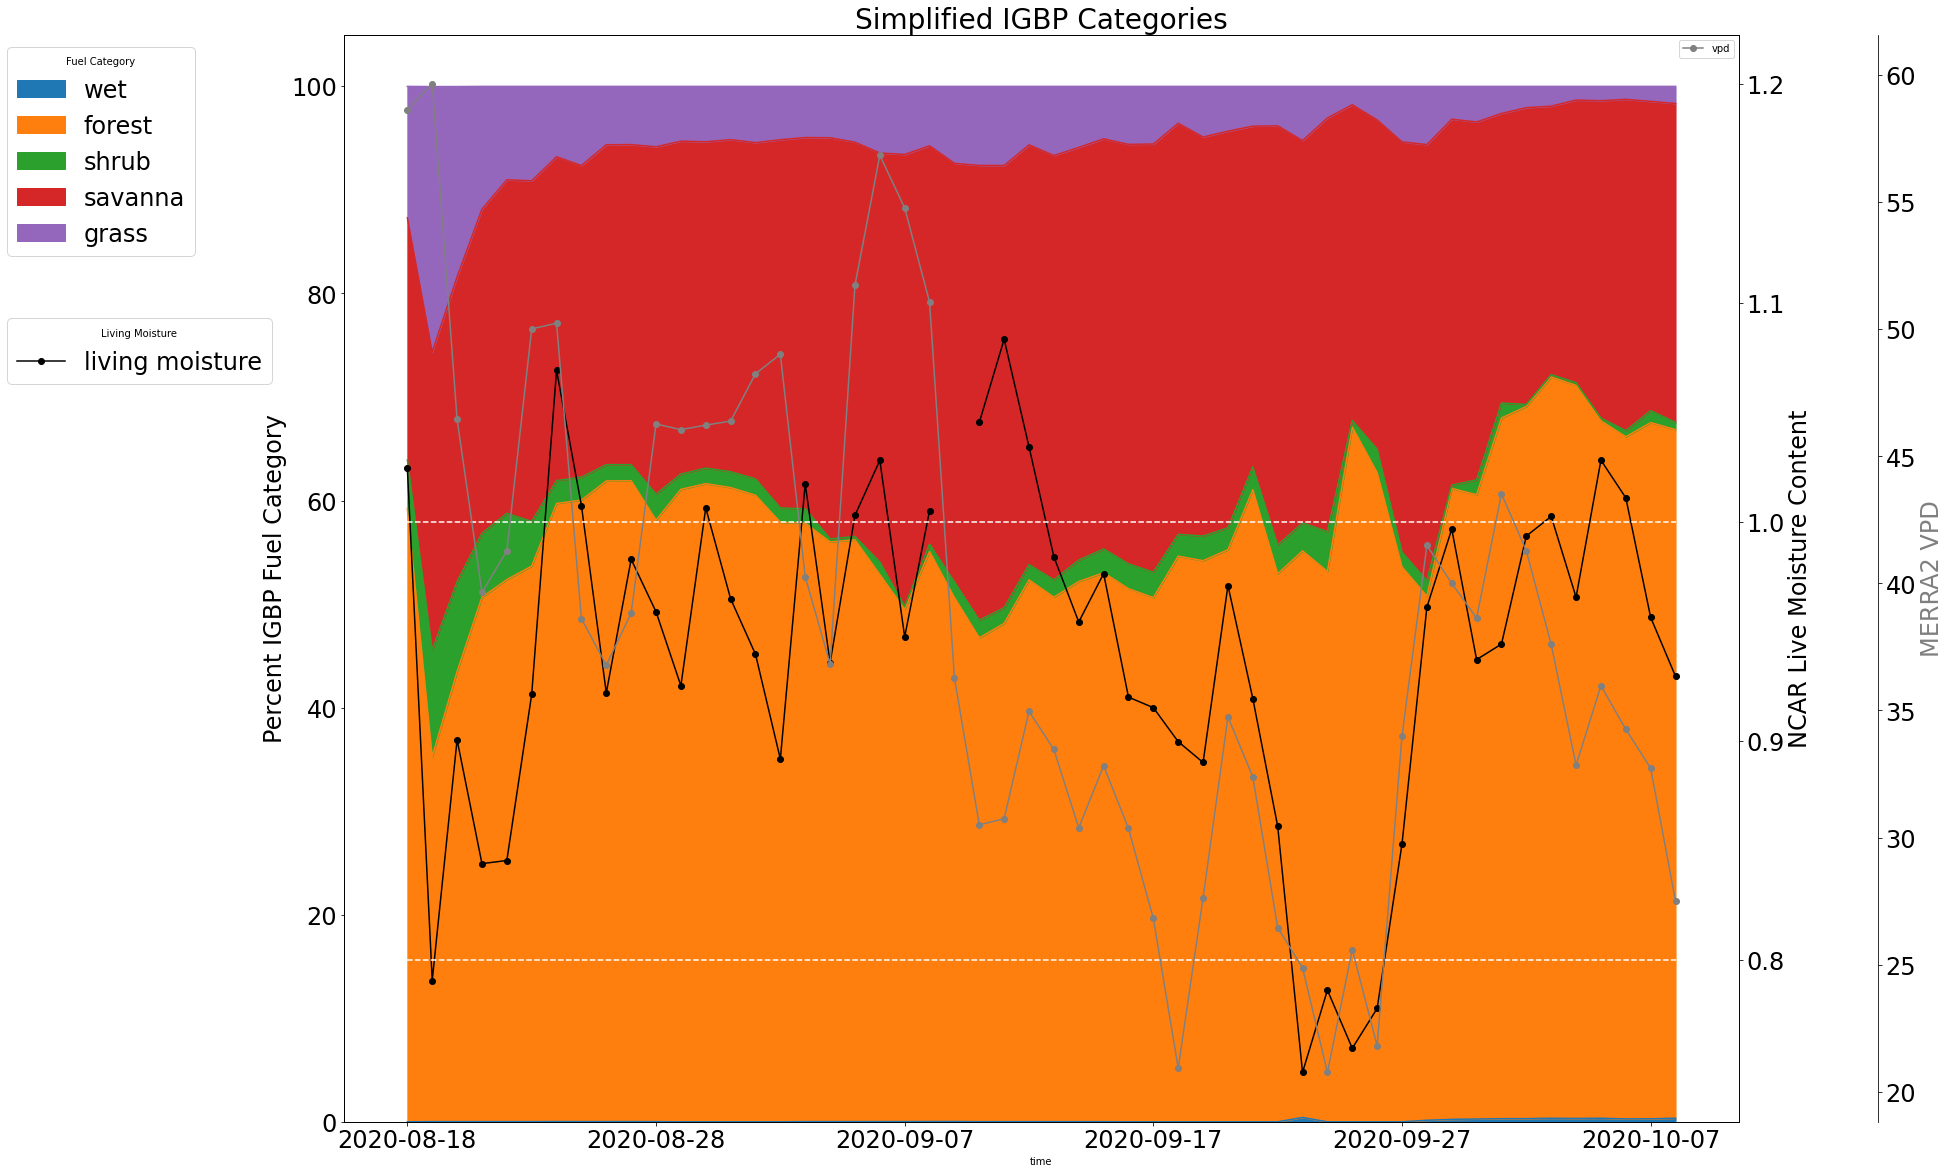

              live     % wet  % forest   % shrub   % grass
live      1.000000  0.074360  0.180174 -0.435638 -0.158639
% wet     0.074360  1.000000  0.565413 -0.316547 -0.405553
% forest  0.180174  0.565413  1.000000 -0.620828 -0.735506
% shrub  -0.435638 -0.316547 -0.620828  1.000000  0.861390
% grass  -0.158639 -0.405553 -0.735506  0.861390  1.000000


In [9]:
df_igbp_mcclure = pd.read_csv('AC_IGBP_McClure.csv')
df_mcclure= pd.read_csv('AC_McClure.csv')
df_igbp_mcclure = df_igbp_mcclure.iloc[0:52, :]
df_mcclure= df_mcclure.iloc[0:52, :]

df_mcclure_simple = pd.DataFrame({'time':df_mcclure['time'].values,\
                                  'wet': df_igbp_mcclure['% water'].values+df_igbp_mcclure['% permanent wetlands'].values,\
                                 'forest':df_igbp_mcclure['% evergreen needleleaf forest'].values+\
                                  df_igbp_mcclure['% evergreen broadleaf forest'].values+\
                                 df_igbp_mcclure['% deciduous needleleaf forest'].values+\
                                  df_igbp_mcclure['% deciduous broadleaf forest'].values+\
                                  df_igbp_mcclure['% mixed forests'].values,\
                                 'shrub': df_igbp_mcclure['% closed shrubland'].values+\
                                  df_igbp_mcclure['% open shrublands'].values,\
                                 'savanna': df_igbp_mcclure['% woody savannas'].values+\
                                  df_igbp_mcclure['% savannas'].values,\
                                 'grass':df_igbp_mcclure['% grasslands'].values})
fig,ax=plt.subplots(figsize=(25,20))
df_mcclure_simple.plot.area(x='time',stacked='True', ax=ax, fontsize=24)
plt.legend(title='Fuel Category', bbox_to_anchor=(-.25, 1), loc='upper left', fontsize=24)
plt.ylabel('Percent IGBP Fuel Category', fontsize=24)
ax2=ax.twinx()
df_mcclure.plot(x='time', y='living moisture', ax=ax2, fontsize=24, color='k', marker='o')
plt.plot(df_mcclure_simple['time'].values, .8*np.ones(len(df_mcclure_simple['time'].values)), 'w--')
plt.plot(df_mcclure_simple['time'].values, 1*np.ones(len(df_mcclure_simple['time'].values)), 'w--')
plt.plot(df_mcclure_simple['time'].values, 1.2*np.ones(len(df_mcclure_simple['time'].values)), 'w--')

plt.ylabel('NCAR Live Moisture Content', fontsize=24)

plt.legend(title='Living Moisture', bbox_to_anchor=(-.25, .75), loc='upper left', fontsize=24)

ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_mcclure.plot(x='time', y='vpd', ax=ax3, fontsize=24, color='gray', marker='o')
plt.ylabel('MERRA2 VPD', fontsize=24,color='gray')



plt.title('Simplified IGBP Categories', fontsize=28)
plt.show()
print(pd.DataFrame({'live': df_mcclure['living moisture'], '% wet': df_mcclure_simple['wet'], '% forest': df_mcclure_simple['forest']\
                   , '% shrub': df_mcclure_simple['shrub'], '% forest': df_mcclure_simple['forest'],'% grass': df_mcclure_simple['grass']}).corr())


In [14]:
print(df_mcclure_simple.iloc[20])
print(df_mcclure_simple.iloc[40])

time       2020-09-07
wet          0.021277
forest      49.468085
shrub        0.297872
savanna     43.638298
grass        6.574468
Name: 20, dtype: object
time       2020-09-27
wet               0.0
forest      53.583333
shrub        1.444444
savanna     39.611111
grass        5.361111
Name: 40, dtype: object


Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'time', 'temp', 'vpd',
       'wind', 'personnel', 'dead_moisture', 'living moisture', 'cod', 'frp',
       'num_points', 'Mean_FRP', 'FRE', 'CO2', 'CO', 'SO2', 'OC', 'BC',
       'PM2.5', 'NOx', 'NH3', 'PM2.5 QFED Rate', 'PM2.5 QFED Total'],
      dtype='object')


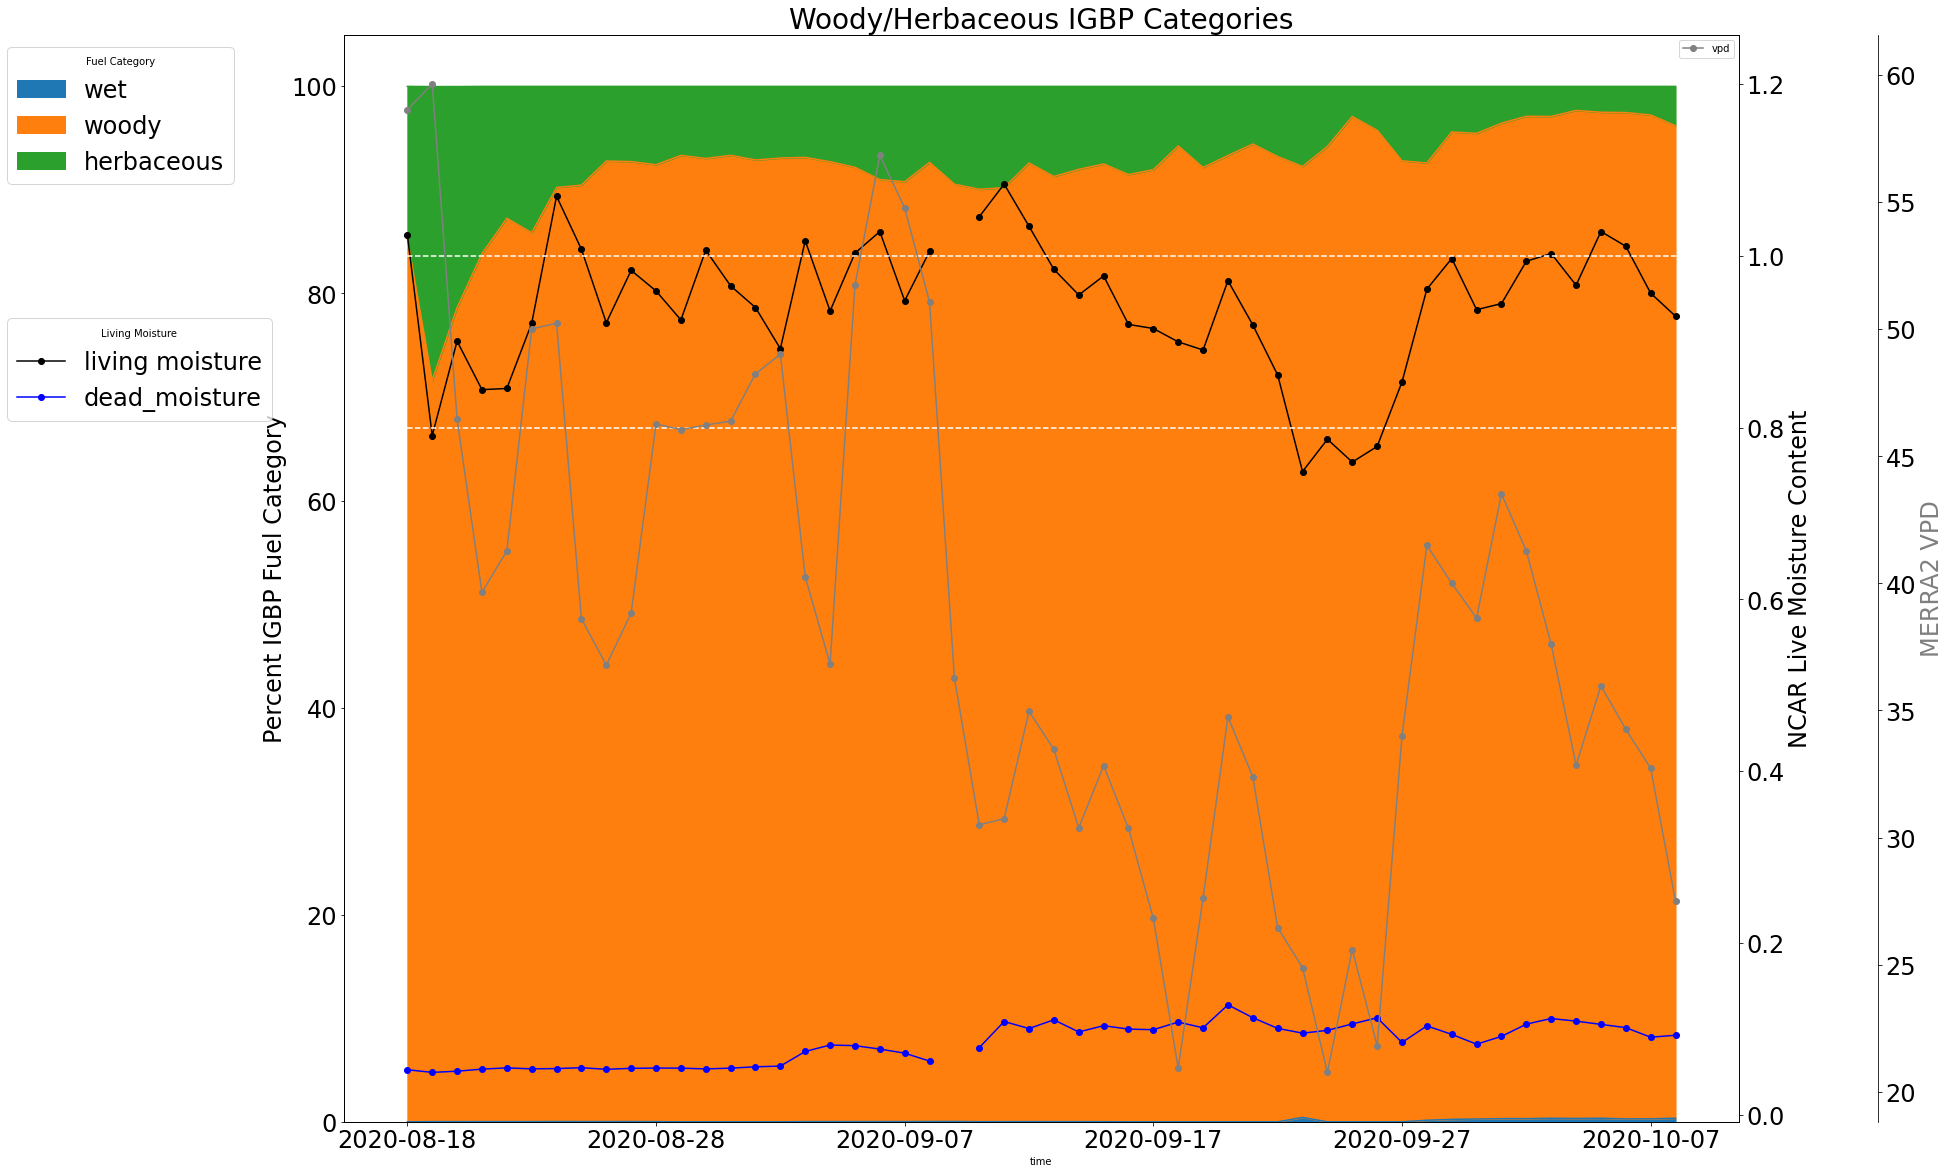

             live    % herb   % woody
live     1.000000 -0.184600  0.184812
% herb  -0.184600  1.000000 -0.999679
% woody  0.184812 -0.999679  1.000000
             dead    % herb   % woody
dead     1.000000 -0.551488  0.548471
% herb  -0.551488  1.000000 -0.999679
% woody  0.548471 -0.999679  1.000000
              vpd    % herb   % woody
vpd      1.000000  0.468743 -0.470071
% herb   0.468743  1.000000 -0.999679
% woody -0.470071 -0.999679  1.000000


In [69]:
df_igbp_mcclure = pd.read_csv('AC_IGBP_McClure.csv')
df_mcclure= pd.read_csv('AC_McClure.csv')
print(df_mcclure.columns)


df_igbp_mcclure = df_igbp_mcclure.iloc[0:52, :]
df_mcclure= df_mcclure.iloc[0:52, :]

df_mcclure_simple = pd.DataFrame({'time':df_mcclure['time'].values,\
                                  'wet': df_igbp_mcclure['% water'].values+df_igbp_mcclure['% permanent wetlands'].values,\
                                 'woody':df_igbp_mcclure['% evergreen needleleaf forest'].values+\
                                  df_igbp_mcclure['% evergreen broadleaf forest'].values+\
                                 df_igbp_mcclure['% deciduous needleleaf forest'].values+\
                                  df_igbp_mcclure['% deciduous broadleaf forest'].values+\
                                  df_igbp_mcclure['% mixed forests'].values+\
                                  df_igbp_mcclure['% closed shrubland'].values+\
                                  df_igbp_mcclure['% open shrublands'].values+ df_igbp_mcclure['% woody savannas'].values,\
                                 'herbaceous': df_igbp_mcclure['% savannas'].values+ df_igbp_mcclure['% grasslands'].values})
fig,ax=plt.subplots(figsize=(25,20))
df_mcclure_simple.plot.area(x='time',stacked='True', ax=ax, fontsize=24)
plt.legend(title='Fuel Category', bbox_to_anchor=(-.25, 1), loc='upper left', fontsize=24)
plt.ylabel('Percent IGBP Fuel Category', fontsize=24)
ax2=ax.twinx()
df_mcclure.plot(x='time', y='living moisture', ax=ax2, fontsize=24, color='k', marker='o')
#df_mcclure.plot(x='time', y='dead_moisture', ax=ax2, fontsize=24, color='b', marker='o')

plt.plot(df_mcclure_simple['time'].values, .8*np.ones(len(df_mcclure_simple['time'].values)), 'w--')
plt.plot(df_mcclure_simple['time'].values, 1*np.ones(len(df_mcclure_simple['time'].values)), 'w--')
plt.plot(df_mcclure_simple['time'].values, 1.2*np.ones(len(df_mcclure_simple['time'].values)), 'w--')

plt.ylabel('NCAR Live Moisture Content', fontsize=24)

plt.legend(title='Living Moisture', bbox_to_anchor=(-.25, .75), loc='upper left', fontsize=24)

ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_mcclure.plot(x='time', y='vpd', ax=ax3, fontsize=24, color='gray', marker='o')
plt.ylabel('MERRA2 VPD', fontsize=24,color='gray')



plt.title('Woody/Herbaceous IGBP Categories', fontsize=28)
plt.show()

print(pd.DataFrame({'live': df_mcclure['living moisture'], '% herb': df_mcclure_simple['herbaceous'], '% woody': df_mcclure_simple['woody']}).corr())
print(pd.DataFrame({'dead': df_mcclure['dead_moisture'], '% herb': df_mcclure_simple['herbaceous'], '% woody': df_mcclure_simple['woody']}).corr())
print(pd.DataFrame({'vpd': df_mcclure['vpd'], '% herb': df_mcclure_simple['herbaceous'], '% woody': df_mcclure_simple['woody']}).corr())

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'time', 'temp', 'vpd',
       'wind', 'personnel', 'dead_moisture', 'living moisture', 'cod', 'frp',
       'num_points', 'Mean_FRP', 'FRE', 'CO2', 'CO', 'SO2', 'OC', 'BC',
       'PM2.5', 'NOx', 'NH3', 'PM2.5 QFED Rate', 'PM2.5 QFED Total'],
      dtype='object')


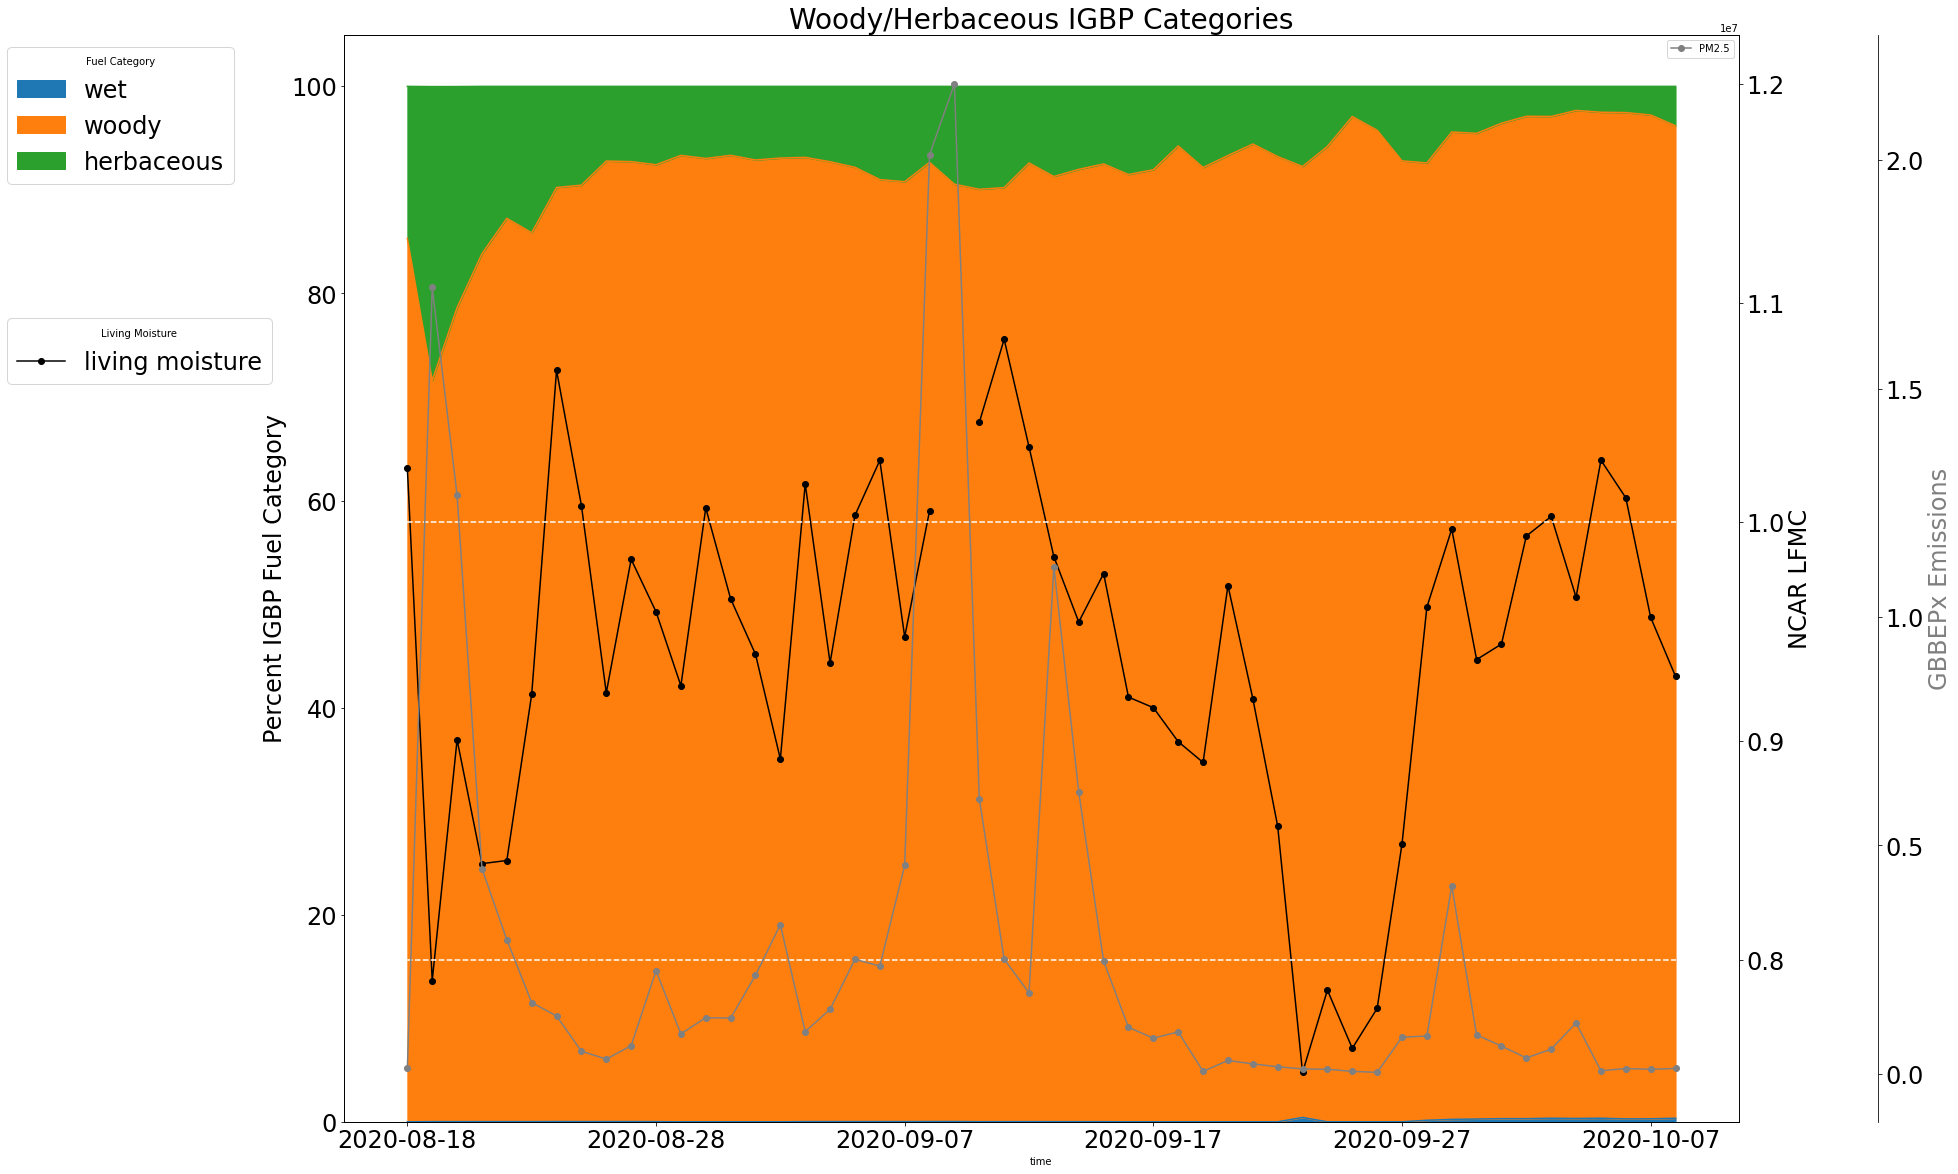

             live    % herb   % woody
live     1.000000 -0.184600  0.184812
% herb  -0.184600  1.000000 -0.999679
% woody  0.184812 -0.999679  1.000000
            emiss    % herb   % woody
emiss    1.000000  0.521427 -0.521889
% herb   0.521427  1.000000 -0.999679
% woody -0.521889 -0.999679  1.000000
              vpd    % herb   % woody
vpd      1.000000  0.468743 -0.470071
% herb   0.468743  1.000000 -0.999679
% woody -0.470071 -0.999679  1.000000


In [74]:
df_igbp_mcclure = pd.read_csv('AC_IGBP_McClure.csv')
df_mcclure= pd.read_csv('AC_McClure.csv')
print(df_mcclure.columns)


df_igbp_mcclure = df_igbp_mcclure.iloc[0:52, :]
df_mcclure= df_mcclure.iloc[0:52, :]

df_mcclure_simple = pd.DataFrame({'time':df_mcclure['time'].values,\
                                  'wet': df_igbp_mcclure['% water'].values+df_igbp_mcclure['% permanent wetlands'].values,\
                                 'woody':df_igbp_mcclure['% evergreen needleleaf forest'].values+\
                                  df_igbp_mcclure['% evergreen broadleaf forest'].values+\
                                 df_igbp_mcclure['% deciduous needleleaf forest'].values+\
                                  df_igbp_mcclure['% deciduous broadleaf forest'].values+\
                                  df_igbp_mcclure['% mixed forests'].values+\
                                  df_igbp_mcclure['% closed shrubland'].values+\
                                  df_igbp_mcclure['% open shrublands'].values+ df_igbp_mcclure['% woody savannas'].values,\
                                 'herbaceous': df_igbp_mcclure['% savannas'].values+ df_igbp_mcclure['% grasslands'].values})
fig,ax=plt.subplots(figsize=(25,20))
df_mcclure_simple.plot.area(x='time',stacked='True', ax=ax, fontsize=24)
plt.legend(title='Fuel Category', bbox_to_anchor=(-.25, 1), loc='upper left', fontsize=24)
plt.ylabel('Percent IGBP Fuel Category', fontsize=24)
ax2=ax.twinx()
df_mcclure.plot(x='time', y='living moisture', ax=ax2, fontsize=24, color='k', marker='o')
#df_mcclure.plot(x='time', y='dead_moisture', ax=ax2, fontsize=24, color='b', marker='o')

plt.plot(df_mcclure_simple['time'].values, .8*np.ones(len(df_mcclure_simple['time'].values)), 'w--')
plt.plot(df_mcclure_simple['time'].values, 1*np.ones(len(df_mcclure_simple['time'].values)), 'w--')
plt.plot(df_mcclure_simple['time'].values, 1.2*np.ones(len(df_mcclure_simple['time'].values)), 'w--')

plt.ylabel('NCAR LFMC', fontsize=24)

plt.legend(title='Living Moisture', bbox_to_anchor=(-.25, .75), loc='upper left', fontsize=24)

ax3=ax.twinx()
ax3.spines["right"].set_position(("axes", 1.1))
df_mcclure.plot(x='time', y='PM2.5', ax=ax3, fontsize=24, color='gray', marker='o')
plt.ylabel('GBBEPx Emissions', fontsize=24,color='gray')



plt.title('Woody/Herbaceous IGBP Categories', fontsize=28)
plt.show()

print(pd.DataFrame({'live': df_mcclure['living moisture'], '% herb': df_mcclure_simple['herbaceous'], '% woody': df_mcclure_simple['woody']}).corr())
print(pd.DataFrame({'emiss': df_mcclure['PM2.5'], '% herb': df_mcclure_simple['herbaceous'], '% woody': df_mcclure_simple['woody']}).corr())
print(pd.DataFrame({'vpd': df_mcclure['vpd'], '% herb': df_mcclure_simple['herbaceous'], '% woody': df_mcclure_simple['woody']}).corr())

Does this align with what we find here: https://www.nwcg.gov/publications/pms437/fuel-moisture/live-fuel-moisture-content
50-80%: 

## Simplified IGBP Time series (4/14/2022)

In [28]:
df_igbp_mcclure = pd.read_csv('AC_IGBP_McClure.csv')
df_mcclure= pd.read_csv('AC_McClure.csv')

df_igbp_thapa = pd.read_csv('AC_IGBP_Thapa.csv')
df_thapa = pd.read_csv('AC_Thapa.csv')




df_mcclure_simple = pd.DataFrame({'wet': df_igbp_mcclure['% water'].values+df_igbp_mcclure['% permanent wetlands'].values,\
                                 'forest':df_igbp_mcclure['% evergreen needleleaf forest'].values+\
                                  df_igbp_mcclure['% evergreen broadleaf forest'].values+\
                                 df_igbp_mcclure['% deciduous needleleaf forest'].values+\
                                  df_igbp_mcclure['% deciduous broadleaf forest'].values+\
                                  df_igbp_mcclure['% mixed forests'].values,\
                                 'shrub': df_igbp_mcclure['% closed shrubland'].values+\
                                  df_igbp_mcclure['% open shrublands'].values,\
                                 'grass': df_igbp_mcclure['% woody savannas'].values+\
                                  df_igbp_mcclure['% savannas'].values+\
                                 df_igbp_mcclure['% grasslands'].values})

df_thapa_simple = pd.DataFrame({'wet': df_igbp_thapa['% water'].values+df_igbp_thapa['% permanent wetlands'].values,\
                                 'forest':df_igbp_thapa['% evergreen needleleaf forest'].values+\
                                  df_igbp_thapa['% evergreen broadleaf forest'].values+\
                                 df_igbp_thapa['% deciduous needleleaf forest'].values+\
                                  df_igbp_thapa['% deciduous broadleaf forest'].values+\
                                  df_igbp_thapa['% mixed forests'].values,\
                                 'shrub': df_igbp_thapa['% closed shrubland'].values+\
                                  df_igbp_thapa['% open shrublands'].values,\
                                 'grass': df_igbp_thapa['% woody savannas'].values+\
                                  df_igbp_thapa['% savannas'].values+\
                                 df_igbp_thapa['% grasslands'].values})

col_names = ['wet', 'forest', 'shrub', 'grass']
plot_twoline(times, np.stack([df_mcclure['vpd'].values, df_thapa['vpd'].values]), 'VPD',\
            [], ['McClure VPD (Pa)', 'Thapa VPD (Pa)'], 1)

plot_twoline(times, np.stack([df_mcclure['living moisture'].values, df_thapa['living moisture'].values]), 'Living Moisture',\
            [], ['McClure Moisture', 'Thapa Moisture'], 1)

for var in col_names:
    print(var)
    print('McClure Correlations: '+ str(pd.DataFrame({'% fuel':df_igbp_mcclure[var].values, 'moisture':df_mcclure['living moisture'].values}).corr()))
    print('Thapa Correlations: '+ str(pd.DataFrame({'% fuel':df_igbp_thapa[var].values, 'moisture':df_thapa['living moisture'].values}).corr()))

    plot_twoline(times, np.stack([df_igbp_mcclure[var].values, df_igbp_thapa[var].values]), var,\
             [], ['% McClure', '% Thapa'], 1)

## Time Series for a fixed polygon (created 4/15/2022)

In [21]:
# choose a polygon, september 27th, 2020, index 41
#choose a polygon september 7th, index 
poly_mcclure = ac_mcclure_daily['geometry'].iloc[41]
times_sub = times[10:25]
print(times_sub)    

['2020-08-28' '2020-08-29' '2020-08-30' '2020-08-31' '2020-09-01'
 '2020-09-02' '2020-09-03' '2020-09-04' '2020-09-05' '2020-09-06'
 '2020-09-07' '2020-09-08' '2020-09-09' '2020-09-10' '2020-09-11']


In [38]:
#get the VPD from MERRA
vpd=np.zeros((2, len(times_sub)))
vapor_pressure=np.zeros((2, len(times_sub)))
saturated_vapor_pressure=np.zeros((2, len(times_sub)))
for ii in range(len(times_sub)):
    print(ii)
    date=str(times_sub[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    path_merra = '/data2/lthapa/'+yr+'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4'
    if '*' in path_merra:
        path_merra = path_merra.replace('*', yr+mo+dy)
    if np.datetime64(date)>=np.datetime64('2020-09-01') and np.datetime64(date)<=np.datetime64('2020-09-30'):
        path_merra = path_merra.replace('400', '401')
    dat = nc.Dataset(path_merra)   
    lat = dat['lat'][:]
    lon = dat['lon'][:]
    t = dat['time'][:]
    if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat)
    T = dat['TLML'][:]
    Q = dat['QLML'][:]
    P = dat['PS'][:]
    W = dat['SPEEDLML'][:]
    print(T.shape)
    
    esat = sat_vap_press(T)
    e = vap_press(Q,P)
    VPD = esat-e
    
    
    lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
    
    #does a polygon exist for this time?
    
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times_sub[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times_sub[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        vpd[0,ii] = np.nan
        vapor_pressure[0,ii] = np.nan
        saturated_vapor_pressure[0,ii]=np.nan
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',1)
        vpd[1,ii] = np.mean(feature_hourly(VPD, overlap_thapa))
        vapor_pressure[1,ii] =np.mean(feature_hourly(e, overlap_thapa))
        saturated_vapor_pressure[1,ii]=np.mean(feature_hourly(esat, overlap_thapa))

        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        vpd[1,ii] = np.nan
        vapor_pressure[1,ii] = np.nan
        saturated_vapor_pressure[1,ii]=np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'rectilinear',1)
        vpd[0,ii] = np.mean(feature_hourly(VPD, overlap_mcclure))
        vapor_pressure[0,ii] =np.mean(feature_hourly(e, overlap_thapa))
        saturated_vapor_pressure[0,ii]=np.mean(feature_hourly(esat, overlap_thapa))
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'rectilinear',1)
        vpd[0,ii] = np.mean(feature_hourly(VPD, overlap_mcclure))
        vapor_pressure[0,ii] =np.mean(feature_hourly(e, overlap_thapa))
        saturated_vapor_pressure[0,ii]=np.mean(feature_hourly(esat, overlap_thapa))

        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',1)
        vpd[1,ii] = np.mean(feature_hourly(VPD, overlap_thapa))
        vapor_pressure[1,ii] =np.mean(feature_hourly(e, overlap_thapa))
        saturated_vapor_pressure[1,ii]=np.mean(feature_hourly(esat, overlap_thapa))



0
(24, 37, 39)
0 both polys
-124.10768990013767 38.49124810023188 -121.61574716580887 41.18355623840735
1 5 15 20
-124.10418588379478 38.49398847910079 -121.61380686766437 41.18120797888193
1 5 15 20
1
(24, 37, 39)
1 both polys
-124.1079419417626 38.49074398929985 -121.66596370630744 41.181949586367885
1 5 15 20
-124.10431251799747 38.49407234648206 -121.62114106159339 41.18185336582046
1 5 15 20
2
(24, 37, 39)
2 both polys
-124.11023067490731 38.48291006595974 -121.66978006812867 41.17804344919772
1 5 15 20
-124.10813607785452 38.48617683324352 -121.67141238242844 41.17651431703201
1 5 15 20
3
(24, 37, 39)
3 both polys
-124.11349519129756 38.47609209234562 -121.66414394693535 41.17620801967228
1 5 15 20
-124.11367162939987 38.477448205628946 -121.65993468657659 41.17520633077867
1 5 15 20
4
(24, 37, 39)
4 both polys
-124.12402955286439 38.47114787027145 -121.61343928526286 41.18114642730418
1 5 15 20
-124.11915257848291 38.47386720423154 -121.61488925847125 41.178489797666145
1 5 15 2

In [32]:
#NCAR Moisture Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
mlive=np.zeros((2, len(times_sub)))
mdead=np.zeros((2, len(times_sub)))


for ii in range(len(times_sub)):
    print(ii)
    date=str(times_sub[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    path_fmc = '/data2/lthapa/2020/FMC/fmc_*_20Z.nc'

    if '*' in path_fmc:
        path_fmc = path_fmc.replace('*', yr+mo+dy)
    print(path_fmc)
    
    try:
        dat = nc.Dataset(path_fmc)  
    except:
        print("No file for this day")
    lat = dat['XLAT_M'][0,:]
    lon = dat['XLONG_M'][0,:]
    print(lon.shape)
    #t = dat['time'][:]
    
    if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat)
    living = dat['FMCGLH2D'][0,:]
    dead = dat['FMCG2D'][0,:]
    print(living)
    
    
    lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
    

    #does a polygon exist for this time?
    
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times_sub[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times_sub[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        mlive[0,ii] = np.nan
        mdead[0,ii] = np.nan
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'curvilinear',0.05)
        mlive[1,ii] = np.mean(feature_hourly(living, overlap_thapa))
        mdead[1,ii] = np.mean(feature_hourly(dead, overlap_thapa))
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        mlive[1,ii] = np.nan
        mdead[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'curvilinear',0.05)
        mlive[0,ii] = np.mean(feature_hourly(living, overlap_mcclure))
        mdead[0,ii] = np.mean(feature_hourly(dead, overlap_mcclure))

    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0], 'curvilinear',0.05)
        mlive[0,ii] = np.mean(feature_hourly(living, overlap_mcclure))
        mdead[0,ii] = np.mean(feature_hourly(dead, overlap_mcclure))
        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], 'curvilinear',0.05)
        mlive[1,ii] = np.mean(feature_hourly(living, overlap_thapa))
        mdead[1,ii] = np.mean(feature_hourly(dead, overlap_thapa))

0
/data2/lthapa/2020/FMC/fmc_20200828_20Z.nc
(3179, 5399)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
0 both polys
-123.15775936620533 39.44123413354297 -122.56515001874752 40.233566682567705
525 596 1985 2083
-123.15422304418973 39.44393767395504 -122.56323509338321 40.23160310155555
525 596 1986 2083
1
/data2/lthapa/2020/FMC/fmc_20200829_20Z.nc
(3179, 5399)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1 both polys
-123.15801145295737 39.4407301290973 -122.61594250390299 40.23196066001376
525 592 1987 2083
-123.15454561334751 39.4434630673241 -122.57011785307967 40.23185973941042
525 596 1986 2083
2
/data2/lthapa/2020/FMC/fmc_20200830_20Z.nc
(3179, 5399)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 

[32.91659761 33.36819023 31.46691802 32.66624347 32.40899659 33.2385429
 27.01802504 24.28085865 30.97010718 42.66235905 43.69506034 29.73282666
 26.49264787 23.14922281 20.33480689]
[30.30621258 32.75832462 31.47219861 31.76961798 32.03154107 31.73561418
 29.7666248  28.30367976 32.64051863 43.99884651 45.95105171 31.72326245
 27.71455059 24.53652393 21.39718152]


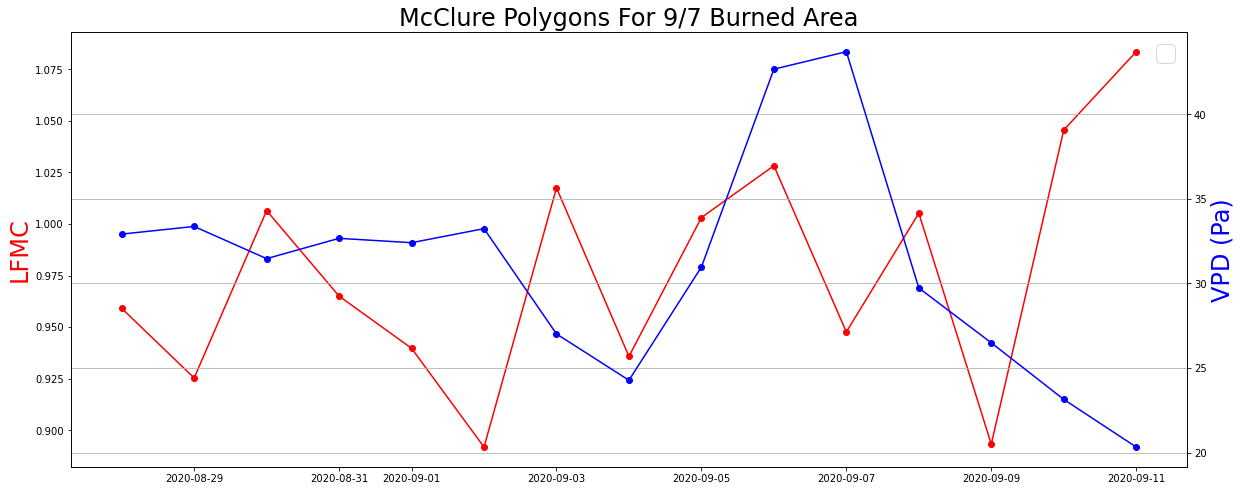

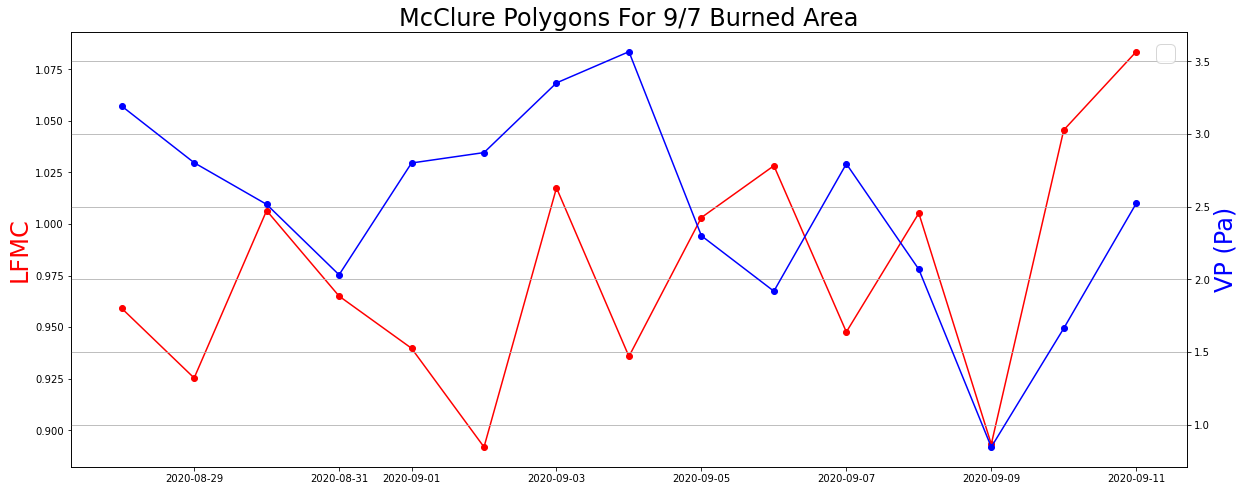

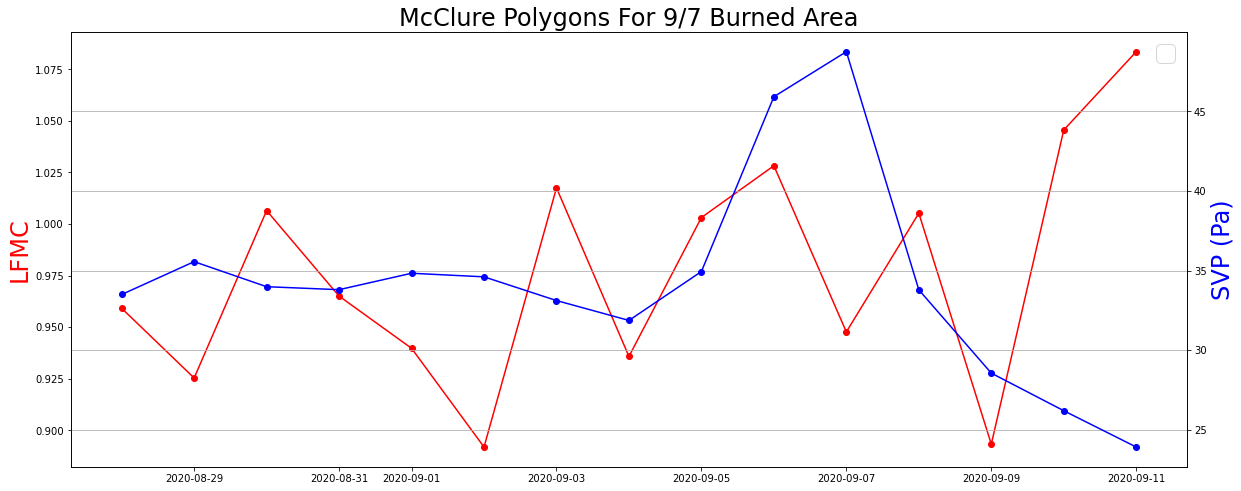

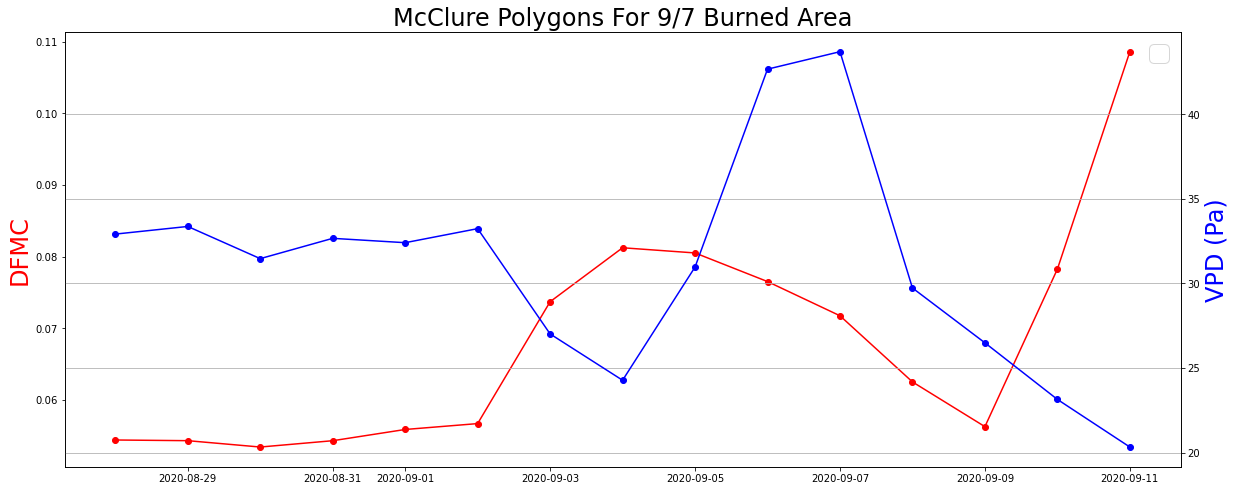

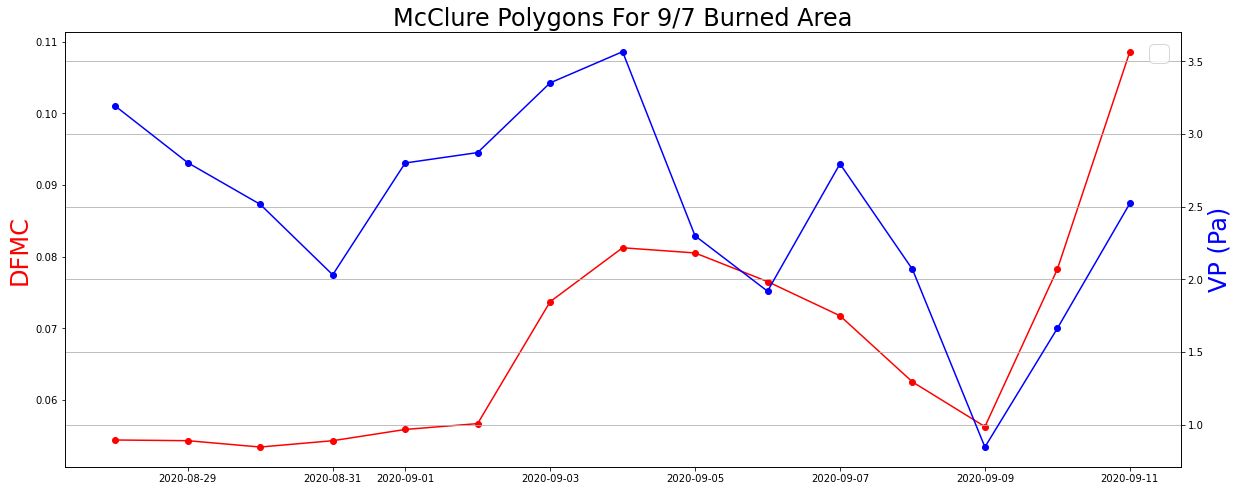

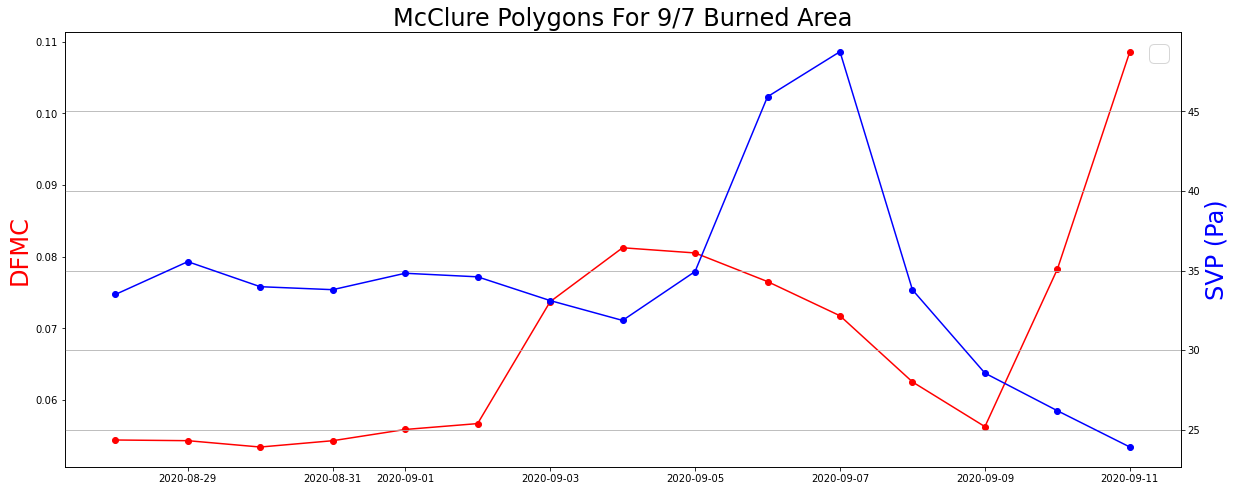

In [44]:
print(vpd[0,:])
print(saturated_vapor_pressure[0,:]-vapor_pressure[0,:])
plot_twoline(times_sub, np.stack([mlive[0,:], vpd[0,:]]), 'McClure Polygons For 9/7 Burned Area',\
             [], ['LFMC', 'VPD (Pa)'], 1)
plot_twoline(times_sub, np.stack([mlive[0,:], vapor_pressure[0,:]]), 'McClure Polygons For 9/7 Burned Area',\
             [], ['LFMC', 'VP (Pa)'], 1)
plot_twoline(times_sub, np.stack([mlive[0,:], saturated_vapor_pressure[0,:]]), 'McClure Polygons For 9/7 Burned Area',\
             [], ['LFMC', 'SVP (Pa)'], 1)


plot_twoline(times_sub, np.stack([mdead[0,:], vpd[0,:]]), 'McClure Polygons For 9/7 Burned Area',\
             [], ['DFMC', 'VPD (Pa)'], 1)
plot_twoline(times_sub, np.stack([mdead[0,:], vapor_pressure[0,:]]), 'McClure Polygons For 9/7 Burned Area',\
             [], ['DFMC', 'VP (Pa)'], 1)
plot_twoline(times_sub, np.stack([mdead[0,:], saturated_vapor_pressure[0,:]]), 'McClure Polygons For 9/7 Burned Area',\
             [], ['DFMC', 'SVP (Pa)'], 1)

## Scatter plots

In [ ]:
#find where personnel and frp ~=nan

nonan_ind = np.where(~np.isnan(personnel)&~np.isnan(frp[1,:])&(frp[1,:]<12000))
print(len(personnel[nonan_ind]))
print(len(frp[1,nonan_ind][0]))
theta = np.polyfit(personnel[nonan_ind], frp[1,nonan_ind][0], 1)
print(theta)
y_line = theta[1] + theta[0] * personnel[nonan_ind]
fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
plt.scatter(personnel, frp[1,:])
plt.plot(personnel[nonan_ind], y_line, 'r')
plt.text(3500, 80000, 'Maybe a negative slope, but pretty driven by outlier')
plt.title('Personnel vs FRP (Thapa Polygons)', fontsize=24)
ax.set_ylabel('FRP (MW)', fontsize=24) 
ax.set_xlabel('Personnel (#)', fontsize=24) 
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
plt.scatter(frp[1,:], carbon_monoxide[1,:])#for the Thapa polygons
df_test_qfed = pd.DataFrame({'FRP':frp[1,:], 'CO':carbon_monoxide[1,:]})
print(df_test_qfed.corr())
print(df_test_qfed.cov())
ax.set_xlabel('FRP (MW)', fontsize=24) 
ax.set_ylabel('Mean QFED CO Emissions (#)', fontsize=24) 
plt.show()

fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
plt.scatter(frp[1,:], df_gbbepx_thapa['CO'].values)#for the Thapa polygons
df_test_gbbepx = pd.DataFrame({'FRP':frp[1,:], 'CO': df_gbbepx_thapa['CO'].values})
print(df_test_gbbepx.corr())
print(df_test_gbbepx.cov())

ax.set_xlabel('FRP (MW)', fontsize=24) 
ax.set_ylabel('Mean GBBEPx CO Emissions (#)', fontsize=24) 
plt.show()

In [ ]:
#fuel moisture
fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
plt.scatter(frp[1,:], mlive[1,:])#for the Thapa polygons
df_test_live = pd.DataFrame({'FRP':frp[1,:], 'mlive':mlive[1,:]})
print(df_test_live.corr())
print(df_test_live.cov())
ax.set_xlabel('FRP (MW)', fontsize=24) 
ax.set_ylabel('Live Fuel Moisture', fontsize=24) 
plt.show()

fig, ax = plt.subplots(figsize=(10,10)) #set up the figure
plt.scatter(frp[1,:], mdead[1,:])#for the Thapa polygons
df_test_dead = pd.DataFrame({'FRP':frp[1,:], 'mdead': mdead[1,:]})
print(df_test_dead.corr())
print(df_test_dead.cov())

ax.set_xlabel('FRP (MW)', fontsize=24) 
ax.set_ylabel('Dead Fuel Moisture', fontsize=24) 
plt.show()

In [ ]:
from sklearn.metrics import explained_variance_score



In [ ]:
nonan_ind_qfed = np.where(~np.isnan(frp[1,:])&~np.isnan( carbon_monoxide[1,:]))
print(explained_variance_score(frp[1,nonan_ind_qfed][0], carbon_monoxide[1,nonan_ind_qfed][0]))

nonan_ind_gbbepx = np.where(~np.isnan(frp[1,:])&~np.isnan( df_gbbepx_thapa['CO'].values))
print(explained_variance_score(frp[1,nonan_ind_gbbepx][0], df_gbbepx_thapa['CO'].values[nonan_ind_gbbepx]))

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'time', 'temp', 'vpd',
       'wind', 'personnel', 'dead_moisture', 'living moisture', 'cod', 'frp',
       'num_points', 'Mean_FRP', 'FRE', 'CO2', 'CO', 'SO2', 'OC', 'BC',
       'PM2.5', 'NOx', 'NH3', 'PM2.5 QFED Rate', 'PM2.5 QFED Total'],
      dtype='object')


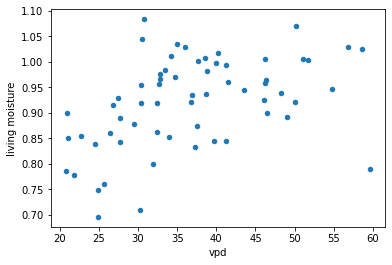

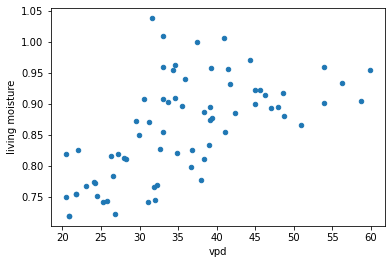

In [5]:
df_igbp_mcclure = pd.read_csv('AC_IGBP_McClure.csv')
df_mcclure= pd.read_csv('AC_McClure.csv')

df_thapa = pd.read_csv('AC_Thapa.csv')
print(df_mcclure.columns)
df_mcclure.plot.scatter(x='vpd', y='living moisture')
plt.show()

df_thapa.plot.scatter(x='vpd', y='living moisture')
plt.show()

## Do some cross correlations

the ccf command doesn't like nans

In [ ]:
vpd_num_thapa = sm.tsa.stattools.ccf(vpd[1,:], num_points[1,:], adjusted=False)
print(vpd_num_thapa)
print(np.argmax(abs(vpd_num_thapa)))

plt.plot(range(len(vpd_num_thapa)), vpd_num_thapa)
plt.show()

temp_num_thapa = sm.tsa.stattools.ccf(wind[1,:], num_points[1,:], adjusted=False)
print(temp_num_thapa)
print(np.argmax(abs(temp_num_thapa)))
plt.plot(range(len(temp_num_thapa)), temp_num_thapa)
plt.show()

## Correlograms

In [ ]:
df_thapa = pd.read_csv('AC_Thapa.csv') #load in the data
df_thapa
sns.pairplot(df_thapa[['vpd', 'wind', 'personnel', 'dead_moisture', 'living moisture', 'frp', 'CO']], kind='reg')
plt.show()

corrMatrix = df_thapa[['vpd', 'wind', 'personnel', 'dead_moisture', 'living moisture', 'frp', 'CO']].corr()
fig,ax=plt.subplots(figsize=(13,13))
sns.heatmap(corrMatrix, annot=True,vmin=-1, vmax=1, cmap='seismic')
plt.show()

In [ ]:
df_mcclure = pd.read_csv('AC_McClure.csv') #load in the data
df_mcclure
sns.pairplot(df_mcclure[['vpd', 'wind', 'personnel', 'dead_moisture', 'living moisture', 'frp', 'CO']], kind='reg')
plt.show()

corrMatrix = df_mcclure[['vpd', 'wind', 'personnel', 'dead_moisture', 'living moisture', 'frp', 'CO']].corr()
fig,ax=plt.subplots(figsize=(13,13))
sns.heatmap(corrMatrix, annot=True, vmin=-1, vmax=1,cmap='seismic')
plt.show()

## Moving Average

In [ ]:
window_size = 7
mdead_series = df_moisture['Dead Thapa']
windows = mdead_series.rolling(window_size)
moving_averages=windows.mean()
moving_averages_list = moving_averages.tolist()
print(len(moving_averages_list))

dead = pd.DataFrame({'FRP':frp[1,:], 'mdead':moving_averages_list})
print(dead.corr())

plot_twoline(times, np.stack([moving_averages_list, frp[1,:]]), 'August Complex Thapa Polygons',\
             [], ['Dead Fuel Moisture Moving Average', 'FRP (MW)'], 1)

## Time Series with history

In [173]:
# FRP and VPD and what the heck HDW, mcclure only
#today = np.datetime64('2020-10-07')
ndays_back = 2
lat_name = 'lat'
lon_name = 'lon'
var_names = ['TLML', 'PS','QLML', 'SPEEDLML']
#poly_today = ac_thapa_daily['geometry'].iloc[50]
gridstyle='rectilinear'
buff_search = 1
#process_hourly = 'mean'


vpd=np.zeros((ndays_back+1, len(days)))
hdw = np.zeros((ndays_back+1, len(days)))
wind =  np.zeros((ndays_back+1, len(days)))
frp = np.zeros((1, len(days)))

for ii in range(len(days)):
    today = days[ii]
    print(today)
    date=str(days[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    
    dataset_path = '/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4'
    if today>=np.datetime64('2020-09-01') and today<=np.datetime64('2020-09-30'):
        dataset_path = path_merra.replace('400', '401')
        
    #is there a McClure poly for today?
    mcclure_ind = np.where(ac_mcclure_daily['Days']==date)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        vpd[:,ii] = np.nan
        wind[:,ii]= np.nan
        frp[:,ii] = np.nan
        hdw[:,ii] = np.nan
    
    else:
        #get the history
        poly_today = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        df_mean = extract_polygon_history(today, ndays_back, dataset_path, lat_name, lon_name, var_names,\
                                          poly_today, gridstyle, buff_search, 'mean')
        df_mean['esat'] = sat_vap_press(df_mean['TLML'])
        df_mean['e']= vap_press(df_mean['QLML'],df_mean['PS'])
        df_mean['vpd'] = esat-e
        df_mean['hdw'] = df_mean['vpd']*df_mean['SPEEDLML']
        
        # row 0 is is today, row ndays_back is the earliest
        for jj in range(ndays_back+1): #jj tracks rows in the output vector, ndays_back-jj tracks where we grab from in the dataframe
            print(ndays_back-jj)
            vpd[jj,ii] = df_mean['vpd'].iloc[ndays_back-jj]
            wind[jj,ii]= df_mean['SPEEDLML'].iloc[ndays_back-jj]
            hdw[jj,ii] = df_mean['hdw'].iloc[ndays_back-jj]
            
        frp[0,ii] = ac_mcclure_daily['FRP'].iloc[mcclure_ind[0]]

2020-08-18
['2020-08-16' '2020-08-17' '2020-08-18']
-124.49478149153829 38.51491037688825 -121.64206306910185 41.25335814193477
1 5 15 21
2
1
0
2020-08-19
['2020-08-17' '2020-08-18' '2020-08-19']
-124.49478149153829 38.51491037688825 -121.64206306910185 41.25335814193477
1 5 15 21
2
1
0
2020-08-20
['2020-08-18' '2020-08-19' '2020-08-20']
-124.49478149153829 38.51491037688825 -121.64206306910185 41.25335814193477
1 5 15 21
2
1
0
2020-08-21
['2020-08-19' '2020-08-20' '2020-08-21']
-124.49478149153829 38.51491037688825 -121.64206306910185 41.25335814193477
1 5 15 21
2
1
0
2020-08-22
['2020-08-20' '2020-08-21' '2020-08-22']
-124.49478149153829 38.51491037688825 -121.64206306910185 41.25335814193477
1 5 15 21
2
1
0
2020-08-23
['2020-08-21' '2020-08-22' '2020-08-23']
-124.49478149153829 38.51491037688825 -121.64206306910185 41.25335814193477
1 5 15 21
2
1
0
2020-08-24
['2020-08-22' '2020-08-23' '2020-08-24']
-124.49478149153829 38.51491037688825 -121.64206306910185 41.25335814193477
1 5 15 2

FileNotFoundError: [Errno 2] No such file or directory: b'/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.20200929.nc4'

## Helper Functions

In [ ]:
def choose_plot_grid_size(days):
    n_days = len(days)
    sizes = np.linspace(1,16, 16)
    squares = sizes**2
    side = np.amin(np.where(squares>n_days))+1
    nrows = side
    ncols = side
    return nrows, ncols

In [23]:
def calculate_grid_cell_corners(LAT, LON):
    #we will assume the very edges of the polygons don't touch the boundary of the domain
    lat_corners = (LAT[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LAT[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    lon_corners = (LON[0:(LAT.shape[0]-1),  0:(LAT.shape[1])-1] + LON[1:(LAT.shape[0]), 1:(LAT.shape[1])])/2
    return lat_corners, lon_corners

In [24]:
# this function calculates the overlap between the given shape (fire_shape) and given grid (LAT, LON). 
# buff_search is the buffer for finding overlaps, =1 for everything except NCAR Fuel = 0.05
#grid type should be 'rectilinear' or 'curvilinear'
#LAT and LON should be 2D

def calculate_overlaps(lat, lon, lat_corners, lon_corners, fire_shape, grid_type, buff_search):
    overlaps = np.zeros(lat.shape)
    # buffer the fire shape so it has a non zero area
    if fire_shape.area ==0:
        fire_shape = fire_shape.buffer(0.01)
    fire_shape = fire_shape.buffer(0)
    #print(fire_shape.area)
    #buffer again by 1 degree so we can get the lat start and lat stop
    fire_shape_buff = fire_shape.buffer(buff_search)
    # get the bounds of the buffered polygon
    w,s,e,n = fire_shape_buff.bounds
    print(w,s,e,n)
    if grid_type =='rectilinear':    
        lat_start = np.unique(np.argmin(np.abs(lat-s), axis=0))[0]
        lat_stop = np.unique(np.argmin(np.abs(lat-n), axis=0))[0]
        lon_start = np.unique(np.argmin(np.abs(lon-w), axis=1))[0]
        lon_stop = np.unique(np.argmin(np.abs(lon-e), axis=1))[0]
        #print(lat_start, lat_stop, lon_start, lon_stop)
    elif grid_type=='curvilinear':
        lon_start, lon_stop, lat_start, lat_stop =  bbox2ij(lon, lat, [w, e, s, n])
        
    print(lon_start, lon_stop, lat_start, lat_stop)
    # find the intersection between the first day's polygon and the  grid
    for ii in range(lat_start, lat_stop):
        for jj in range(lon_start, lon_stop):
            #print(lat[ii,jj], lon[ii,jj])
            poly_cell = Polygon([(lon_corners[ii, jj-1],lat_corners[ii, jj-1]),\
                                 (lon_corners[ii, jj],lat_corners[ii, jj]),\
                                 (lon_corners[ii-1, jj],lat_corners[ii-1, jj-1]),\
                                 (lon_corners[ii-1, jj-1], lat_corners[ii-1, jj-1])])
            #THIS SHOWS THE CELLS WE CHECK FOR OVERLAPS
            #fig = plt.figure(figsize=(15,10))
            #ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
            #gpd.GeoSeries(poly_cell).plot(ax=ax)
            #gpd.GeoSeries(fire_shape).plot(ax=ax, color='r', alpha=0.5)
            #plt.xticks()
            #plt.yticks()
            #plt.show()
            overlap_cell = fire_shape.intersection(poly_cell)
            #print(overlap_cell)
            #overlaps are the fraction of the POLYGON in each grid cell
            overlaps[ii,jj] = overlap_cell.area/fire_shape.area
    
    return overlaps

In [25]:
# this function extracts a feature hourly over the polygon for the day
#IN: feat_grid, the 3d grid of the feature. overlaps: the 2d grid of the overlaps. 3d grid needs time as 1st dimension
#OUT: hourly_vec, the hourly time series of the feature over the day for the polygon

def feature_hourly(feat_grid, overlaps): 
    overlaps_stacked = np.repeat(overlaps[:, :, np.newaxis], 24, axis=2) #stack the 2d overlaps into a 3d grid
    overlaps_swapped = np.swapaxes(np.swapaxes(overlaps_stacked, 0,2), 1,2) #make the same shape as the feature grid

    hourly_grid = np.multiply(overlaps_swapped, feat_grid)
    hourly_vec = np.nansum(np.nansum(hourly_grid, axis=1), axis=1)
    
    return hourly_vec

In [26]:
#plots two lines, on one or on the same axis
# IN: datax, x axis vector (time)
# IN: datay, 2*n vector of the data
# IN: linelabels, string vector of the labels of each line, to go in the legend
# IN: axis labels, labels of the axis
# IN: title, string for title of figire
# IN: twoaxis, if 1 plot data on two separate axes, else plot on the same axis
# OUT: a graph
def plot_twoline(datax, datay, title, linelabels, axislabels, twoaxis):
    fig, ax = plt.subplots(figsize=(20,8)) #set up the figure
    
    if twoaxis==1:
        ax.plot(datax, datay[0,:], 'ro-') # plot the first line
        ax.set_ylabel(axislabels[0], fontsize=24, color='red') 
        ax2=ax.twinx()
        ax2.plot(datax, datay[1,:], 'bo-') #plot the second line
        ax2.set_ylabel(axislabels[1], fontsize=24, color='blue')
        
    else:
        ax.plot(datax, datay[0,:], 'ro-') # plot the first line
        ax.plot(datax, datay[1,:], 'bo-') # plot the second line
        ax.set_ylabel(axislabels, fontsize=24) 
    
        
    plt.legend(linelabels,fontsize=24)
    plt.title(title,fontsize=24)
    plt.grid()
    plt.show()



In [27]:
#finds the most common value of the array (the mode)
#IN the array
#OUT the mode of the array
def find_mode(arr):
    vals,counts = np.unique(arr, return_counts=True)
    index = np.argmax(counts)
    return vals[index]


In [28]:
#fnction is from here: https://gis.stackexchange.com/questions/71630/subsetting-a-curvilinear-netcdf-file-roms-model-output-using-a-lon-lat-boundin
def bbox2ij(lon,lat,bbox):
    bbox=np.array(bbox)
    mypath=np.array([bbox[[0,1,1,0]],bbox[[2,2,3,3]]]).T
    p = path.Path(mypath)
    points = np.vstack((lon.flatten(),lat.flatten())).T
    n,m = np.shape(lon)
    inside = p.contains_points(points).reshape((n,m))
    ii,jj = np.meshgrid(range(m),range(n)) #ii is the columns, jj is the rows
    return min(ii[inside]),max(ii[inside]),min(jj[inside]),max(jj[inside])

In [29]:
earth_SA = 5e14; #surface area of earth m2


def area_per_grid_cell(lats, lons, dlat, dlon):
    r_earth = 6.371e6; #radius of earth in m
    area_per_box = np.zeros((len(lats), len(lons)));
    for ii in range(len(lons)): #loop over the lons/x positions
        for jj in range(len(lats)): # loop over the lats/y positions
            top_lat = lats[jj]+(dlat/2); #upper bounds of the box, centered at (lon_merra(ii),lat_merra(jj)) 
            bottom_lat = lats[jj]-(dlat/2); # lower bounds of the box, centered at (lon_merra(ii),lat_merra(jj)) 
            box_height = dlat*r_earth*(math.pi/180); # box heights in m, constant because latiude lines are parallel
            top_width = (r_earth*dlon*math.pi*np.cos(math.radians(top_lat)))/180;
            bottom_width = (r_earth*dlon*math.pi*np.cos(math.radians(bottom_lat)))/180;
            area_per_box[jj,ii] = (bottom_width + top_width)*box_height/2; # trapezoid approximation, simplifies to triangles at the poles
    return(area_per_box)


In [30]:
#IN: an nc dataset from GOES
#OUT LAT/LON in the right projection
def project_abi(data_cod): #grid edges
    # grab the constants needed to do the projection from GOES grid to lat/lon
    Req = data_cod.variables['goes_imager_projection'].semi_major_axis
    Rpol = data_cod.variables['goes_imager_projection'].semi_minor_axis
    lambda_0 = data_cod.variables['goes_imager_projection'].longitude_of_projection_origin
    lambda_0 = lambda_0*math.pi/180
    Hsat = data_cod.variables['goes_imager_projection'].perspective_point_height
    H = Hsat+Req
    
    # projection from GOES grid to lat/lon, following https://makersportal.com/blog/2018/11/25/goes-r-satellite-latitude-and-longitude-grid-projection-algorithm
    lat_rad_1d = data_cod['x'][:]
    lon_rad_1d = data_cod['y'][:]
    
    [X, Y] = np.meshgrid(lat_rad_1d, lon_rad_1d) # lon is x, lat is y, uses 'xy' indexing by default

    # sin and cos of x and y
    sinx = np.sin(X)
    sinx2 = sinx**2
    siny = np.sin(Y)
    siny2 = siny**2
    cosx = np.cos(X)
    cosx2 = cosx**2
    cosy = np.cos(Y)
    cosy2 = cosy**2

    a = np.power(np.sin(X),2.0) + (np.power(np.cos(X),2.0)*(np.power(np.cos(Y),2.0)+(((Req*Req)/(Rpol*Rpol))*np.power(np.sin(Y),2.0))))
    b = -2.0*H*np.cos(X)*np.cos(Y)
    c = (H**2.0)-(Req**2.0)

    # calculate rs
    rs = (-b - np.sqrt((b**2)-(4*a*c)))/2*a

    # calculate sx, sy, sz
    sx = rs*cosx*cosy
    sy = -rs*sinx
    sz = rs*cosx*siny
        
    # calculate lat and lon
    test = (Req**2/Rpol**2)*(sz/np.sqrt(((H-sx)**2)+(sy**2)))
    lat = np.arctan(test) 
    lon = lambda_0 - np.arctan(sy/(H-sx)) # in radians

    lat_deg = lat*180/math.pi
    lon_deg = lon*180/math.pi

    return lat_deg, lon_deg

In [137]:
# IN 
#today: today's date as a datetime 
# ndays_back: length of the history you want to make (we will have one more than this number)
#dataset_general_path: path to the dataset (one at a time for now) 
#lat_name, lon_name: what lat and lon are called in this dataet
# var_names: variable names you want to extract for the day
# poly_today: today's polygon
# gridstyle: rectilinear or curvilinear
# buff_search: buffer to search around the polygon for overlaps
# process_hourly: 'mean' (take the mean), 'max' (take the max), integer (extact a time)

#OUT 
#df_out: the variables requested by 'var_names' as a dataframe time series
def extract_polygon_history(today, ndays_back, dataset_general_path, lat_name, lon_name, var_names, poly_today,\
                            gridstyle, buff_search, process_hourly):
    #construct the time vector
    times = np.arange(today-np.timedelta64(ndays_back, 'D'), today+np.timedelta64(1, 'D'))
    print(times)
    #construct the output dataframe
    df_dict = dict.fromkeys(var_names, np.zeros(len(times)))
    df_out = pd.DataFrame(df_dict)
    for ii in range(len(times)):
        date=str(times[ii])
        yr = date[0:4]
        mo = date[5:7]
        dy = date[8:10]
        dataset_path = dataset_general_path.replace('*', yr+mo+dy)
        dataset = nc.Dataset(dataset_path)
        if ii == 0: #for the first one, calculate overlaps
            lat = dataset[lat_name]
            lon = dataset[lon_name]
            if len(lat.shape)==1:
                lon, lat = np.meshgrid(lon, lat)
            lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
            #OVERLAPS ARE ONLY CALCULATED ONCE
            overlaps = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0], gridstyle,buff_search)
        for name in var_names:
            field = dataset[name][:]
            #how do we process the hourly data
            hourly = feature_hourly(field, overlaps)
            if process_hourly=='mean':
                df_out[name].iloc[ii] = np.nanmean(hourly)
            elif process_hourly=='max':
                df_out[name].iloc[ii] = np.amax(hourly)
            else:
                df_out[name].iloc[ii] = hourly[process_hourly]
    #stack DF wih times! 
    df_out = pd.concat([pd.DataFrame({'time':times}), df_out], axis=1)
    return df_out

In [153]:
today = np.datetime64('2020-10-07')
ndays_back = 4
dataset_path = '/data2/lthapa/2020/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4'
lat_name = 'lat'
lon_name = 'lon'
var_names = ['TLML', 'PS','QLML', 'SPEEDLML']
poly_today = ac_thapa_daily['geometry'].iloc[50]
gridstyle='rectilinear'
buff_search = 1
#process_hourly = 'mean'
df_mean = extract_polygon_history(today, ndays_back, dataset_path, lat_name, lon_name, var_names, poly_today, gridstyle, buff_search, 'mean')

df_mean['esat'] = sat_vap_press(df_mean['TLML'])
df_mean['e']= vap_press(df_mean['QLML'],df_mean['PS'])
df_mean['vpd'] = esat-e
df_mean['hdw'] = df_mean['vpd']*df_mean['SPEEDLML']

print(df_mean)

['2020-10-03' '2020-10-04' '2020-10-05' '2020-10-06' '2020-10-07']
-124.49478149153829 38.51491037688825 -121.64206306910185 41.25335814193477
1 5 15 21
        time        TLML            PS      QLML  SPEEDLML       esat  \
0 2020-10-03  297.859121  91156.552678  0.004217  4.586740  31.153888   
1 2020-10-04  293.819206  91087.186385  0.004798  3.549246  24.381471   
2 2020-10-05  295.211599  91277.678582  0.003058  3.378463  26.553601   
3 2020-10-06  295.990690  91264.892448  0.002296  2.391352  27.841268   
4 2020-10-07  294.316792  90952.504050  0.003043  3.087685  25.139154   

          e        vpd         hdw  
0  2.401089  28.752799  131.881615  
1  2.731605  21.649866   76.840700  
2  1.741723  24.811879   83.826017  
3  1.306608  26.534661   63.453722  
4  1.726668  23.412486   72.290390  


## Code testing zone

In [ ]:
for ii in range(len(ac_mcclure_daily)):
    print(ii)
    ac_mcclure_daily.loc[[ii],'geometry'].plot(figsize=(7,6))
    plt.show()

In [ ]:
ac_thapa_poly_plot = ac_thapa_poly.reset_index(drop=True)
print(ac_thapa_poly_plot)

for ii in range(len(ac_thapa_poly)):
    print(ii)
    ac_thapa_poly_plot.loc[[ii],'geometry'].plot(figsize=(7,6))
    
    plt.show()

In [ ]:
40.0 -123.125

poly_cell = Polygon([(-123.375,39.75), 
                     (-123.375,40.25), 
                     (-122.875,40.25), 
                     (-122.875, 39.75)])

test = ac_mcclure_daily['geometry'].iloc[5]

ser = gpd.GeoDataFrame({'col1': ['name1', 'name2'],'geometry':[test, poly_cell]})
print(ser)
ser.plot()
plt.show()

In [ ]:
test = ac_mcclure_daily.loc[[5],'geometry']
test_buffer = ac_mcclure_daily.loc[[5],'geometry'].buffer(0)

test.plot()
plt.show()

test_buffer.plot()
plt.show()

In [ ]:
for ii in range(len(ac_mcclure_daily)):
    print(ii)
    w,e,s,n = ac_mcclure_daily['geometry'].iloc[ii].bounds

In [ ]:
#get the max temp for the day
print(dat['TLML'][:].shape)
b = np.repeat(overlap_thapa[:, :, np.newaxis], 24, axis=2)
print(b.shape)
b_swapped = np.swapaxes(np.swapaxes(b, 0,2), 1,2)
print(b_swapped.shape)

temp = np.multiply(b_swapped, dat['TLML'][:])
print(temp.shape)

print(np.nansum(np.nansum(temp, axis=1), axis=1)) #gets hourly temp in the polygon

#temp_hourly=np.zeros(24)
#%for i in range(24):
 #   print(i)
 #   temp_hourly[i] = np.nansum(temp[i, :,:])
#temp_hourly

In [ ]:
print(feature_hourly(dat['TLML'][:], overlap_thapa))
print(feature_hourly(dat['TLML'][:], overlap_mcclure))
print(np.where(overlap_mcclure!=0))
print(np.where(overlap_thapa!=0))

In [ ]:
#MERRA Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
temp=np.zeros((2, len(times)))
vpd=np.zeros((2, len(times)))
num_points = np.zeros((2, len(times)))
frp = np.zeros((2, len(times)))

varis = {'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4':['TLML', 'QLML']}
dims = {'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4':['lat', 'lon', 'time']}
time_extract= {'TLML':12, 'QLML':12, 'SPEEDLML':12, 'PS':12}


for ii in range(len(times)):
    print(ii)
    date=str(times[ii])
    yr = date[0:4]
    mo = date[5:7]
    dy = date[8:10]
    path = '/data2/lthapa/'+yr+'/MERRA2/WESTUS_MERRA2_400.inst1_2d_lfo_Nx.*.nc4'
    if '*' in path:
        path = path.replace('*', yr+mo+dy)
    if np.datetime64(date)>=np.datetime64('2020-09-01') and np.datetime64(date)<=np.datetime64('2020-09-30'):
        path = path.replace('400', '401')
    dat = nc.Dataset(path)   
    lat = dat['lat'][:]
    lon = dat['lon'][:]
    t = dat['time'][:]
    if len(lat.shape)==1:
            lon, lat = np.meshgrid(lon, lat)
    T = dat['TLML'][12,:,:]
    Q = dat['QLML'][12,:,:]
    P = dat['PS'][12,:,:]
    
    esat = sat_vap_press(T)
    e = vap_press(Q,P)
    VPD = esat-e
    
    
    lat_corners, lon_corners = calculate_grid_cell_corners(lat, lon)
    
    #does a polygon exist for this time?
    
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        temp[0,ii] = np.nan
        vpd[0,ii] = np.nan
        frp[0,ii] = np.nan
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        temp[1,ii] = np.nansum(np.multiply(overlap_thapa, T))
        vpd[1,ii] = np.nansum(np.multiply(overlap_thapa, VPD))
        num_points[1,ii] = ac_thapa_daily['Number of VIIRS points'].iloc[thapa_ind[0]]
        frp[1,ii] = ac_thapa_daily['FRP'].iloc[thapa_ind[0]]
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        temp[1,ii] = np.nan
        vpd[1,ii] = np.nan
        num_points[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        temp[0,ii] = np.nansum(np.multiply(overlap_mcclure, T))
        vpd[0,ii] = np.nansum(np.multiply(overlap_mcclure, VPD))
        frp[0,ii] = ac_mcclure_daily['FRP'].iloc[mcclure_ind[0]]
        num_points[0,ii] = ac_mcclure_daily['pixels'].iloc[mcclure_ind[0]]
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        temp[0,ii] = np.nansum(np.multiply(overlap_mcclure, T))
        vpd[0,ii] = np.nansum(np.multiply(overlap_mcclure, VPD))
        frp[0,ii] = ac_mcclure_daily['FRP'].iloc[mcclure_ind[0]]
        num_points[0,ii] = ac_mcclure_daily['pixels'].iloc[mcclure_ind[0]]

        
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        temp[1,ii] = np.nansum(np.multiply(overlap_thapa, T))
        vpd[1,ii] = np.nansum(np.multiply(overlap_thapa, VPD))
        frp[1,ii] = ac_thapa_daily['FRP'].iloc[thapa_ind[0]]
        num_points[1,ii] = ac_thapa_daily['Number of VIIRS points'].iloc[thapa_ind[0]]
    

In [ ]:
ac_thapa_daily.iloc[30:50]
print(num_points)

In [ ]:
type(ac_thapa['Current Day'].iloc[:])
i = str(int(ac_thapa['Current Overpass'].iloc[0]))
print(type(i))
print(i.zfill(4))



In [ ]:
datestrings = [ac_thapa['Current Day'].iloc[i]+ ' '+\
               str(int(ac_thapa['Current Overpass'].iloc[i])).zfill(4) for i in range(len(ac_thapa))]
print(datestrings)

print(np.datetime64())

In [ ]:
print(type(ac_mcclure['DateTim'].iloc[0]))

In [ ]:
if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
        temp[0,ii] = np.nan
        poly_thapa = ac_thapa_poly['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        temp[1,ii] = np.nansum(np.multiply(overlap_thapa, T))
        vpd[1,ii] = np.nansum(np.multiply(overlap_thapa, VPD))
        
    elif len(thapa_ind[0])==0:
        print(ii, 'No Thapa poly!')
        temp[1,ii] = np.nan
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        temp[0,ii] = np.nansum(np.multiply(overlap_mcclure, T))
        vpd[0,ii] = np.nansum(np.multiply(overlap_mcclure, VPD))
    else:
        print(ii, 'both polys')
        poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
        overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])
        temp[0,ii] = np.nansum(np.multiply(overlap_mcclure, T))
        vpd[0,ii] = np.nansum(np.multiply(overlap_mcclure, VPD))
        
        poly_thapa = ac_thapa_poly['geometry'].iloc[thapa_ind[0]]
        overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
        temp[1,ii] = np.nansum(np.multiply(overlap_thapa, T))
        vpd[1,ii] = np.nansum(np.multiply(overlap_thapa, VPD))
        
    poly_thapa = ac_thapa_poly['geometry'].iloc[thapa_ind[0]]
    overlap_thapa = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_thapa.iloc[0])
    
    poly_mcclure = ac_mcclure_daily['geometry'].iloc[mcclure_ind[0]]
    overlap_mcclure = calculate_overlaps(lat,lon,lat_corners,lon_corners,poly_mcclure.iloc[0])

In [ ]:
resources_dates = pd.to_datetime(resources_people_ac['REPORT_FROM_DATE']) + datetime.timedelta(hours=7)
#resources_dates.iloc[:].strftime("%d-%m-%y")
print(resources_dates.iloc[0].strftime("%Y-%m-%d"))

resources_days = [resources_dates.iloc[i].strftime("%Y-%m-%d") for i in range(len(resources_dates))]
print(resources_days)

In [ ]:
personnel/np.max(personnel)

In [ ]:
arr = [1,2,2,2,3,3,4]
print(find_mode(arr))

In [ ]:
print(times[np.argmax(frp[1,:])])

In [ ]:
grid_type ='rectiliner'
if grid_type =='rectilinear':
    print('hello')

In [ ]:
path = './WESTUS_qfed2.emis_co.006.20200818.nc4'
dat = nc.Dataset(path)   
lat = dat['lat'][:]
lon = dat['lon'][:]
LAT, LON = np.meshgrid(lat,lon)
print(LON.shape)
#print(per_box.shape)

per_box = area_per_grid_cell(lat, lon, 0.1, 0.1)
#print(area_per_grid_cell(lat, lon, 0.1, 0.1))

fig = plt.figure(figsize=(15,10))
ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
ax.coastlines()
#ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent([-123.4, -122.6, 39.4, 40.5])
ax.coastlines()
ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
plt.contourf(LON,LAT, per_box )
plt.title('GPPEPx OC Daily Emissions Aug 18th')
plt.colorbar()
plt.show()

In [ ]:
df = pd.DataFrame({'B': [0, 1, 2, np.nan, 4]})


In [ ]:
arr = np.array([1,2,3,4])
print(shift(arr,2,cval=np.nan)) #+2 shifts right 2
print(shift(arr,-2,cval=np.nan)) #+2 shifts right 2



In [ ]:
for jj in range(17):
    print(jj)

In [ ]:
#NCAR Moisture Time Series

#times = np.arange(np.datetime64('2020-08-17'), np.datetime64('2020-10-18')) #how long we have Crystal's polygons for
df_igbp_thapa = pd.DataFrame({'% water':np.zeros(len(times)), '% evergreen needleleaf forest':np.zeros(len(times)),\
                              '% evergreen broadleaf forest':np.zeros(len(times)),\
                              '% deciduous needleleaf forest':np.zeros(len(times)),\
                               '% deciduous broadleaf forest':np.zeros(len(times)), '% mixed forests':np.zeros(len(times)),\
                              '% closed shrubland':np.zeros(len(times)), '% open shrublands':np.zeros(len(times)),\
                              '% woody savannas':np.zeros(len(times)),'% savannas':np.zeros(len(times)),\
                              '% grasslands':np.zeros(len(times)), '% permanent wetlands':np.zeros(len(times)),\
                              '% croplands':np.zeros(len(times)), '% urban and built-up':np.zeros(len(times)),\
                              '% cropland/natural vegetation mosaic':np.zeros(len(times)),\
                              '% snow and ice':np.zeros(len(times)),\
                              '% barren or sparsely vegetated':np.zeros(len(times))})

df_igbp_mcclure = pd.DataFrame({'% water':np.zeros(len(times)), '% evergreen needleleaf forest':np.zeros(len(times)),\
                              '% evergreen broadleaf forest':np.zeros(len(times)),\
                              '% deciduous needleleaf forest':np.zeros(len(times)),\
                               '% deciduous broadleaf forest':np.zeros(len(times)), '% mixed forests':np.zeros(len(times)),\
                              '% closed shrubland':np.zeros(len(times)), '% open shrublands':np.zeros(len(times)),\
                              '% woody savannas':np.zeros(len(times)),'% savannas':np.zeros(len(times)),\
                              '% grasslands':np.zeros(len(times)), '% permanent wetlands':np.zeros(len(times)),\
                              '% croplands':np.zeros(len(times)), '% urban and built-up':np.zeros(len(times)),\
                              '% cropland/natural vegetation mosaic':np.zeros(len(times)),\
                              '% snow and ice':np.zeros(len(times)),\
                              '% barren or sparsely vegetated':np.zeros(len(times))})
#load in the data here so we only have to do it once

dat = nc.Dataset('/data2/lthapa/static_maps/MODIS_IGBP_2020.nc')
lat_center = dat['lat'][:]
lon_center = dat['lon'][:]
lc_majority= dat['lc_majority'][:]
lc_percent = dat['lc_percent'][:]
print(lc_percent.shape)

lat_inds = np.where((lat_center[:,0]>=31)& (lat_center[:,0]<=51))[0]
lat_start = lat_inds[0]
lat_end = lat_inds[len(lat_inds)-1]
lon_inds = np.where((lon_center[0,:]>=-126)& (lon_center[0,:]<=-101))[0]
lon_start = lon_inds[0]
lon_end = lon_inds[len(lon_inds)-1]

lat_corners, lon_corners = calculate_grid_cell_corners(lat_center, lon_center)

for ii in range(len(times)):
    print(ii)
    
    #does a polygon exist for this time?
    mcclure_ind = np.where(ac_mcclure_daily['Days']==str(times[ii]))
    thapa_ind = np.where(ac_thapa_daily['Current Day'] == str(times[ii]))
    #print(mcclure_ind, thapa_ind)
    
    if len(mcclure_ind[0])==0:
        print(ii, 'No mcclure poly')
    
        poly_thapa = ac_thapa_daily['geometry'].iloc[thapa_ind[0]]
        print(poly_thapa)
        overlap_thapa = calculate_overlaps(lat_center,lon_center,lat_corners,lon_corners,poly_thapa.iloc[0], 'rectilinear',0.05)
        overlap_thapa[np.where(overlap_thapa!=0)]=1
        overlap_thapa[np.where(overlap_thapa==0)]=np.nan
        lc_percent_plot = np.multiply(overlap_thapa, lc_percent[1,:,:])
        lc_majority_plot = np.multiply(overlap_thapa, lc_majority)
        print(np.nanmean(np.multiply(overlap_thapa, lc_percent[1, :,:])))
        
        fig = plt.figure(figsize=(15,10))
        ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_extent([-123.5, -122.3, 39.4, 40.5])
        ax.coastlines()
        ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        #levels = np.arange(-0.5,17.5,1) #need to specify levels for the contours
        #print(levels)
        fuelmap = plt.contourf(lon_center[lat_start:lat_end, lon_start:lon_end],\
            lat_center[lat_start:lat_end, lon_start:lon_end],\
           lc_percent_plot[lat_start:lat_end, lon_start:lon_end],\
            cmap='gist_ncar')
        gpd.GeoSeries(poly_thapa).plot(ax=ax, color='w', alpha=0.75)
        plt.colorbar()
        plt.show()
        
        fig = plt.figure(figsize=(15,10))
        ax= fig.add_subplot(111,projection=ccrs.PlateCarree())
        ax.coastlines()
        ax.set_extent([-123.5, -122.3, 39.4, 40.5])
        ax.coastlines()
        ax.add_feature(cfeature.STATES, linestyle='-', alpha=.5)
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
        gl.xlabels_top = False
        gl.ylabels_right = False
        #levels = np.arange(-0.5,17.5,1) #need to specify levels for the contours
        #print(levels)
        fuelmap = plt.contourf(lon_center[lat_start:lat_end, lon_start:lon_end],\
            lat_center[lat_start:lat_end, lon_start:lon_end],\
           lc_majority_plot[lat_start:lat_end, lon_start:lon_end],\
            cmap='gist_ncar')
        gpd.GeoSeries(poly_thapa).plot(ax=ax, color='w', alpha=0.75)
        plt.colorbar()
        plt.show()


In [37]:
df_thapa = pd.read_csv('AC_Thapa.csv')
print(df_thapa.columns)

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'time', 'temp', 'vpd',
       'wind', 'personnel', 'dead_moisture', 'living moisture', 'cod', 'frp',
       'num_points', 'Mean_FRP', 'FRE', 'CO2', 'CO', 'SO2', 'OC', 'BC',
       'PM2.5', 'NOx', 'NH3', 'PM2.5 QFED Rate', 'PM2.5 QFED Total'],
      dtype='object')
